In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from itertools import product
import warnings
from pytorch_lightning.callbacks import EarlyStopping
warnings.filterwarnings('ignore')

# Functions

## Plotting

In [2]:
def plot_graph(df, x_col = "Date", y_col = "Close", title = "S&P 500",
                        xlabel = 'Year', ylabel = 'Close value', start = "", end = ""):
    plt.figure(figsize=(10, 7))
    plt.plot(df[x_col], df[y_col])
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.show()
    return df

def plot_diff_series(df, x_col = "Date", y_col = "Log_Close", periods=365, xlabel= "Year", ylabel = 'Close value change',
                    title = "Differentiated Series Yearly"):
    df_diff = df.copy()
    df_diff = df_diff.set_index(x_col)
    df_diff=df_diff.diff(periods=periods)
    df_diff=df_diff.dropna() 

    plt.figure(figsize=(10, 7))
    plt.plot(df_diff.index, df_diff[y_col])
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    return df_diff

def decompose_time_series(df, x_col = "Date", y_col = "Log_Close", period = 365):
    decomposition = seasonal_decompose(df[y_col], model='additive', period=period)

    plt.figure(figsize=(10, 7))

    plt.subplot(411)
    plt.plot(df[x_col],df[y_col], label='Original')
    plt.legend(loc='upper left')
    plt.title('Original Series')

    plt.subplot(412)
    plt.plot(df[x_col],decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.title('Trend Component')

    plt.subplot(413)
    plt.plot(df[x_col],decomposition.seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    plt.title('Seasonal Component')

    plt.subplot(414)
    plt.plot(df[x_col],decomposition.resid, label='Residuals')
    plt.legend(loc='upper left')
    plt.title('Residual Component')

    plt.tight_layout()
    plt.show()
    df_out = pd.DataFrame({"Date": df["Date"], "seasonal": decomposition.seasonal,
                          "trend": decomposition.trend, "resid":decomposition.resid})
    return df_out

def plot_org_w_pred(data):
    ax = data["Log_Close"].plot(label='Observed', figsize=(10, 5))
    data["Forecast"].plot(ax=ax, label='Forecast', legend=True)
    plt.legend()
    plt.show()

## Processing

In [3]:
def make_full_dates_df(sp500):
    full_sp500 = pd.DataFrame({
        "Date": pd.date_range(sp500["Date"].iloc[0], sp500["Date"].iloc[-1], freq="D")
    })
    
    full_sp500 = full_sp500.merge(sp500, on="Date", how="left")
    full_sp500["Open"].ffill(inplace=True)
    full_sp500["Close"].ffill(inplace=True)
    full_sp500["Adj Close"].ffill(inplace=True)
    full_sp500["Volume"].fillna(0, inplace=True)
    full_sp500["Low"].fillna(full_sp500["Close"], inplace=True)
    full_sp500["High"].fillna(full_sp500["Close"], inplace=True)
    
    return full_sp500

def split_data(data, validation_years=2, seq_length=12):
    validation_start_date = data.index.max() - pd.DateOffset(years=validation_years + seq_length//52)
    train_data = data[data.index < validation_start_date]
    validation_data = data[data.index >= validation_start_date]
    return train_data, validation_data

def create_inout_sequences(input_data, train_seq_len, extra_features=[], prediction_len=1):
    inout_seq = []
    L = len(input_data)
    if len(extra_features):
        combined_data = [ [input_data[i]] + [feature[i] for feature in extra_features] for i in range(L) ]
    else:
        combined_data = input_data
    for i in range(L-train_seq_len-prediction_len+1):
        train_seq = combined_data[i:i+train_seq_len]
        train_label = input_data[i+train_seq_len:i+train_seq_len+prediction_len]
        inout_seq.append((train_seq, train_label))
    return inout_seq

## LSTM functions

In [4]:
def create_dataloader(sequences, batch_size=128, shuffle=True, num_workers=4, persistent_workers=False):
    dataset = TensorDataset(torch.FloatTensor([i[0] for i in sequences]), 
                            torch.FloatTensor([i[1] for i in sequences]))
    loader = DataLoader(dataset, shuffle=shuffle, batch_size=batch_size, 
                        num_workers=num_workers, persistent_workers=persistent_workers)
    return loader

class CustomLSTM(pl.LightningModule):
    def __init__(self, input_size=1, hidden_layer_sizes=[100, 50], output_size=1, learning_rate=0.001,
                 dropout_probs=[0.2, 0.2], seq_length=12):
        super().__init__()
        self.save_hyperparameters()
        
        self.lstm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        self.input_size = input_size
        
        for i, (hidden_size, dropout_prob) in enumerate(zip(hidden_layer_sizes, dropout_probs)):
            input_dim = input_size if i == 0 else hidden_layer_sizes[i-1]
            self.lstm_layers.append(nn.LSTM(input_dim, hidden_size, batch_first=True))
            self.dropout_layers.append(nn.Dropout(dropout_prob))
        
        self.linear = nn.Linear(hidden_layer_sizes[-1], output_size)
        self.seq_length = seq_length

    def forward(self, input_seq):
        current_input = input_seq
        for lstm, dropout in zip(self.lstm_layers, self.dropout_layers):
            lstm_out, _ = lstm(current_input)
            current_input = dropout(lstm_out)
        last_time_step_outputs = current_input[:, -1, :]
        predictions = self.linear(last_time_step_outputs)
        return predictions

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        self.reduce_lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        return {"optimizer": self.optimizer, "lr_scheduler": self.reduce_lr_on_plateau, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        seq, labels = batch
        y_pred = self(seq.view(-1, self.seq_length, self.input_size)) 
        loss = nn.MSELoss()(y_pred, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        seq, labels = batch
        y_pred = self(seq.view(-1, self.seq_length, self.input_size)) 
        val_loss = nn.MSELoss()(y_pred, labels)
        self.log('val_loss', val_loss, on_epoch=True, prog_bar=True)
        return val_loss
    
def train_model(train_loader, validation_loader, input_size=2, hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2], 
                output_size=1, learning_rate=0.001, max_epochs=10, name = "lightning_logs", seq_length=52):
    model = CustomLSTM(input_size=input_size, hidden_layer_sizes=hidden_layer_sizes, dropout_probs=dropout_probs, 
                       output_size=output_size, learning_rate=learning_rate, seq_length=seq_length)
    csv_logger = pl_loggers.CSVLogger(save_dir="logs/", name=name)
    early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10,strict=False,verbose=True,mode='min')
    trainer = pl.Trainer(max_epochs=max_epochs, logger=csv_logger, callbacks = [early_stopping_callback])
    trainer.fit(model, train_loader, validation_loader)
    return model

def predict_iterativly(model, data, start_pred_point = "2019-11-06",
                       prediction_period = 52, add_forcast_to_frame=False, prediction_len=1, seq_length=12):
    predictions = torch.empty(0)
    train_data = data[data.index<start_pred_point]
    predictions_dates = data[data.index>=start_pred_point].index[:prediction_period]
    inference_input = train_data[-seq_length:]["Log_Close"].tolist()
    inference_input_tensor = torch.FloatTensor(inference_input).unsqueeze(0).unsqueeze(-1)
    for i in range(prediction_period//prediction_len + int(prediction_period%prediction_len > 0)):
        model.eval()
        pred = model(inference_input_tensor)[0]
        predictions = torch.cat((predictions, pred))
        inference_input_tensor = torch.cat((inference_input_tensor[:,prediction_len:, :], pred.unsqueeze(0).unsqueeze(-1)), dim = 1)
    predictions = predictions.detach().numpy()[:prediction_period]
    if add_forcast_to_frame:
        data["Forecast"] = np.nan
        data.loc[np.isin(data.index, predictions_dates), "Forecast"] = predictions
        return data
    return predictions_dates

def run_training_pipeline(data, seq_length=12, batch_size=32, input_size=2, hidden_layer_sizes=[100, 50],
                          prediction_len=1, learning_rate=1e-4, max_epochs=100, dropout_probs=[0.2, 0.2],
                          name="weekly", validation_years=2):
    train_data, validation_data = split_data(data, validation_years=validation_years, seq_length=seq_length)
    train_sequences = create_inout_sequences(train_data['Log_Close'].tolist(), seq_length,
                                             [train_data['Log_Close'].index.isocalendar().week.tolist()], prediction_len)
    validation_sequences = create_inout_sequences(validation_data['Log_Close'].tolist(), seq_length,
                                                  [validation_data['Log_Close'].index.isocalendar().week.tolist()], prediction_len)
    train_loader = create_dataloader(train_sequences, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=False)
    validation_loader = create_dataloader(validation_sequences, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
    model = train_model(train_loader, validation_loader, input_size, hidden_layer_sizes,
                        dropout_probs=dropout_probs,  # Assuming a fixed dropout rate
                        output_size=prediction_len, learning_rate=learning_rate, max_epochs=max_epochs,
                        name=name, seq_length=seq_length)
    data = predict_iterativly(model, data, add_forcast_to_frame = True, seq_length=seq_length)
    plot_org_w_pred(data)
    params = {
        'seq_length': seq_length,
        'batch_size': batch_size,
        'input_size': input_size,
        'hidden_layer_sizes': hidden_layer_sizes,
        'prediction_len': prediction_len,
        'learning_rate': learning_rate,
        'max_epochs': max_epochs,
        'dropout_probs': dropout_probs,
        'name': name
    }
    
    params_dir = f"logs/{name}"
    os.makedirs(params_dir, exist_ok=True)
    
    with open(f"{params_dir}/params.json", 'w') as fp:
        json.dump(params, fp, indent=4)
    
    return model

## SARIMA

In [5]:
def forecast_with_sarimax(time_series, forecast_periods, order, seasonal_order, xlabel = 'Year',
                          ylabel = 'Log Close Price', freq='W-MON', plot=True, offset = 0, title = "", forcast_next = False):
    if forcast_next:
        sarima_model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
    else:
        sarima_model = SARIMAX(time_series[:-forecast_periods - offset], order=order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit(disp=False)

    next_periods_forecast = sarima_model_fit.get_forecast(steps=forecast_periods)
    next_periods_ci = next_periods_forecast.conf_int()
    
    if forcast_next:
        future_dates = pd.date_range(start=time_series.index[-1], periods=forecast_periods, freq=freq)
    else:
        future_dates = pd.date_range(start=time_series.index[-forecast_periods - offset], periods=forecast_periods, freq=freq)
    next_periods_ci.index = future_dates

    futureDF_forecast = pd.DataFrame(next_periods_forecast.predicted_mean, index=future_dates)

    if plot:
        if offset == 0:
            ax = time_series.plot(label='Observed', figsize=(10, 5))
        else:
            ax = time_series[:-offset].plot(label='Observed', figsize=(10, 5))
        futureDF_forecast.plot(ax=ax, label='Forecast', legend=True)
        
        ax.fill_between(next_periods_ci.index,
                        next_periods_ci.iloc[:, 0],
                        next_periods_ci.iloc[:, 1], color='k', alpha=.1)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        plt.legend()
        plt.show()
    return futureDF_forecast, next_periods_ci

In [6]:
def get_sarima_mse(time_series, order, seasonal_order, start_pred_point = "2019-11-06",
                       prediction_period = 52, y_col= 'Log_Close'):
    train_data = time_series[time_series["Date"]<start_pred_point][y_col]
    
    sarima_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit(disp=False)

    next_periods_forecast = sarima_model_fit.get_forecast(steps=prediction_period).predicted_mean
    next_periods_true = time_series[time_series["Date"]>start_pred_point][y_col][:prediction_period]
    mse_score = mean_squared_error(next_periods_forecast, next_periods_true)
    return mse_score

def cross_validate_sarima(time_series, cutoffs, order, seasonal_order, prediction_period = 52, y_col= 'Log_Close'):
    folds_res = []
    for i, cutoff in enumerate(cutoffs):
        print(f"starting fold {i+1}/{len(cutoffs)}", end = "\r")
        folds_res.append(get_sarima_mse(time_series, order, seasonal_order, cutoff, prediction_period, y_col))
    return folds_res, np.mean(folds_res)

In [7]:
def hyper_tune_sarima(monthly_data, cutoffs, p_values, d_values, q_values, P_values, D_values, Q_values, s_values,
                     name='sarima_hyperparameters_weekly.csv'):
    results = []
    for (p, d, q, P, D, Q, s) in product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
        order = (p, d, q)
        seasonal_order = (P, D, Q, s)
        try:
            score = cross_validate_sarima(monthly_data, cutoffs, order, seasonal_order)[1]
        except:
            print("failed")
            score = 1
        print(f"order={order}, seasonal_order={seasonal_order}, score={score}")
        results.append((order, seasonal_order, score))
    df = pd.DataFrame(results, columns=['Order', 'Seasonal_Order', 'Score'])
    df.to_csv(name, index=False)
    return df


## Prophet

In [8]:
def hyper_tune_prophet_model(df, cutoffs, param_grid):
    all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
    mses = []

    for params in all_params:
        m = Prophet(**params).fit(df)
        df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days')
        df_p = performance_metrics(df_cv, rolling_window=1)
        mses.append(df_p['mse'].values[0])

    tuning_results = pd.DataFrame(all_params)
    tuning_results['mse'] = mses
    
    return tuning_results

# Data loading

In [9]:
sp500 = pd.read_csv("SPY1950.csv")
sp500["Date"] = pd.to_datetime(sp500["Date"], format = "%d/%m/%Y")
sp500 = make_full_dates_df(sp500)
sp500["Log_Close"] = np.log(sp500["Close"])

In [10]:
sp500.tail(5)

Date         Open         High          Low        Close  \
25869 2020-10-31  3293.590088  3269.959961  3269.959961  3269.959961   
25870 2020-11-01  3293.590088  3269.959961  3269.959961  3269.959961   
25871 2020-11-02  3296.199951  3330.139893  3279.739990  3310.239990   
25872 2020-11-03  3336.250000  3389.489990  3336.250000  3369.159912   
25873 2020-11-04  3406.459961  3486.250000  3405.169922  3443.439941   

         Adj Close        Volume  Log_Close  
25869  3269.959961  0.000000e+00   8.092533  
25870  3269.959961  0.000000e+00   8.092533  
25871  3310.239990  4.310590e+09   8.104776  
25872  3369.159912  4.220070e+09   8.122419  
25873  3443.439941  4.783040e+09   8.144226

In [11]:
weekly_data = sp500[sp500["Date"].dt.dayofweek == 0]
weekly_data.reset_index(inplace = True, drop = True)
weekly_data["Log_Close"] = np.log(weekly_data["Close"])

# Plotting the data

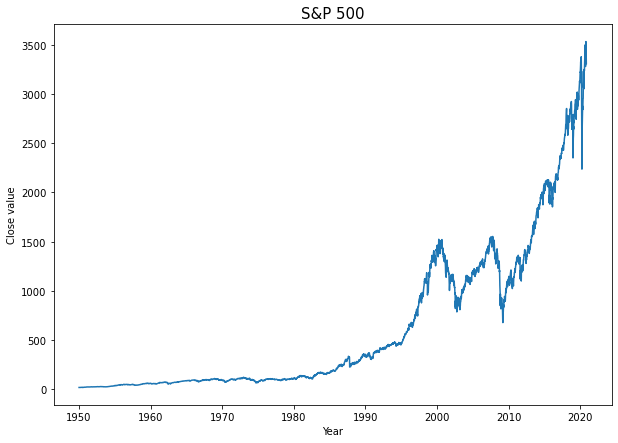

In [12]:
plot_graph(weekly_data);

this graph is rather exponential, lets take a look at the Log Close value

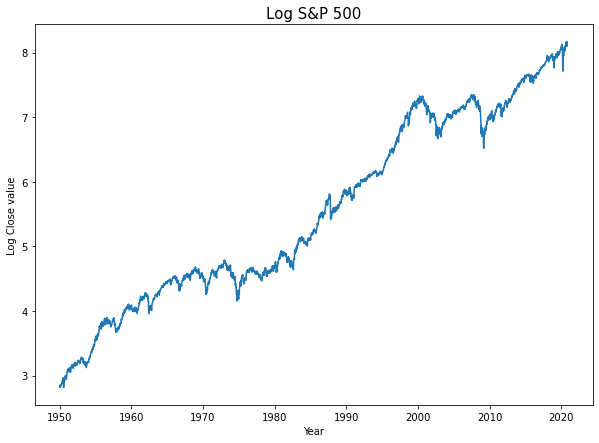

In [13]:
plot_graph(weekly_data, y_col= "Log_Close", ylabel = "Log Close value" , title = "Log S&P 500");

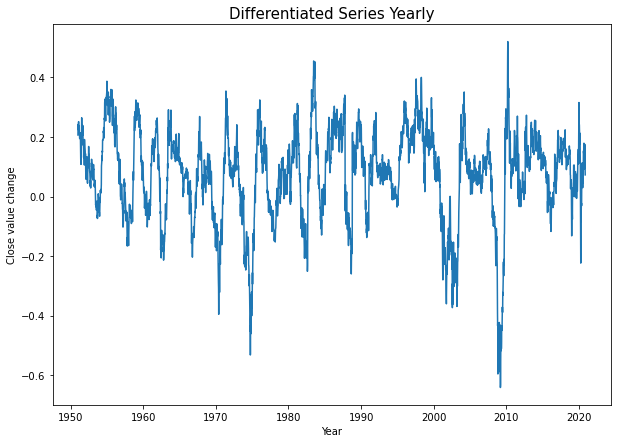

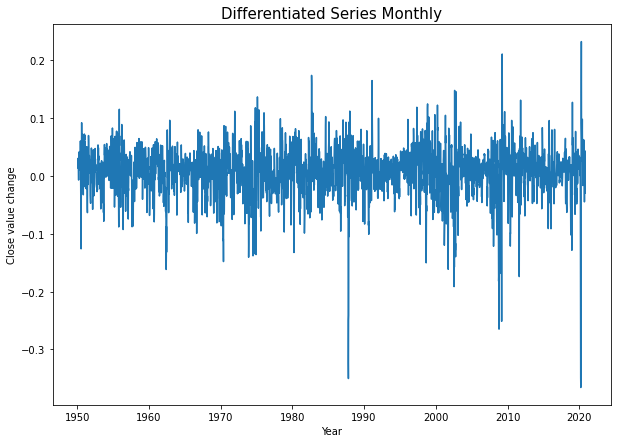

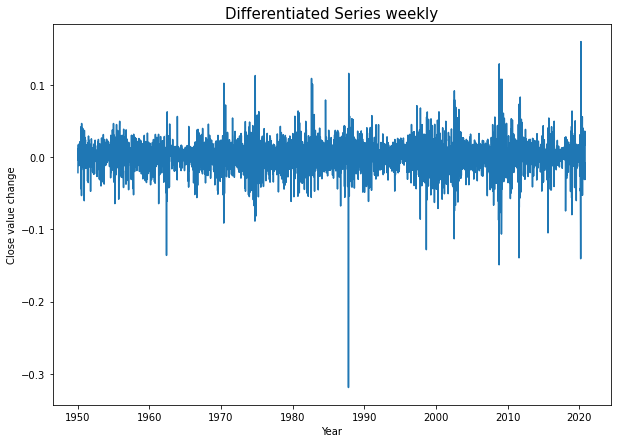

In [14]:
weekly_data_diff_Y = plot_diff_series(weekly_data, periods = 52)
weekly_data_diff_M = plot_diff_series(weekly_data, periods = 4, title = "Differentiated Series Monthly")
weekly_data_diff_W = plot_diff_series(weekly_data, periods = 1, title = "Differentiated Series weekly")

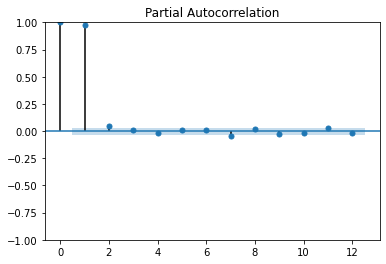

In [15]:
tsaplots.plot_pacf(weekly_data_diff_Y["Log_Close"], lags=12);

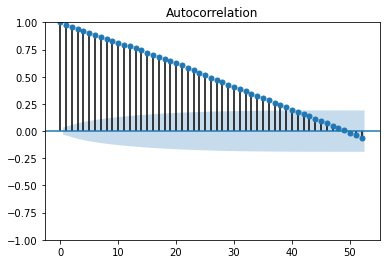

In [16]:
tsaplots.plot_acf(weekly_data_diff_Y["Log_Close"], lags=52);

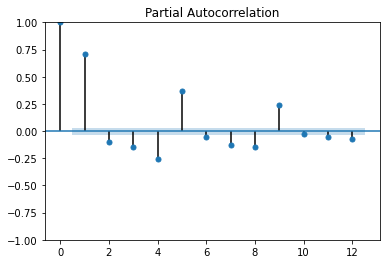

In [17]:
tsaplots.plot_pacf(weekly_data_diff_M["Log_Close"], lags=12);

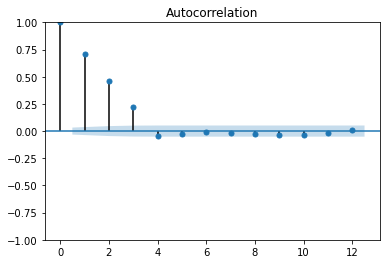

In [18]:
tsaplots.plot_acf(weekly_data_diff_M["Log_Close"], lags=12);

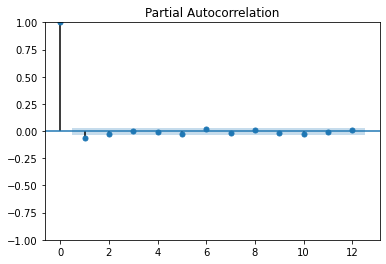

In [19]:
tsaplots.plot_pacf(weekly_data_diff_W["Log_Close"], lags=12);

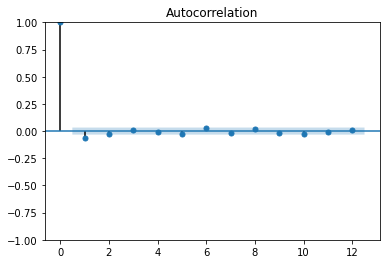

In [20]:
tsaplots.plot_acf(weekly_data_diff_W["Log_Close"], lags=12);

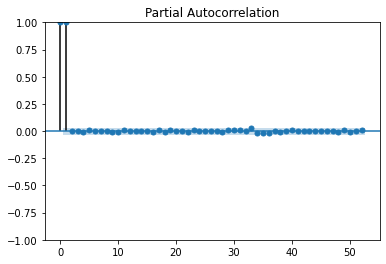

In [21]:
tsaplots.plot_pacf(weekly_data["Log_Close"], lags=52);

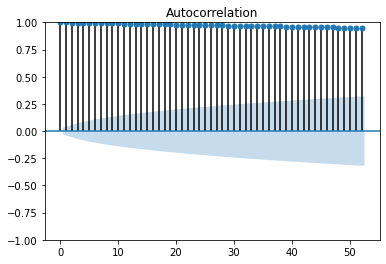

In [22]:
tsaplots.plot_acf(weekly_data["Log_Close"], lags=52);

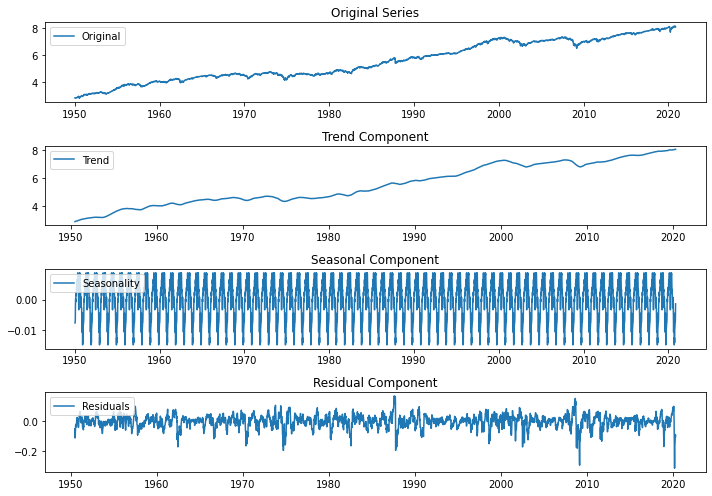

In [23]:
decomposition_year_weekly = decompose_time_series(weekly_data, y_col = "Log_Close", period = 52)

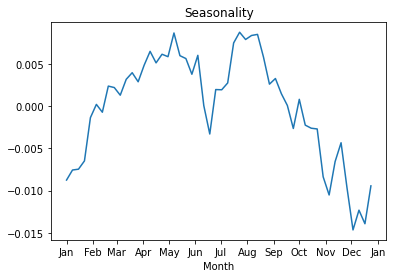

In [24]:
plt.plot(decomposition_year_weekly["Date"][51:103],decomposition_year_weekly["seasonal"][51:103])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel("Month")
plt.title("Seasonality")
plt.plot();

# Modeling

## SARIMA (weekly)

In [28]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*10 + 1969 for i in range(5)]])

In [ ]:
p_values = [1, 2,3]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1,2,3]
D_values = [1,2,3,4]
Q_values = [1,2,3,4]
s_values = [4]
hyper_tune_sarima(weekly_data, cutoffs, p_values, d_values, q_values, P_values, D_values, Q_values, s_values,
                  name='sarima_hyperparameters_weekly_52.csv')

# order=(1, 0, 1), seasonal_order=(0, 2, 4, 4), score=0.006603962916601991
# order=(2, 0, 0), seasonal_order=(0, 2, 4, 4), score=0.0066995197647212405
# order=(1, 0, 0), seasonal_order=(1, 2, 4, 4), score=0.007465368522462384
# order=(1, 0, 1), seasonal_order=(1, 2, 4, 4), score=0.00799524648792118
# order=(1, 1, 2), seasonal_order=(3, 1, 1, 4), score=0.007941594015737855



In [ ]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*10 + 1969 for i in range(5)]])
# p_values = [0, 1, 2,3]
# d_values = [0, 1,2]
# q_values = [0, 1, 2,3]
# P_values = [0, 1,2,3,4]
# D_values = [0, 1,2,3,4]
# Q_values = [0,1,2,3,4]
# s_values = [4]
p_values = [1, 2,3]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1,2,3]
D_values = [1,2,3,4]
Q_values = [1,2,3,4]
s_values = [4]
hyper_tune_sarima(weekly_data, cutoffs, p_values, d_values, q_values, P_values, D_values, Q_values, s_values,
                  name='sarima_hyperparameters_weekly_52.csv')

# order=(1, 0, 1), seasonal_order=(0, 2, 4, 4), score=0.006603962916601991
# order=(2, 0, 0), seasonal_order=(0, 2, 4, 4), score=0.0066995197647212405
# order=(1, 0, 0), seasonal_order=(1, 2, 4, 4), score=0.007465368522462384
# order=(1, 0, 1), seasonal_order=(1, 2, 4, 4), score=0.00799524648792118
# order=(1, 1, 2), seasonal_order=(3, 1, 1, 4), score=0.007941594015737855



order=(0, 0, 0), seasonal_order=(0, 0, 0, 4), score=34.87811400704361
order=(0, 0, 0), seasonal_order=(0, 0, 1, 4), score=32.919669168000084
order=(0, 0, 0), seasonal_order=(0, 0, 2, 4), score=31.291273496139222
order=(0, 0, 0), seasonal_order=(0, 0, 3, 4), score=29.855794992684487
order=(0, 0, 0), seasonal_order=(0, 0, 4, 4), score=28.327790968654444
order=(0, 0, 0), seasonal_order=(0, 1, 0, 4), score=0.01582095782122064
order=(0, 0, 0), seasonal_order=(0, 1, 1, 4), score=0.0157891107998982
order=(0, 0, 0), seasonal_order=(0, 1, 2, 4), score=0.015765429461195395
order=(0, 0, 0), seasonal_order=(0, 1, 3, 4), score=0.016192948873303074
order=(0, 0, 0), seasonal_order=(0, 1, 4, 4), score=0.016900255349801163
order=(0, 0, 0), seasonal_order=(0, 2, 0, 4), score=0.043542223656704265
order=(0, 0, 0), seasonal_order=(0, 2, 1, 4), score=0.012045637535930302
order=(0, 0, 0), seasonal_order=(0, 2, 2, 4), score=0.011983976519136061
order=(0, 0, 0), seasonal_order=(0, 2, 3, 4), score=0.01322465932

order=(0, 0, 0), seasonal_order=(4, 2, 4, 4), score=0.013091672282438729
order=(0, 0, 0), seasonal_order=(4, 3, 0, 4), score=1.280240194198172
order=(0, 0, 0), seasonal_order=(4, 3, 1, 4), score=0.15498102962977844
order=(0, 0, 0), seasonal_order=(4, 3, 2, 4), score=0.19246506901748184
order=(0, 0, 0), seasonal_order=(4, 3, 3, 4), score=0.06468007563845357
order=(0, 0, 0), seasonal_order=(4, 3, 4, 4), score=0.1766256788344693
order=(0, 0, 0), seasonal_order=(4, 4, 0, 4), score=10.775861908843329
order=(0, 0, 0), seasonal_order=(4, 4, 1, 4), score=2.0826231930055012
order=(0, 0, 0), seasonal_order=(4, 4, 2, 4), score=1.1049440281681038
order=(0, 0, 0), seasonal_order=(4, 4, 3, 4), score=1.5183675298357486
order=(0, 0, 0), seasonal_order=(4, 4, 4, 4), score=1.5408603877144782
order=(0, 0, 1), seasonal_order=(0, 0, 0, 4), score=34.38846905696331
order=(0, 0, 1), seasonal_order=(0, 0, 1, 4), score=32.532775028161055
order=(0, 0, 1), seasonal_order=(0, 0, 2, 4), score=30.90255914524497
orde

failedng fold 2/5
order=(0, 0, 1), seasonal_order=(4, 0, 3, 4), score=1
order=(0, 0, 1), seasonal_order=(4, 0, 4, 4), score=0.016308840729212532
order=(0, 0, 1), seasonal_order=(4, 1, 0, 4), score=0.015848899490380024
order=(0, 0, 1), seasonal_order=(4, 1, 1, 4), score=0.0158494486427345
order=(0, 0, 1), seasonal_order=(4, 1, 2, 4), score=0.015909389446825694
order=(0, 0, 1), seasonal_order=(4, 1, 3, 4), score=0.01631004570964623
order=(0, 0, 1), seasonal_order=(4, 1, 4, 4), score=0.016548593891145644
order=(0, 0, 1), seasonal_order=(4, 2, 0, 4), score=0.13469750311398387
order=(0, 0, 1), seasonal_order=(4, 2, 1, 4), score=0.013598320207156045
order=(0, 0, 1), seasonal_order=(4, 2, 2, 4), score=0.012999539924341958
order=(0, 0, 1), seasonal_order=(4, 2, 3, 4), score=0.011162972107394531
order=(0, 0, 1), seasonal_order=(4, 2, 4, 4), score=0.014722551967017083
order=(0, 0, 1), seasonal_order=(4, 3, 0, 4), score=1.2578868374108607
order=(0, 0, 1), seasonal_order=(4, 3, 1, 4), score=0.1723

order=(0, 0, 2), seasonal_order=(3, 3, 2, 4), score=0.37477920577560864
order=(0, 0, 2), seasonal_order=(3, 3, 3, 4), score=0.39059987775031385
order=(0, 0, 2), seasonal_order=(3, 3, 4, 4), score=0.3359846969203345
order=(0, 0, 2), seasonal_order=(3, 4, 0, 4), score=16.95352813957958
order=(0, 0, 2), seasonal_order=(3, 4, 1, 4), score=1.7627122557913117
order=(0, 0, 2), seasonal_order=(3, 4, 2, 4), score=1.6902486142084303
order=(0, 0, 2), seasonal_order=(3, 4, 3, 4), score=1.8996509916679432
order=(0, 0, 2), seasonal_order=(3, 4, 4, 4), score=1.6458292500564435
order=(0, 0, 2), seasonal_order=(4, 0, 0, 4), score=0.02049726528583046
order=(0, 0, 2), seasonal_order=(4, 0, 1, 4), score=0.01899647105480621
order=(0, 0, 2), seasonal_order=(4, 0, 2, 4), score=0.016930721873156244
failedng fold 3/5
order=(0, 0, 2), seasonal_order=(4, 0, 3, 4), score=1
failedng fold 3/5
order=(0, 0, 2), seasonal_order=(4, 0, 4, 4), score=1
order=(0, 0, 2), seasonal_order=(4, 1, 0, 4), score=0.0162772750773920

order=(0, 0, 3), seasonal_order=(3, 1, 1, 4), score=0.014278584804612998
order=(0, 0, 3), seasonal_order=(3, 1, 2, 4), score=0.015298203339285655
order=(0, 0, 3), seasonal_order=(3, 1, 3, 4), score=0.01535663778055375
order=(0, 0, 3), seasonal_order=(3, 1, 4, 4), score=0.013592470655710742
order=(0, 0, 3), seasonal_order=(3, 2, 0, 4), score=0.12036739576651315
order=(0, 0, 3), seasonal_order=(3, 2, 1, 4), score=0.011724698042443315
order=(0, 0, 3), seasonal_order=(3, 2, 2, 4), score=0.01007972605845327
order=(0, 0, 3), seasonal_order=(3, 2, 3, 4), score=0.010430545903506911
order=(0, 0, 3), seasonal_order=(3, 2, 4, 4), score=0.010650781765792284
order=(0, 0, 3), seasonal_order=(3, 3, 0, 4), score=1.9786034826661933
order=(0, 0, 3), seasonal_order=(3, 3, 1, 4), score=0.1906454315761398
order=(0, 0, 3), seasonal_order=(3, 3, 2, 4), score=0.20084792512884536
order=(0, 0, 3), seasonal_order=(3, 3, 3, 4), score=0.35782843584637564
order=(0, 0, 3), seasonal_order=(3, 3, 4, 4), score=0.304533

order=(0, 1, 0), seasonal_order=(2, 4, 0, 4), score=558.1521903259518
order=(0, 1, 0), seasonal_order=(2, 4, 1, 4), score=24.15325155819998
order=(0, 1, 0), seasonal_order=(2, 4, 2, 4), score=31.12086656595895
order=(0, 1, 0), seasonal_order=(2, 4, 3, 4), score=4.874641127817846
order=(0, 1, 0), seasonal_order=(2, 4, 4, 4), score=1.9365224534165417
order=(0, 1, 0), seasonal_order=(3, 0, 0, 4), score=0.013764465594913547
order=(0, 1, 0), seasonal_order=(3, 0, 1, 4), score=0.013755332818680105
order=(0, 1, 0), seasonal_order=(3, 0, 2, 4), score=0.013987996145319504
order=(0, 1, 0), seasonal_order=(3, 0, 3, 4), score=0.014130395667496128
order=(0, 1, 0), seasonal_order=(3, 0, 4, 4), score=0.01388682793863127
order=(0, 1, 0), seasonal_order=(3, 1, 0, 4), score=0.1189840805094026
order=(0, 1, 0), seasonal_order=(3, 1, 1, 4), score=0.009902403629894202
order=(0, 1, 0), seasonal_order=(3, 1, 2, 4), score=0.010243475080882133
order=(0, 1, 0), seasonal_order=(3, 1, 3, 4), score=0.01061719278655

order=(0, 1, 1), seasonal_order=(2, 1, 4, 4), score=0.010463899237433799
order=(0, 1, 1), seasonal_order=(2, 2, 0, 4), score=2.6316367110727414
order=(0, 1, 1), seasonal_order=(2, 2, 1, 4), score=0.08017413279701864
order=(0, 1, 1), seasonal_order=(2, 2, 2, 4), score=0.053399154426443295
order=(0, 1, 1), seasonal_order=(2, 2, 3, 4), score=0.014302759012078869
order=(0, 1, 1), seasonal_order=(2, 2, 4, 4), score=0.018565351415029012
order=(0, 1, 1), seasonal_order=(2, 3, 0, 4), score=72.28007689986858
order=(0, 1, 1), seasonal_order=(2, 3, 1, 4), score=2.647737197440109
order=(0, 1, 1), seasonal_order=(2, 3, 2, 4), score=2.6198584744180957
order=(0, 1, 1), seasonal_order=(2, 3, 3, 4), score=2.3791095682870753
order=(0, 1, 1), seasonal_order=(2, 3, 4, 4), score=0.44767897306678395
order=(0, 1, 1), seasonal_order=(2, 4, 0, 4), score=561.8066475309621
order=(0, 1, 1), seasonal_order=(2, 4, 1, 4), score=25.56765868202938
order=(0, 1, 1), seasonal_order=(2, 4, 2, 4), score=32.11866109463536
o

order=(0, 1, 2), seasonal_order=(1, 4, 3, 4), score=1.7561940405142689
order=(0, 1, 2), seasonal_order=(1, 4, 4, 4), score=1.7969885075364265
order=(0, 1, 2), seasonal_order=(2, 0, 0, 4), score=0.013764750257517647
order=(0, 1, 2), seasonal_order=(2, 0, 1, 4), score=0.013768410156112298
order=(0, 1, 2), seasonal_order=(2, 0, 2, 4), score=0.01373329186341612
order=(0, 1, 2), seasonal_order=(2, 0, 3, 4), score=0.01389925159503417
order=(0, 1, 2), seasonal_order=(2, 0, 4, 4), score=0.013911586420994927
order=(0, 1, 2), seasonal_order=(2, 1, 0, 4), score=0.07898286090171479
order=(0, 1, 2), seasonal_order=(2, 1, 1, 4), score=0.010047755126093606
order=(0, 1, 2), seasonal_order=(2, 1, 2, 4), score=0.009977818848449546
order=(0, 1, 2), seasonal_order=(2, 1, 3, 4), score=0.010594458112076963
order=(0, 1, 2), seasonal_order=(2, 1, 4, 4), score=0.010510017873945302
order=(0, 1, 2), seasonal_order=(2, 2, 0, 4), score=2.5630328596591854
order=(0, 1, 2), seasonal_order=(2, 2, 1, 4), score=0.079856

order=(0, 1, 3), seasonal_order=(1, 2, 2, 4), score=0.07133451018288539
order=(0, 1, 3), seasonal_order=(1, 2, 3, 4), score=0.1366321682373481
order=(0, 1, 3), seasonal_order=(1, 2, 4, 4), score=0.011360709416883403
order=(0, 1, 3), seasonal_order=(1, 3, 0, 4), score=120.25300076650137
order=(0, 1, 3), seasonal_order=(1, 3, 1, 4), score=2.810791948743479
order=(0, 1, 3), seasonal_order=(1, 3, 2, 4), score=4.529070181456406
order=(0, 1, 3), seasonal_order=(1, 3, 3, 4), score=0.4125533496555997
order=(0, 1, 3), seasonal_order=(1, 3, 4, 4), score=0.5116873809316301
order=(0, 1, 3), seasonal_order=(1, 4, 0, 4), score=825.2995980015785
order=(0, 1, 3), seasonal_order=(1, 4, 1, 4), score=34.147128945279704
order=(0, 1, 3), seasonal_order=(1, 4, 2, 4), score=6.918193618850255
order=(0, 1, 3), seasonal_order=(1, 4, 3, 4), score=1.8444176361307378
order=(0, 1, 3), seasonal_order=(1, 4, 4, 4), score=2.7761125159382463
order=(0, 1, 3), seasonal_order=(2, 0, 0, 4), score=0.013766974206316576
order

order=(0, 2, 0), seasonal_order=(1, 0, 2, 4), score=0.2752913997869853
order=(0, 2, 0), seasonal_order=(1, 0, 3, 4), score=0.254659097740784
order=(0, 2, 0), seasonal_order=(1, 0, 4, 4), score=0.2592170553206633
order=(0, 2, 0), seasonal_order=(1, 1, 0, 4), score=13.63167982293408
order=(0, 2, 0), seasonal_order=(1, 1, 1, 4), score=0.26049018429650855
order=(0, 2, 0), seasonal_order=(1, 1, 2, 4), score=0.283371669771
order=(0, 2, 0), seasonal_order=(1, 1, 3, 4), score=0.24433251368116132
order=(0, 2, 0), seasonal_order=(1, 1, 4, 4), score=0.2688869761741316
order=(0, 2, 0), seasonal_order=(1, 2, 0, 4), score=118.35845886591123
order=(0, 2, 0), seasonal_order=(1, 2, 1, 4), score=13.797739759658484
order=(0, 2, 0), seasonal_order=(1, 2, 2, 4), score=0.27631015669283104
order=(0, 2, 0), seasonal_order=(1, 2, 3, 4), score=0.24827205355993684
order=(0, 2, 0), seasonal_order=(1, 2, 4, 4), score=0.2347363213467577
order=(0, 2, 0), seasonal_order=(1, 3, 0, 4), score=776.7591833732658
order=(0,

order=(0, 2, 1), seasonal_order=(0, 3, 3, 4), score=0.4687061888849885
order=(0, 2, 1), seasonal_order=(0, 3, 4, 4), score=0.2996702141796899
order=(0, 2, 1), seasonal_order=(0, 4, 0, 4), score=2425.3742473012944
order=(0, 2, 1), seasonal_order=(0, 4, 1, 4), score=97.15367832683229
order=(0, 2, 1), seasonal_order=(0, 4, 2, 4), score=3.0950879663516924
order=(0, 2, 1), seasonal_order=(0, 4, 3, 4), score=3.2084760782200403
order=(0, 2, 1), seasonal_order=(0, 4, 4, 4), score=2.1038145122563536
order=(0, 2, 1), seasonal_order=(1, 0, 0, 4), score=0.010307929731271289
order=(0, 2, 1), seasonal_order=(1, 0, 1, 4), score=0.01037501207532889
order=(0, 2, 1), seasonal_order=(1, 0, 2, 4), score=0.010069804422803749
order=(0, 2, 1), seasonal_order=(1, 0, 3, 4), score=0.010281305191065664
order=(0, 2, 1), seasonal_order=(1, 0, 4, 4), score=0.010217341909461627
order=(0, 2, 1), seasonal_order=(1, 1, 0, 4), score=0.03309010921591909
order=(0, 2, 1), seasonal_order=(1, 1, 1, 4), score=0.01313122086764

order=(0, 2, 2), seasonal_order=(0, 1, 2, 4), score=0.012737345970489719
order=(0, 2, 2), seasonal_order=(0, 1, 3, 4), score=0.012586694023094041
order=(0, 2, 2), seasonal_order=(0, 1, 4, 4), score=0.012926513537310391
order=(0, 2, 2), seasonal_order=(0, 2, 0, 4), score=24.94620152179234
order=(0, 2, 2), seasonal_order=(0, 2, 1, 4), score=0.07015184478545952
order=(0, 2, 2), seasonal_order=(0, 2, 2, 4), score=0.028104679072115557
order=(0, 2, 2), seasonal_order=(0, 2, 3, 4), score=0.03771502167056302
order=(0, 2, 2), seasonal_order=(0, 2, 4, 4), score=0.0288405755635305
order=(0, 2, 2), seasonal_order=(0, 3, 0, 4), score=439.24152927636226
order=(0, 2, 2), seasonal_order=(0, 3, 1, 4), score=9.714258175436756
order=(0, 2, 2), seasonal_order=(0, 3, 2, 4), score=0.3620086808360991
order=(0, 2, 2), seasonal_order=(0, 3, 3, 4), score=0.4539542320536259
order=(0, 2, 2), seasonal_order=(0, 3, 4, 4), score=0.5555652505358274
order=(0, 2, 2), seasonal_order=(0, 4, 0, 4), score=2192.545390401178

order=(0, 2, 2), seasonal_order=(4, 4, 2, 4), score=59.1825772275518
order=(0, 2, 2), seasonal_order=(4, 4, 3, 4), score=98.0550975514912
order=(0, 2, 2), seasonal_order=(4, 4, 4, 4), score=127.92877687756274
order=(0, 2, 3), seasonal_order=(0, 0, 0, 4), score=0.0118294434944067
order=(0, 2, 3), seasonal_order=(0, 0, 1, 4), score=0.01189838818556342
order=(0, 2, 3), seasonal_order=(0, 0, 2, 4), score=0.011198564872737023
order=(0, 2, 3), seasonal_order=(0, 0, 3, 4), score=0.012899391883327843
order=(0, 2, 3), seasonal_order=(0, 0, 4, 4), score=0.011884375205861086
order=(0, 2, 3), seasonal_order=(0, 1, 0, 4), score=0.017471816666989437
order=(0, 2, 3), seasonal_order=(0, 1, 1, 4), score=0.013641142267285009
order=(0, 2, 3), seasonal_order=(0, 1, 2, 4), score=0.012518516389151671
order=(0, 2, 3), seasonal_order=(0, 1, 3, 4), score=0.01199506624993874
order=(0, 2, 3), seasonal_order=(0, 1, 4, 4), score=0.015456026562344526
order=(0, 2, 3), seasonal_order=(0, 2, 0, 4), score=13.3600069591

order=(0, 2, 3), seasonal_order=(4, 2, 2, 4), score=0.13024915131622067
order=(0, 2, 3), seasonal_order=(4, 2, 3, 4), score=0.19328075328206765
order=(0, 2, 3), seasonal_order=(4, 2, 4, 4), score=0.08983313438276097
order=(0, 2, 3), seasonal_order=(4, 3, 0, 4), score=38.34348898112411
order=(0, 2, 3), seasonal_order=(4, 3, 1, 4), score=3.3685603879354398
order=(0, 2, 3), seasonal_order=(4, 3, 2, 4), score=3.116084359601426
order=(0, 2, 3), seasonal_order=(4, 3, 3, 4), score=5.320500365203655
order=(0, 2, 3), seasonal_order=(4, 3, 4, 4), score=5.487241474587067
order=(0, 2, 3), seasonal_order=(4, 4, 0, 4), score=526.5521855401782
order=(0, 2, 3), seasonal_order=(4, 4, 1, 4), score=37.54911423607931
order=(0, 2, 3), seasonal_order=(4, 4, 2, 4), score=68.91429802990498
order=(0, 2, 3), seasonal_order=(4, 4, 3, 4), score=70.82669587080018
order=(0, 2, 3), seasonal_order=(4, 4, 4, 4), score=186.6912432306019
order=(1, 0, 0), seasonal_order=(0, 0, 0, 4), score=0.014067589971333633
order=(1, 

order=(1, 0, 0), seasonal_order=(4, 0, 1, 4), score=0.03416609558504519
failedng fold 1/5
order=(1, 0, 0), seasonal_order=(4, 0, 2, 4), score=1
order=(1, 0, 0), seasonal_order=(4, 0, 3, 4), score=0.013000583807306074
failedng fold 3/5
order=(1, 0, 0), seasonal_order=(4, 0, 4, 4), score=1
order=(1, 0, 0), seasonal_order=(4, 1, 0, 4), score=0.020635230509521388
order=(1, 0, 0), seasonal_order=(4, 1, 1, 4), score=0.025307789152234604
order=(1, 0, 0), seasonal_order=(4, 1, 2, 4), score=0.015651256923022723
order=(1, 0, 0), seasonal_order=(4, 1, 3, 4), score=0.014710195535764376
order=(1, 0, 0), seasonal_order=(4, 1, 4, 4), score=0.017507705632293473
order=(1, 0, 0), seasonal_order=(4, 2, 0, 4), score=0.14546313028825897
order=(1, 0, 0), seasonal_order=(4, 2, 1, 4), score=0.1174243974242786
order=(1, 0, 0), seasonal_order=(4, 2, 2, 4), score=0.02920352061230235
order=(1, 0, 0), seasonal_order=(4, 2, 3, 4), score=0.014973029265097604
order=(1, 0, 0), seasonal_order=(4, 2, 4, 4), score=0.0100

order=(1, 0, 1), seasonal_order=(3, 3, 0, 4), score=2.8119146439261846
order=(1, 0, 1), seasonal_order=(3, 3, 1, 4), score=0.24861466080046424
order=(1, 0, 1), seasonal_order=(3, 3, 2, 4), score=0.3969643003082145
order=(1, 0, 1), seasonal_order=(3, 3, 3, 4), score=0.3248939107920824
order=(1, 0, 1), seasonal_order=(3, 3, 4, 4), score=0.2731853427175103
order=(1, 0, 1), seasonal_order=(3, 4, 0, 4), score=26.35167184271276
order=(1, 0, 1), seasonal_order=(3, 4, 1, 4), score=8.112721271862505
order=(1, 0, 1), seasonal_order=(3, 4, 2, 4), score=2.2069868770312975
order=(1, 0, 1), seasonal_order=(3, 4, 3, 4), score=2.686842615231219
order=(1, 0, 1), seasonal_order=(3, 4, 4, 4), score=1.9682473582895
order=(1, 0, 1), seasonal_order=(4, 0, 0, 4), score=0.08160347770507007
order=(1, 0, 1), seasonal_order=(4, 0, 1, 4), score=0.03136139962968618
order=(1, 0, 1), seasonal_order=(4, 0, 2, 4), score=0.02998224328474729
order=(1, 0, 1), seasonal_order=(4, 0, 3, 4), score=0.02081664152713775
order=(

order=(1, 0, 2), seasonal_order=(3, 0, 4, 4), score=0.015549934877324608
order=(1, 0, 2), seasonal_order=(3, 1, 0, 4), score=0.018062857564575537
order=(1, 0, 2), seasonal_order=(3, 1, 1, 4), score=0.01695406481537042
order=(1, 0, 2), seasonal_order=(3, 1, 2, 4), score=0.014249522289654976
order=(1, 0, 2), seasonal_order=(3, 1, 3, 4), score=0.016685246047470646
order=(1, 0, 2), seasonal_order=(3, 1, 4, 4), score=0.01095957310625591
order=(1, 0, 2), seasonal_order=(3, 2, 0, 4), score=0.0993056254678228
order=(1, 0, 2), seasonal_order=(3, 2, 1, 4), score=0.03968651548301736
order=(1, 0, 2), seasonal_order=(3, 2, 2, 4), score=0.01474292831410528
order=(1, 0, 2), seasonal_order=(3, 2, 3, 4), score=0.015646979017744766
order=(1, 0, 2), seasonal_order=(3, 2, 4, 4), score=0.05986315220425355
order=(1, 0, 2), seasonal_order=(3, 3, 0, 4), score=2.834596274546909
order=(1, 0, 2), seasonal_order=(3, 3, 1, 4), score=0.3979587579390666
order=(1, 0, 2), seasonal_order=(3, 3, 2, 4), score=0.403893709

order=(1, 0, 3), seasonal_order=(2, 3, 3, 4), score=0.33284773548337243
order=(1, 0, 3), seasonal_order=(2, 3, 4, 4), score=0.3169897379537551
order=(1, 0, 3), seasonal_order=(2, 4, 0, 4), score=24.141197240779213
order=(1, 0, 3), seasonal_order=(2, 4, 1, 4), score=1.962880296475077
order=(1, 0, 3), seasonal_order=(2, 4, 2, 4), score=1.9376354293649622
order=(1, 0, 3), seasonal_order=(2, 4, 3, 4), score=1.6745098250515937
order=(1, 0, 3), seasonal_order=(2, 4, 4, 4), score=1.5320080822591753
order=(1, 0, 3), seasonal_order=(3, 0, 0, 4), score=0.07558274242605241
order=(1, 0, 3), seasonal_order=(3, 0, 1, 4), score=0.03719992218244407
order=(1, 0, 3), seasonal_order=(3, 0, 2, 4), score=0.02826909005913466
failedng fold 4/5
order=(1, 0, 3), seasonal_order=(3, 0, 3, 4), score=1
failedng fold 5/5
order=(1, 0, 3), seasonal_order=(3, 0, 4, 4), score=1
order=(1, 0, 3), seasonal_order=(3, 1, 0, 4), score=0.014347450537812034
order=(1, 0, 3), seasonal_order=(3, 1, 1, 4), score=0.0151165111810122

order=(1, 1, 0), seasonal_order=(2, 1, 2, 4), score=0.010050999170285067
order=(1, 1, 0), seasonal_order=(2, 1, 3, 4), score=0.010544811988603447
order=(1, 1, 0), seasonal_order=(2, 1, 4, 4), score=0.010428932647028433
order=(1, 1, 0), seasonal_order=(2, 2, 0, 4), score=2.6389937244350308
order=(1, 1, 0), seasonal_order=(2, 2, 1, 4), score=0.07980121695726157
order=(1, 1, 0), seasonal_order=(2, 2, 2, 4), score=0.04048009216364101
order=(1, 1, 0), seasonal_order=(2, 2, 3, 4), score=0.01331474871149313
order=(1, 1, 0), seasonal_order=(2, 2, 4, 4), score=0.02142748888312273
order=(1, 1, 0), seasonal_order=(2, 3, 0, 4), score=72.39804666393897
order=(1, 1, 0), seasonal_order=(2, 3, 1, 4), score=2.720426512503112
order=(1, 1, 0), seasonal_order=(2, 3, 2, 4), score=2.619229570551434
order=(1, 1, 0), seasonal_order=(2, 3, 3, 4), score=2.6433964778098025
order=(1, 1, 0), seasonal_order=(2, 3, 4, 4), score=0.441318776533679
order=(1, 1, 0), seasonal_order=(2, 4, 0, 4), score=562.1945014177843
o

order=(1, 1, 1), seasonal_order=(1, 4, 2, 4), score=1.4351793509614628
order=(1, 1, 1), seasonal_order=(1, 4, 3, 4), score=1.7015520960322792
order=(1, 1, 1), seasonal_order=(1, 4, 4, 4), score=1.6871700512720722
order=(1, 1, 1), seasonal_order=(2, 0, 0, 4), score=0.013678921232083854
order=(1, 1, 1), seasonal_order=(2, 0, 1, 4), score=0.013703628893447149
order=(1, 1, 1), seasonal_order=(2, 0, 2, 4), score=0.01365855454766711
order=(1, 1, 1), seasonal_order=(2, 0, 3, 4), score=0.013826969749409376
order=(1, 1, 1), seasonal_order=(2, 0, 4, 4), score=0.01372934536624513
order=(1, 1, 1), seasonal_order=(2, 1, 0, 4), score=0.07769370655663485
order=(1, 1, 1), seasonal_order=(2, 1, 1, 4), score=0.010426638719744332
order=(1, 1, 1), seasonal_order=(2, 1, 2, 4), score=0.010062515468299147
order=(1, 1, 1), seasonal_order=(2, 1, 3, 4), score=0.010575520433837696
order=(1, 1, 1), seasonal_order=(2, 1, 4, 4), score=0.010399936907008448
order=(1, 1, 1), seasonal_order=(2, 2, 0, 4), score=0.345940

order=(1, 1, 2), seasonal_order=(1, 2, 1, 4), score=0.028482406673049392
order=(1, 1, 2), seasonal_order=(1, 2, 2, 4), score=0.016689816513948557
order=(1, 1, 2), seasonal_order=(1, 2, 3, 4), score=0.14784153655216076
order=(1, 1, 2), seasonal_order=(1, 2, 4, 4), score=0.013706277168486252
order=(1, 1, 2), seasonal_order=(1, 3, 0, 4), score=110.91293962086347
order=(1, 1, 2), seasonal_order=(1, 3, 1, 4), score=2.6079759516304906
order=(1, 1, 2), seasonal_order=(1, 3, 2, 4), score=2.325675756523292
order=(1, 1, 2), seasonal_order=(1, 3, 3, 4), score=0.33446992267350384
order=(1, 1, 2), seasonal_order=(1, 3, 4, 4), score=0.41931912909045543
order=(1, 1, 2), seasonal_order=(1, 4, 0, 4), score=633.8729244701101
order=(1, 1, 2), seasonal_order=(1, 4, 1, 4), score=33.718688977937454
order=(1, 1, 2), seasonal_order=(1, 4, 2, 4), score=4.126727055044336
order=(1, 1, 2), seasonal_order=(1, 4, 3, 4), score=1.757499515959502
order=(1, 1, 2), seasonal_order=(1, 4, 4, 4), score=5.462262828865378
or

order=(1, 1, 3), seasonal_order=(1, 0, 1, 4), score=0.013898226117682499
order=(1, 1, 3), seasonal_order=(1, 0, 2, 4), score=0.01381834352285316
order=(1, 1, 3), seasonal_order=(1, 0, 3, 4), score=0.013949069683448273
order=(1, 1, 3), seasonal_order=(1, 0, 4, 4), score=0.013891566307102771
order=(1, 1, 3), seasonal_order=(1, 1, 0, 4), score=0.029851987143872587
order=(1, 1, 3), seasonal_order=(1, 1, 1, 4), score=0.009714224282418565
order=(1, 1, 3), seasonal_order=(1, 1, 2, 4), score=0.009499186530622771
order=(1, 1, 3), seasonal_order=(1, 1, 3, 4), score=0.010032740782079932
order=(1, 1, 3), seasonal_order=(1, 1, 4, 4), score=0.010187283922129262
order=(1, 1, 3), seasonal_order=(1, 2, 0, 4), score=1.6140027881011458
order=(1, 1, 3), seasonal_order=(1, 2, 1, 4), score=0.031138593522411974
order=(1, 1, 3), seasonal_order=(1, 2, 2, 4), score=0.01733430675233888
order=(1, 1, 3), seasonal_order=(1, 2, 3, 4), score=0.01990488215283685
order=(1, 1, 3), seasonal_order=(1, 2, 4, 4), score=0.01

order=(1, 2, 0), seasonal_order=(0, 3, 1, 4), score=612.4070890534682
order=(1, 2, 0), seasonal_order=(0, 3, 2, 4), score=19.474694343920728
order=(1, 2, 0), seasonal_order=(0, 3, 3, 4), score=17.127643397387438
order=(1, 2, 0), seasonal_order=(0, 3, 4, 4), score=15.017793086962651
order=(1, 2, 0), seasonal_order=(0, 4, 0, 4), score=130142.80288355185
order=(1, 2, 0), seasonal_order=(0, 4, 1, 4), score=1676.3907535938702
order=(1, 2, 0), seasonal_order=(0, 4, 2, 4), score=55.79590559255769
order=(1, 2, 0), seasonal_order=(0, 4, 3, 4), score=22.198637587709417
order=(1, 2, 0), seasonal_order=(0, 4, 4, 4), score=21.540805027288386
order=(1, 2, 0), seasonal_order=(1, 0, 0, 4), score=0.20212093339062473
order=(1, 2, 0), seasonal_order=(1, 0, 1, 4), score=0.2079517165219827
order=(1, 2, 0), seasonal_order=(1, 0, 2, 4), score=0.19931626771099895
order=(1, 2, 0), seasonal_order=(1, 0, 3, 4), score=0.20916298436049524
order=(1, 2, 0), seasonal_order=(1, 0, 4, 4), score=0.19919341211663402
orde

order=(1, 2, 1), seasonal_order=(0, 1, 2, 4), score=0.012000140519619566
order=(1, 2, 1), seasonal_order=(0, 1, 3, 4), score=0.012963613153244152
order=(1, 2, 1), seasonal_order=(0, 1, 4, 4), score=0.018852247732224846
order=(1, 2, 1), seasonal_order=(0, 2, 0, 4), score=27.04587790829613
order=(1, 2, 1), seasonal_order=(0, 2, 1, 4), score=0.0713764748795831
order=(1, 2, 1), seasonal_order=(0, 2, 2, 4), score=0.022840425521471124
order=(1, 2, 1), seasonal_order=(0, 2, 3, 4), score=0.02763968074878053
order=(1, 2, 1), seasonal_order=(0, 2, 4, 4), score=0.02513709285400722
order=(1, 2, 1), seasonal_order=(0, 3, 0, 4), score=436.69892093177697
order=(1, 2, 1), seasonal_order=(0, 3, 1, 4), score=10.280082365037135
order=(1, 2, 1), seasonal_order=(0, 3, 2, 4), score=0.39919335502384784
order=(1, 2, 1), seasonal_order=(0, 3, 3, 4), score=0.48931355798383647
order=(1, 2, 1), seasonal_order=(0, 3, 4, 4), score=0.31822083972614745
order=(1, 2, 1), seasonal_order=(0, 4, 0, 4), score=2157.64374170

order=(1, 2, 1), seasonal_order=(4, 4, 2, 4), score=112.26811224181691
order=(1, 2, 1), seasonal_order=(4, 4, 3, 4), score=68.66752236134491
order=(1, 2, 1), seasonal_order=(4, 4, 4, 4), score=178.05182045163113
order=(1, 2, 2), seasonal_order=(0, 0, 0, 4), score=0.01063189960338807
order=(1, 2, 2), seasonal_order=(0, 0, 1, 4), score=0.01085295943459548
order=(1, 2, 2), seasonal_order=(0, 0, 2, 4), score=0.009958163269087305
order=(1, 2, 2), seasonal_order=(0, 0, 3, 4), score=0.009997244213005857
order=(1, 2, 2), seasonal_order=(0, 0, 4, 4), score=0.010324859906261533
order=(1, 2, 2), seasonal_order=(0, 1, 0, 4), score=0.0332166730919649
order=(1, 2, 2), seasonal_order=(0, 1, 1, 4), score=0.011010275586054816
order=(1, 2, 2), seasonal_order=(0, 1, 2, 4), score=0.011482839204299194
order=(1, 2, 2), seasonal_order=(0, 1, 3, 4), score=0.011626000304013225
order=(1, 2, 2), seasonal_order=(0, 1, 4, 4), score=0.014564874260462856
order=(1, 2, 2), seasonal_order=(0, 2, 0, 4), score=24.4528157

order=(1, 2, 2), seasonal_order=(4, 2, 1, 4), score=0.12751829594370234
order=(1, 2, 2), seasonal_order=(4, 2, 2, 4), score=0.12573376397756453
order=(1, 2, 2), seasonal_order=(4, 2, 3, 4), score=0.12721367054143756
order=(1, 2, 2), seasonal_order=(4, 2, 4, 4), score=0.07385215271206205
order=(1, 2, 2), seasonal_order=(4, 3, 0, 4), score=32.64806385758068
order=(1, 2, 2), seasonal_order=(4, 3, 1, 4), score=1.3841315591222756
order=(1, 2, 2), seasonal_order=(4, 3, 2, 4), score=2.056577926878862
order=(1, 2, 2), seasonal_order=(4, 3, 3, 4), score=2.9663876959844133
order=(1, 2, 2), seasonal_order=(4, 3, 4, 4), score=2.9695191508552172
order=(1, 2, 2), seasonal_order=(4, 4, 0, 4), score=166.39600587803983
order=(1, 2, 2), seasonal_order=(4, 4, 1, 4), score=22.72833974015979
order=(1, 2, 2), seasonal_order=(4, 4, 2, 4), score=13.534585597937872
order=(1, 2, 2), seasonal_order=(4, 4, 3, 4), score=23.49333759764435
order=(1, 2, 2), seasonal_order=(4, 4, 4, 4), score=41.08366474382305
order=(

order=(1, 2, 3), seasonal_order=(4, 0, 1, 4), score=0.011341750588092088
order=(1, 2, 3), seasonal_order=(4, 0, 2, 4), score=0.011239952712438377
order=(1, 2, 3), seasonal_order=(4, 0, 3, 4), score=0.010617088430919337
order=(1, 2, 3), seasonal_order=(4, 0, 4, 4), score=0.01097270479025205
order=(1, 2, 3), seasonal_order=(4, 1, 0, 4), score=0.12178597857616143
order=(1, 2, 3), seasonal_order=(4, 1, 1, 4), score=0.018628165248530525
order=(1, 2, 3), seasonal_order=(4, 1, 2, 4), score=0.013881182163454697
order=(1, 2, 3), seasonal_order=(4, 1, 3, 4), score=0.015062116335401415
order=(1, 2, 3), seasonal_order=(4, 1, 4, 4), score=0.015133943533107064
order=(1, 2, 3), seasonal_order=(4, 2, 0, 4), score=0.5381698131360423
order=(1, 2, 3), seasonal_order=(4, 2, 1, 4), score=0.12951844056956577
order=(1, 2, 3), seasonal_order=(4, 2, 2, 4), score=0.13956596742916313
order=(1, 2, 3), seasonal_order=(4, 2, 3, 4), score=0.11350460972595042
order=(1, 2, 3), seasonal_order=(4, 2, 4, 4), score=0.0395

order=(2, 0, 0), seasonal_order=(3, 3, 0, 4), score=3.1954794353513
order=(2, 0, 0), seasonal_order=(3, 3, 1, 4), score=0.3327508292025258
order=(2, 0, 0), seasonal_order=(3, 3, 2, 4), score=0.48513230684552744
order=(2, 0, 0), seasonal_order=(3, 3, 3, 4), score=0.3491420354660866
order=(2, 0, 0), seasonal_order=(3, 3, 4, 4), score=0.2727620525395456
order=(2, 0, 0), seasonal_order=(3, 4, 0, 4), score=29.941600622792656
order=(2, 0, 0), seasonal_order=(3, 4, 1, 4), score=4.310294433016931
order=(2, 0, 0), seasonal_order=(3, 4, 2, 4), score=2.2776123626747373
order=(2, 0, 0), seasonal_order=(3, 4, 3, 4), score=2.039380244134521
order=(2, 0, 0), seasonal_order=(3, 4, 4, 4), score=1.6680147389398001
order=(2, 0, 0), seasonal_order=(4, 0, 0, 4), score=0.06934896340770014
order=(2, 0, 0), seasonal_order=(4, 0, 1, 4), score=0.03119845132715233
order=(2, 0, 0), seasonal_order=(4, 0, 2, 4), score=0.026139125347336922
failedng fold 4/5
order=(2, 0, 0), seasonal_order=(4, 0, 3, 4), score=1
order

failedng fold 1/5
order=(2, 0, 1), seasonal_order=(3, 0, 4, 4), score=1
order=(2, 0, 1), seasonal_order=(3, 1, 0, 4), score=0.08623920320784763
order=(2, 0, 1), seasonal_order=(3, 1, 1, 4), score=0.024701213931850763
order=(2, 0, 1), seasonal_order=(3, 1, 2, 4), score=0.010526030063192925
order=(2, 0, 1), seasonal_order=(3, 1, 3, 4), score=0.01374846897100454
order=(2, 0, 1), seasonal_order=(3, 1, 4, 4), score=0.016652849976258002
order=(2, 0, 1), seasonal_order=(3, 2, 0, 4), score=0.09247721999886305
order=(2, 0, 1), seasonal_order=(3, 2, 1, 4), score=0.11367482568359717
order=(2, 0, 1), seasonal_order=(3, 2, 2, 4), score=0.011754782230021285
order=(2, 0, 1), seasonal_order=(3, 2, 3, 4), score=0.014923258116436324
order=(2, 0, 1), seasonal_order=(3, 2, 4, 4), score=0.0120792620378469
order=(2, 0, 1), seasonal_order=(3, 3, 0, 4), score=3.1348389682204174
order=(2, 0, 1), seasonal_order=(3, 3, 1, 4), score=0.2848923676318612
order=(2, 0, 1), seasonal_order=(3, 3, 2, 4), score=0.28141582

order=(2, 0, 2), seasonal_order=(2, 3, 3, 4), score=0.3012182237046609
order=(2, 0, 2), seasonal_order=(2, 3, 4, 4), score=0.08262104439417613
order=(2, 0, 2), seasonal_order=(2, 4, 0, 4), score=35.12305600014133
order=(2, 0, 2), seasonal_order=(2, 4, 1, 4), score=21.77671285395517
order=(2, 0, 2), seasonal_order=(2, 4, 2, 4), score=1.6374389044198274
order=(2, 0, 2), seasonal_order=(2, 4, 3, 4), score=1.6976502550770083
order=(2, 0, 2), seasonal_order=(2, 4, 4, 4), score=0.8603341581671959
order=(2, 0, 2), seasonal_order=(3, 0, 0, 4), score=0.07811620478813876
order=(2, 0, 2), seasonal_order=(3, 0, 1, 4), score=0.06969126550465825
order=(2, 0, 2), seasonal_order=(3, 0, 2, 4), score=0.08110565344059925
failedng fold 5/5
order=(2, 0, 2), seasonal_order=(3, 0, 3, 4), score=1
failedng fold 2/5
order=(2, 0, 2), seasonal_order=(3, 0, 4, 4), score=1
order=(2, 0, 2), seasonal_order=(3, 1, 0, 4), score=0.019216139788200998
order=(2, 0, 2), seasonal_order=(3, 1, 1, 4), score=0.0119812822548506


order=(2, 0, 3), seasonal_order=(2, 1, 2, 4), score=0.01290499596176874
order=(2, 0, 3), seasonal_order=(2, 1, 3, 4), score=0.013729686774775363
order=(2, 0, 3), seasonal_order=(2, 1, 4, 4), score=0.014941734475768914
order=(2, 0, 3), seasonal_order=(2, 2, 0, 4), score=0.07500748883333078
order=(2, 0, 3), seasonal_order=(2, 2, 1, 4), score=0.019352488327050516
order=(2, 0, 3), seasonal_order=(2, 2, 2, 4), score=0.010967195714812744
order=(2, 0, 3), seasonal_order=(2, 2, 3, 4), score=0.014432992677732018
order=(2, 0, 3), seasonal_order=(2, 2, 4, 4), score=0.01331646717315221
order=(2, 0, 3), seasonal_order=(2, 3, 0, 4), score=3.2453310481821007
order=(2, 0, 3), seasonal_order=(2, 3, 1, 4), score=0.346014866928534
order=(2, 0, 3), seasonal_order=(2, 3, 2, 4), score=0.29921137091544525
order=(2, 0, 3), seasonal_order=(2, 3, 3, 4), score=0.40218944931138634
order=(2, 0, 3), seasonal_order=(2, 3, 4, 4), score=0.39588847209876943
order=(2, 0, 3), seasonal_order=(2, 4, 0, 4), score=21.0579250

order=(2, 1, 0), seasonal_order=(1, 4, 1, 4), score=33.695389490676824
order=(2, 1, 0), seasonal_order=(1, 4, 2, 4), score=2.230201787982117
order=(2, 1, 0), seasonal_order=(1, 4, 3, 4), score=1.7658094819802757
order=(2, 1, 0), seasonal_order=(1, 4, 4, 4), score=1.8633364134360992
order=(2, 1, 0), seasonal_order=(2, 0, 0, 4), score=0.013757956548702172
order=(2, 1, 0), seasonal_order=(2, 0, 1, 4), score=0.01382121935929521
order=(2, 1, 0), seasonal_order=(2, 0, 2, 4), score=0.013721686266842528
order=(2, 1, 0), seasonal_order=(2, 0, 3, 4), score=0.013908823061388248
order=(2, 1, 0), seasonal_order=(2, 0, 4, 4), score=0.013927128503237216
order=(2, 1, 0), seasonal_order=(2, 1, 0, 4), score=0.07887193892971929
order=(2, 1, 0), seasonal_order=(2, 1, 1, 4), score=0.010276789205173841
order=(2, 1, 0), seasonal_order=(2, 1, 2, 4), score=0.010080288271542759
order=(2, 1, 0), seasonal_order=(2, 1, 3, 4), score=0.010613088158163643
order=(2, 1, 0), seasonal_order=(2, 1, 4, 4), score=0.01048802

In [31]:
order = (1, 0, 1)
seasonal_order = (0, 2, 4, 4)
sarima_model = SARIMAX(weekly_data['Log_Close'], order=order, seasonal_order=seasonal_order).fit()
sarima_forecast = sarima_model.get_forecast(steps=12)
display(sarima_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                    Log_Close   No. Observations:                 3696
Model:             SARIMAX(2, 0, 0)x(0, 2, [1, 2, 3, 4], 4)   Log Likelihood                8624.055
Date:                                      Sun, 14 Apr 2024   AIC                         -17234.110
Time:                                              09:27:50   BIC                         -17190.621
Sample:                                                   0   HQIC                        -17218.631
                                                     - 3696                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9330      0.010     92.673      0.000       0.913       0.953
ar.L2          0.0640      0.010      6.279      0.000       0.044       0.084
ma.S.L4       -2.0018      0.013   -151.765      0.000      -2.028      -1.976
ma.S.L8        1.0297      0.030     34.780      0.000       0.972       1.088
ma.S.L12      -0.0380      0.029     -1.311      0.190      -0.095       0.019
ma.S.L16       0.0106      0.013      0.844      0.398      -0.014       0.035
sigma2         0.0005   5.13e-06    104.395      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             31269.54
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                            -1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
cross_validate_sarima(weekly_data, cutoffs, order, seasonal_order, prediction_period = 52, y_col= 'Log_Close')

([0.008468014149859725,
  0.008967393372899495,
  0.0026492385331742716,
  0.0011084188263958822,
  0.012304533941276832],
 0.0066995197647212405)

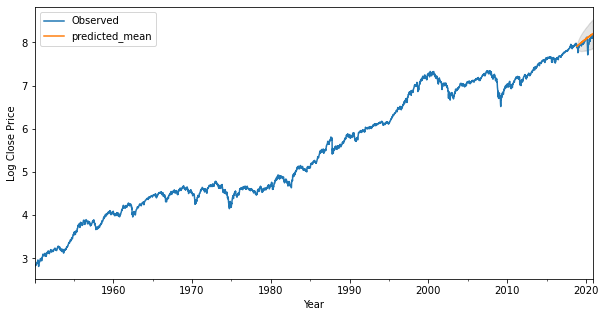

In [34]:
futureDF_forecast, next_periods_ci = forecast_with_sarimax(weekly_data.set_index("Date")['Log_Close'], 104, order=order,
                                                           seasonal_order=seasonal_order, offset = 0)

## Prophet (weekly)

In [168]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*10 + 1969 for i in range(5)]])
weekly_data_prophet = weekly_data.rename({"Date": "ds", "Log_Close": "y"}, axis =1)
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5, 1],
    'seasonality_prior_scale': [0.005,0.01, 0.1, 0.5, 1.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.85, 0.9, 0.95]
}

tuning_results = hyper_tune_prophet_model(weekly_data_prophet, cutoffs, param_grid)
tuning_results.to_csv("prophet_tuning_weekly.csv")

16:11:56 - cmdstanpy - INFO - Chain [1] start processing
16:11:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:11:57 - cmdstanpy - INFO - Chain [1] start processing
16:11:57 - cmdstanpy - INFO - Chain [1] done processing
16:11:58 - cmdstanpy - INFO - Chain [1] start processing
16:11:58 - cmdstanpy - INFO - Chain [1] done processing
16:11:58 - cmdstanpy - INFO - Chain [1] start processing
16:11:59 - cmdstanpy - INFO - Chain [1] done processing
16:11:59 - cmdstanpy - INFO - Chain [1] start processing
16:12:00 - cmdstanpy - INFO - Chain [1] done processing
16:12:00 - cmdstanpy - INFO - Chain [1] start processing
16:12:01 - cmdstanpy - INFO - Chain [1] done processing
16:12:03 - cmdstanpy - INFO - Chain [1] start processing
16:12:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:12:05 - cmdstanpy - INFO - Chain [1] start processing
16:12:06 - cmdstanpy - INFO - Chain [1] done processing
16:12:06 - cmdstanpy - INFO - Chain [1] start processing
16:12:06 - cmdstanpy - INFO - Chain [1] done processing
16:12:07 - cmdstanpy - INFO - Chain [1] start processing
16:12:07 - cmdstanpy - INFO - Chain [1] done processing
16:12:08 - cmdstanpy - INFO - Chain [1] start processing
16:12:08 - cmdstanpy - INFO - Chain [1] done processing
16:12:08 - cmdstanpy - INFO - Chain [1] start processing
16:12:09 - cmdstanpy - INFO - Chain [1] done processing
16:12:10 - cmdstanpy - INFO - Chain [1] start processing
16:12:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:12:11 - cmdstanpy - INFO - Chain [1] start processing
16:12:11 - cmdstanpy - INFO - Chain [1] done processing
16:12:12 - cmdstanpy - INFO - Chain [1] start processing
16:12:12 - cmdstanpy - INFO - Chain [1] done processing
16:12:13 - cmdstanpy - INFO - Chain [1] start processing
16:12:13 - cmdstanpy - INFO - Chain [1] done processing
16:12:13 - cmdstanpy - INFO - Chain [1] start processing
16:12:14 - cmdstanpy - INFO - Chain [1] done processing
16:12:15 - cmdstanpy - INFO - Chain [1] start processing
16:12:16 - cmdstanpy - INFO - Chain [1] done processing
16:12:16 - cmdstanpy - INFO - Chain [1] start processing
16:12:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:12:18 - cmdstanpy - INFO - Chain [1] start processing
16:12:18 - cmdstanpy - INFO - Chain [1] done processing
16:12:18 - cmdstanpy - INFO - Chain [1] start processing
16:12:19 - cmdstanpy - INFO - Chain [1] done processing
16:12:19 - cmdstanpy - INFO - Chain [1] start processing
16:12:19 - cmdstanpy - INFO - Chain [1] done processing
16:12:20 - cmdstanpy - INFO - Chain [1] start processing
16:12:20 - cmdstanpy - INFO - Chain [1] done processing
16:12:21 - cmdstanpy - INFO - Chain [1] start processing
16:12:22 - cmdstanpy - INFO - Chain [1] done processing
16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:24 - cmdstanpy - INFO - Chain [1] start processing
16:12:24 - cmdstanpy - INFO - Chain [1] done processing
16:12:25 - cmdstanpy - INFO - Chain [1] start processing
16:12:25 - cmdstanpy - INFO - Chain [1] done processing
16:12:26 - cmdstanpy - INFO - Chain [1] start processing
16:12:26 - cmdstanpy - INFO - Chain [1] done processing
16:12:27 - cmdstanpy - INFO - Chain [1] start processing
16:12:28 - cmdstanpy - INFO - Chain [1] done processing
16:12:29 - cmdstanpy - INFO - Chain [1] start processing
16:12:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:12:30 - cmdstanpy - INFO - Chain [1] start processing
16:12:31 - cmdstanpy - INFO - Chain [1] done processing
16:12:31 - cmdstanpy - INFO - Chain [1] start processing
16:12:31 - cmdstanpy - INFO - Chain [1] done processing
16:12:32 - cmdstanpy - INFO - Chain [1] start processing
16:12:32 - cmdstanpy - INFO - Chain [1] done processing
16:12:32 - cmdstanpy - INFO - Chain [1] start processing
16:12:33 - cmdstanpy - INFO - Chain [1] done processing
16:12:34 - cmdstanpy - INFO - Chain [1] start processing
16:12:34 - cmdstanpy - INFO - Chain [1] done processing
16:12:35 - cmdstanpy - INFO - Chain [1] start processing
16:12:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:12:36 - cmdstanpy - INFO - Chain [1] start processing
16:12:37 - cmdstanpy - INFO - Chain [1] done processing
16:12:37 - cmdstanpy - INFO - Chain [1] start processing
16:12:37 - cmdstanpy - INFO - Chain [1] done processing
16:12:38 - cmdstanpy - INFO - Chain [1] start processing
16:12:38 - cmdstanpy - INFO - Chain [1] done processing
16:12:39 - cmdstanpy - INFO - Chain [1] start processing
16:12:40 - cmdstanpy - INFO - Chain [1] done processing
16:12:40 - cmdstanpy - INFO - Chain [1] start processing
16:12:41 - cmdstanpy - INFO - Chain [1] done processing
16:12:42 - cmdstanpy - INFO - Chain [1] start processing
16:12:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:12:45 - cmdstanpy - INFO - Chain [1] start processing
16:12:45 - cmdstanpy - INFO - Chain [1] done processing
16:12:45 - cmdstanpy - INFO - Chain [1] start processing
16:12:46 - cmdstanpy - INFO - Chain [1] done processing
16:12:46 - cmdstanpy - INFO - Chain [1] start processing
16:12:47 - cmdstanpy - INFO - Chain [1] done processing
16:12:47 - cmdstanpy - INFO - Chain [1] start processing
16:12:48 - cmdstanpy - INFO - Chain [1] done processing
16:12:49 - cmdstanpy - INFO - Chain [1] start processing
16:12:50 - cmdstanpy - INFO - Chain [1] done processing
16:12:51 - cmdstanpy - INFO - Chain [1] start processing
16:12:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:12:53 - cmdstanpy - INFO - Chain [1] start processing
16:12:53 - cmdstanpy - INFO - Chain [1] done processing
16:12:54 - cmdstanpy - INFO - Chain [1] start processing
16:12:54 - cmdstanpy - INFO - Chain [1] done processing
16:12:55 - cmdstanpy - INFO - Chain [1] start processing
16:12:55 - cmdstanpy - INFO - Chain [1] done processing
16:12:56 - cmdstanpy - INFO - Chain [1] start processing
16:12:57 - cmdstanpy - INFO - Chain [1] done processing
16:12:58 - cmdstanpy - INFO - Chain [1] start processing
16:12:59 - cmdstanpy - INFO - Chain [1] done processing
16:13:00 - cmdstanpy - INFO - Chain [1] start processing
16:13:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:13:03 - cmdstanpy - INFO - Chain [1] start processing
16:13:04 - cmdstanpy - INFO - Chain [1] done processing
16:13:04 - cmdstanpy - INFO - Chain [1] start processing
16:13:04 - cmdstanpy - INFO - Chain [1] done processing
16:13:05 - cmdstanpy - INFO - Chain [1] start processing
16:13:05 - cmdstanpy - INFO - Chain [1] done processing
16:13:06 - cmdstanpy - INFO - Chain [1] start processing
16:13:07 - cmdstanpy - INFO - Chain [1] done processing
16:13:08 - cmdstanpy - INFO - Chain [1] start processing
16:13:08 - cmdstanpy - INFO - Chain [1] done processing
16:13:09 - cmdstanpy - INFO - Chain [1] start processing
16:13:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:13:11 - cmdstanpy - INFO - Chain [1] start processing
16:13:11 - cmdstanpy - INFO - Chain [1] done processing
16:13:12 - cmdstanpy - INFO - Chain [1] start processing
16:13:12 - cmdstanpy - INFO - Chain [1] done processing
16:13:13 - cmdstanpy - INFO - Chain [1] start processing
16:13:14 - cmdstanpy - INFO - Chain [1] done processing
16:13:14 - cmdstanpy - INFO - Chain [1] start processing
16:13:15 - cmdstanpy - INFO - Chain [1] done processing
16:13:16 - cmdstanpy - INFO - Chain [1] start processing
16:13:17 - cmdstanpy - INFO - Chain [1] done processing
16:13:17 - cmdstanpy - INFO - Chain [1] start processing
16:13:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:13:20 - cmdstanpy - INFO - Chain [1] start processing
16:13:20 - cmdstanpy - INFO - Chain [1] done processing
16:13:21 - cmdstanpy - INFO - Chain [1] start processing
16:13:21 - cmdstanpy - INFO - Chain [1] done processing
16:13:21 - cmdstanpy - INFO - Chain [1] start processing
16:13:22 - cmdstanpy - INFO - Chain [1] done processing
16:13:23 - cmdstanpy - INFO - Chain [1] start processing
16:13:23 - cmdstanpy - INFO - Chain [1] done processing
16:13:24 - cmdstanpy - INFO - Chain [1] start processing
16:13:25 - cmdstanpy - INFO - Chain [1] done processing
16:13:26 - cmdstanpy - INFO - Chain [1] start processing
16:13:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:13:28 - cmdstanpy - INFO - Chain [1] start processing
16:13:28 - cmdstanpy - INFO - Chain [1] done processing
16:13:29 - cmdstanpy - INFO - Chain [1] start processing
16:13:29 - cmdstanpy - INFO - Chain [1] done processing
16:13:30 - cmdstanpy - INFO - Chain [1] start processing
16:13:30 - cmdstanpy - INFO - Chain [1] done processing
16:13:31 - cmdstanpy - INFO - Chain [1] start processing
16:13:32 - cmdstanpy - INFO - Chain [1] done processing
16:13:32 - cmdstanpy - INFO - Chain [1] start processing
16:13:34 - cmdstanpy - INFO - Chain [1] done processing
16:13:35 - cmdstanpy - INFO - Chain [1] start processing
16:13:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:13:37 - cmdstanpy - INFO - Chain [1] start processing
16:13:37 - cmdstanpy - INFO - Chain [1] done processing
16:13:37 - cmdstanpy - INFO - Chain [1] start processing
16:13:38 - cmdstanpy - INFO - Chain [1] done processing
16:13:38 - cmdstanpy - INFO - Chain [1] start processing
16:13:39 - cmdstanpy - INFO - Chain [1] done processing
16:13:40 - cmdstanpy - INFO - Chain [1] start processing
16:13:40 - cmdstanpy - INFO - Chain [1] done processing
16:13:41 - cmdstanpy - INFO - Chain [1] start processing
16:13:42 - cmdstanpy - INFO - Chain [1] done processing
16:13:42 - cmdstanpy - INFO - Chain [1] start processing
16:13:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:13:44 - cmdstanpy - INFO - Chain [1] start processing
16:13:45 - cmdstanpy - INFO - Chain [1] done processing
16:13:45 - cmdstanpy - INFO - Chain [1] start processing
16:13:45 - cmdstanpy - INFO - Chain [1] done processing
16:13:46 - cmdstanpy - INFO - Chain [1] start processing
16:13:46 - cmdstanpy - INFO - Chain [1] done processing
16:13:47 - cmdstanpy - INFO - Chain [1] start processing
16:13:48 - cmdstanpy - INFO - Chain [1] done processing
16:13:48 - cmdstanpy - INFO - Chain [1] start processing
16:13:49 - cmdstanpy - INFO - Chain [1] done processing
16:13:50 - cmdstanpy - INFO - Chain [1] start processing
16:13:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:13:52 - cmdstanpy - INFO - Chain [1] start processing
16:13:52 - cmdstanpy - INFO - Chain [1] done processing
16:13:53 - cmdstanpy - INFO - Chain [1] start processing
16:13:53 - cmdstanpy - INFO - Chain [1] done processing
16:13:54 - cmdstanpy - INFO - Chain [1] start processing
16:13:54 - cmdstanpy - INFO - Chain [1] done processing
16:13:55 - cmdstanpy - INFO - Chain [1] start processing
16:13:56 - cmdstanpy - INFO - Chain [1] done processing
16:13:56 - cmdstanpy - INFO - Chain [1] start processing
16:13:57 - cmdstanpy - INFO - Chain [1] done processing
16:13:58 - cmdstanpy - INFO - Chain [1] start processing
16:13:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:13:59 - cmdstanpy - INFO - Chain [1] start processing
16:13:59 - cmdstanpy - INFO - Chain [1] done processing
16:14:00 - cmdstanpy - INFO - Chain [1] start processing
16:14:00 - cmdstanpy - INFO - Chain [1] done processing
16:14:00 - cmdstanpy - INFO - Chain [1] start processing
16:14:01 - cmdstanpy - INFO - Chain [1] done processing
16:14:01 - cmdstanpy - INFO - Chain [1] start processing
16:14:02 - cmdstanpy - INFO - Chain [1] done processing
16:14:03 - cmdstanpy - INFO - Chain [1] start processing
16:14:04 - cmdstanpy - INFO - Chain [1] done processing
16:14:05 - cmdstanpy - INFO - Chain [1] start processing
16:14:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:14:07 - cmdstanpy - INFO - Chain [1] start processing
16:14:07 - cmdstanpy - INFO - Chain [1] done processing
16:14:08 - cmdstanpy - INFO - Chain [1] start processing
16:14:08 - cmdstanpy - INFO - Chain [1] done processing
16:14:09 - cmdstanpy - INFO - Chain [1] start processing
16:14:09 - cmdstanpy - INFO - Chain [1] done processing
16:14:10 - cmdstanpy - INFO - Chain [1] start processing
16:14:11 - cmdstanpy - INFO - Chain [1] done processing
16:14:12 - cmdstanpy - INFO - Chain [1] start processing
16:14:13 - cmdstanpy - INFO - Chain [1] done processing
16:14:14 - cmdstanpy - INFO - Chain [1] start processing
16:14:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:14:16 - cmdstanpy - INFO - Chain [1] start processing
16:14:16 - cmdstanpy - INFO - Chain [1] done processing
16:14:17 - cmdstanpy - INFO - Chain [1] start processing
16:14:17 - cmdstanpy - INFO - Chain [1] done processing
16:14:17 - cmdstanpy - INFO - Chain [1] start processing
16:14:18 - cmdstanpy - INFO - Chain [1] done processing
16:14:19 - cmdstanpy - INFO - Chain [1] start processing
16:14:20 - cmdstanpy - INFO - Chain [1] done processing
16:14:21 - cmdstanpy - INFO - Chain [1] start processing
16:14:22 - cmdstanpy - INFO - Chain [1] done processing
16:14:23 - cmdstanpy - INFO - Chain [1] start processing
16:14:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:14:24 - cmdstanpy - INFO - Chain [1] start processing
16:14:24 - cmdstanpy - INFO - Chain [1] done processing
16:14:25 - cmdstanpy - INFO - Chain [1] start processing
16:14:25 - cmdstanpy - INFO - Chain [1] done processing
16:14:26 - cmdstanpy - INFO - Chain [1] start processing
16:14:27 - cmdstanpy - INFO - Chain [1] done processing
16:14:27 - cmdstanpy - INFO - Chain [1] start processing
16:14:28 - cmdstanpy - INFO - Chain [1] done processing
16:14:29 - cmdstanpy - INFO - Chain [1] start processing
16:14:31 - cmdstanpy - INFO - Chain [1] done processing
16:14:32 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:14:33 - cmdstanpy - INFO - Chain [1] start processing
16:14:33 - cmdstanpy - INFO - Chain [1] done processing
16:14:34 - cmdstanpy - INFO - Chain [1] start processing
16:14:34 - cmdstanpy - INFO - Chain [1] done processing
16:14:35 - cmdstanpy - INFO - Chain [1] start processing
16:14:35 - cmdstanpy - INFO - Chain [1] done processing
16:14:36 - cmdstanpy - INFO - Chain [1] start processing
16:14:37 - cmdstanpy - INFO - Chain [1] done processing
16:14:38 - cmdstanpy - INFO - Chain [1] start processing
16:14:39 - cmdstanpy - INFO - Chain [1] done processing
16:14:40 - cmdstanpy - INFO - Chain [1] start processing
16:14:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:14:43 - cmdstanpy - INFO - Chain [1] start processing
16:14:43 - cmdstanpy - INFO - Chain [1] done processing
16:14:43 - cmdstanpy - INFO - Chain [1] start processing
16:14:44 - cmdstanpy - INFO - Chain [1] done processing
16:14:44 - cmdstanpy - INFO - Chain [1] start processing
16:14:45 - cmdstanpy - INFO - Chain [1] done processing
16:14:46 - cmdstanpy - INFO - Chain [1] start processing
16:14:46 - cmdstanpy - INFO - Chain [1] done processing
16:14:47 - cmdstanpy - INFO - Chain [1] start processing
16:14:48 - cmdstanpy - INFO - Chain [1] done processing
16:14:49 - cmdstanpy - INFO - Chain [1] start processing
16:14:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:14:51 - cmdstanpy - INFO - Chain [1] start processing
16:14:52 - cmdstanpy - INFO - Chain [1] done processing
16:14:52 - cmdstanpy - INFO - Chain [1] start processing
16:14:53 - cmdstanpy - INFO - Chain [1] done processing
16:14:53 - cmdstanpy - INFO - Chain [1] start processing
16:14:54 - cmdstanpy - INFO - Chain [1] done processing
16:14:54 - cmdstanpy - INFO - Chain [1] start processing
16:14:55 - cmdstanpy - INFO - Chain [1] done processing
16:14:56 - cmdstanpy - INFO - Chain [1] start processing
16:14:57 - cmdstanpy - INFO - Chain [1] done processing
16:14:58 - cmdstanpy - INFO - Chain [1] start processing
16:15:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:15:00 - cmdstanpy - INFO - Chain [1] start processing
16:15:01 - cmdstanpy - INFO - Chain [1] done processing
16:15:01 - cmdstanpy - INFO - Chain [1] start processing
16:15:01 - cmdstanpy - INFO - Chain [1] done processing
16:15:02 - cmdstanpy - INFO - Chain [1] start processing
16:15:03 - cmdstanpy - INFO - Chain [1] done processing
16:15:03 - cmdstanpy - INFO - Chain [1] start processing
16:15:04 - cmdstanpy - INFO - Chain [1] done processing
16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:06 - cmdstanpy - INFO - Chain [1] done processing
16:15:07 - cmdstanpy - INFO - Chain [1] start processing
16:15:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:15:09 - cmdstanpy - INFO - Chain [1] start processing
16:15:09 - cmdstanpy - INFO - Chain [1] done processing
16:15:09 - cmdstanpy - INFO - Chain [1] start processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing
16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] done processing
16:15:12 - cmdstanpy - INFO - Chain [1] start processing
16:15:12 - cmdstanpy - INFO - Chain [1] done processing
16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:14 - cmdstanpy - INFO - Chain [1] done processing
16:15:15 - cmdstanpy - INFO - Chain [1] start processing
16:15:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:15:17 - cmdstanpy - INFO - Chain [1] start processing
16:15:17 - cmdstanpy - INFO - Chain [1] done processing
16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:18 - cmdstanpy - INFO - Chain [1] done processing
16:15:19 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing
16:15:20 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing
16:15:22 - cmdstanpy - INFO - Chain [1] start processing
16:15:23 - cmdstanpy - INFO - Chain [1] done processing
16:15:23 - cmdstanpy - INFO - Chain [1] start processing
16:15:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:15:26 - cmdstanpy - INFO - Chain [1] start processing
16:15:26 - cmdstanpy - INFO - Chain [1] done processing
16:15:27 - cmdstanpy - INFO - Chain [1] start processing
16:15:27 - cmdstanpy - INFO - Chain [1] done processing
16:15:27 - cmdstanpy - INFO - Chain [1] start processing
16:15:28 - cmdstanpy - INFO - Chain [1] done processing
16:15:28 - cmdstanpy - INFO - Chain [1] start processing
16:15:30 - cmdstanpy - INFO - Chain [1] done processing
16:15:31 - cmdstanpy - INFO - Chain [1] start processing
16:15:32 - cmdstanpy - INFO - Chain [1] done processing
16:15:33 - cmdstanpy - INFO - Chain [1] start processing
16:15:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:15:35 - cmdstanpy - INFO - Chain [1] start processing
16:15:35 - cmdstanpy - INFO - Chain [1] done processing
16:15:36 - cmdstanpy - INFO - Chain [1] start processing
16:15:36 - cmdstanpy - INFO - Chain [1] done processing
16:15:37 - cmdstanpy - INFO - Chain [1] start processing
16:15:37 - cmdstanpy - INFO - Chain [1] done processing
16:15:38 - cmdstanpy - INFO - Chain [1] start processing
16:15:38 - cmdstanpy - INFO - Chain [1] done processing
16:15:39 - cmdstanpy - INFO - Chain [1] start processing
16:15:40 - cmdstanpy - INFO - Chain [1] done processing
16:15:41 - cmdstanpy - INFO - Chain [1] start processing
16:15:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:15:42 - cmdstanpy - INFO - Chain [1] start processing
16:15:43 - cmdstanpy - INFO - Chain [1] done processing
16:15:43 - cmdstanpy - INFO - Chain [1] start processing
16:15:43 - cmdstanpy - INFO - Chain [1] done processing
16:15:44 - cmdstanpy - INFO - Chain [1] start processing
16:15:44 - cmdstanpy - INFO - Chain [1] done processing
16:15:45 - cmdstanpy - INFO - Chain [1] start processing
16:15:46 - cmdstanpy - INFO - Chain [1] done processing
16:15:47 - cmdstanpy - INFO - Chain [1] start processing
16:15:48 - cmdstanpy - INFO - Chain [1] done processing
16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1] done processing
16:15:53 - cmdstanpy - INFO - Chain [1] start processing
16:15:53 - cmdstanpy - INFO - Chain [1] done processing
16:15:54 - cmdstanpy - INFO - Chain [1] start processing
16:15:54 - cmdstanpy - INFO - Chain [1] done processing
16:15:55 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing
16:15:56 - cmdstanpy - INFO - Chain [1] start processing
16:15:57 - cmdstanpy - INFO - Chain [1] done processing
16:15:58 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:16:00 - cmdstanpy - INFO - Chain [1] done processing
16:16:00 - cmdstanpy - INFO - Chain [1] start processing
16:16:00 - cmdstanpy - INFO - Chain [1] done processing
16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:03 - cmdstanpy - INFO - Chain [1] done processing
16:16:04 - cmdstanpy - INFO - Chain [1] start processing
16:16:05 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:16:08 - cmdstanpy - INFO - Chain [1] start processing
16:16:08 - cmdstanpy - INFO - Chain [1] done processing
16:16:09 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing
16:16:10 - cmdstanpy - INFO - Chain [1] start processing
16:16:10 - cmdstanpy - INFO - Chain [1] done processing
16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:12 - cmdstanpy - INFO - Chain [1] done processing
16:16:12 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
16:16:17 - cmdstanpy - INFO - Chain [1] start processing
16:16:17 - cmdstanpy - INFO - Chain [1] done processing
16:16:18 - cmdstanpy - INFO - Chain [1] start processing
16:16:18 - cmdstanpy - INFO - Chain [1] done processing
16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:20 - cmdstanpy - INFO - Chain [1] done processing
16:16:20 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:23 - cmdstanpy - INFO - Chain [1] done processing
16:16:23 - cmdstanpy - INFO - Chain [1] start processing
16:16:23 - cmdstanpy - INFO - Chain [1] done processing
16:16:24 - cmdstanpy - INFO - Chain [1] start processing
16:16:24 - cmdstanpy - INFO - Chain [1] done processing
16:16:24 - cmdstanpy - INFO - Chain [1] start processing
16:16:25 - cmdstanpy - INFO - Chain [1] done processing
16:16:25 - cmdstanpy - INFO - Chain [1] start processing
16:16:26 - cmdstanpy - INFO - Chain [1] done processing
16:16:27 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:16:29 - cmdstanpy - INFO - Chain [1] start processing
16:16:29 - cmdstanpy - INFO - Chain [1] done processing
16:16:29 - cmdstanpy - INFO - Chain [1] start processing
16:16:30 - cmdstanpy - INFO - Chain [1] done processing
16:16:30 - cmdstanpy - INFO - Chain [1] start processing
16:16:31 - cmdstanpy - INFO - Chain [1] done processing
16:16:31 - cmdstanpy - INFO - Chain [1] start processing
16:16:32 - cmdstanpy - INFO - Chain [1] done processing
16:16:33 - cmdstanpy - INFO - Chain [1] start processing
16:16:33 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:16:36 - cmdstanpy - INFO - Chain [1] start processing
16:16:36 - cmdstanpy - INFO - Chain [1] done processing
16:16:36 - cmdstanpy - INFO - Chain [1] start processing
16:16:37 - cmdstanpy - INFO - Chain [1] done processing
16:16:37 - cmdstanpy - INFO - Chain [1] start processing
16:16:37 - cmdstanpy - INFO - Chain [1] done processing
16:16:38 - cmdstanpy - INFO - Chain [1] start processing
16:16:39 - cmdstanpy - INFO - Chain [1] done processing
16:16:39 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:43 - cmdstanpy - INFO - Chain [1] done processing
16:16:43 - cmdstanpy - INFO - Chain [1] start processing
16:16:43 - cmdstanpy - INFO - Chain [1] done processing
16:16:44 - cmdstanpy - INFO - Chain [1] start processing
16:16:44 - cmdstanpy - INFO - Chain [1] done processing
16:16:45 - cmdstanpy - INFO - Chain [1] start processing
16:16:46 - cmdstanpy - INFO - Chain [1] done processing
16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:16:48 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing
16:16:48 - cmdstanpy - INFO - Chain [1] start processing
16:16:49 - cmdstanpy - INFO - Chain [1] done processing
16:16:49 - cmdstanpy - INFO - Chain [1] start processing
16:16:49 - cmdstanpy - INFO - Chain [1] done processing
16:16:50 - cmdstanpy - INFO - Chain [1] start processing
16:16:50 - cmdstanpy - INFO - Chain [1] done processing
16:16:51 - cmdstanpy - INFO - Chain [1] start processing
16:16:52 - cmdstanpy - INFO - Chain [1] done processing
16:16:53 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:56 - cmdstanpy - INFO - Chain [1] start processing
16:16:57 - cmdstanpy - INFO - Chain [1] done processing
16:16:57 - cmdstanpy - INFO - Chain [1] start processing
16:16:58 - cmdstanpy - INFO - Chain [1] done processing
16:16:59 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing
16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing
16:17:02 - cmdstanpy - INFO - Chain [1] start processing
16:17:03 - cmdstanpy - INFO - Chain [1] done processing
16:17:03 - cmdstanpy - INFO - Chain [1] start processing
16:17:04 - cmdstanpy - INFO - Chain [1] done processing
16:17:04 - cmdstanpy - INFO - Chain [1] start processing
16:17:05 - cmdstanpy - INFO - Chain [1] done processing
16:17:05 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:09 - cmdstanpy - INFO - Chain [1] done processing
16:17:09 - cmdstanpy - INFO - Chain [1] start processing
16:17:10 - cmdstanpy - INFO - Chain [1] done processing
16:17:10 - cmdstanpy - INFO - Chain [1] start processing
16:17:12 - cmdstanpy - INFO - Chain [1] done processing
16:17:12 - cmdstanpy - INFO - Chain [1] start processing
16:17:14 - cmdstanpy - INFO - Chain [1] done processing
16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:17:17 - cmdstanpy - INFO - Chain [1] start processing
16:17:18 - cmdstanpy - INFO - Chain [1] done processing
16:17:18 - cmdstanpy - INFO - Chain [1] start processing
16:17:19 - cmdstanpy - INFO - Chain [1] done processing
16:17:19 - cmdstanpy - INFO - Chain [1] start processing
16:17:20 - cmdstanpy - INFO - Chain [1] done processing
16:17:21 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:24 - cmdstanpy - INFO - Chain [1] done processing
16:17:24 - cmdstanpy - INFO - Chain [1] start processing
16:17:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:17:26 - cmdstanpy - INFO - Chain [1] start processing
16:17:27 - cmdstanpy - INFO - Chain [1] done processing
16:17:27 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing
16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:29 - cmdstanpy - INFO - Chain [1] done processing
16:17:30 - cmdstanpy - INFO - Chain [1] start processing
16:17:31 - cmdstanpy - INFO - Chain [1] done processing
16:17:32 - cmdstanpy - INFO - Chain [1] start processing
16:17:33 - cmdstanpy - INFO - Chain [1] done processing
16:17:34 - cmdstanpy - INFO - Chain [1] start processing
16:17:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:17:36 - cmdstanpy - INFO - Chain [1] start processing
16:17:36 - cmdstanpy - INFO - Chain [1] done processing
16:17:36 - cmdstanpy - INFO - Chain [1] start processing
16:17:37 - cmdstanpy - INFO - Chain [1] done processing
16:17:38 - cmdstanpy - INFO - Chain [1] start processing
16:17:39 - cmdstanpy - INFO - Chain [1] done processing
16:17:39 - cmdstanpy - INFO - Chain [1] start processing
16:17:40 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:43 - cmdstanpy - INFO - Chain [1] done processing
16:17:43 - cmdstanpy - INFO - Chain [1] start processing
16:17:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:17:45 - cmdstanpy - INFO - Chain [1] start processing
16:17:46 - cmdstanpy - INFO - Chain [1] done processing
16:17:46 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:50 - cmdstanpy - INFO - Chain [1] done processing
16:17:50 - cmdstanpy - INFO - Chain [1] start processing
16:17:52 - cmdstanpy - INFO - Chain [1] done processing
16:17:52 - cmdstanpy - INFO - Chain [1] start processing
16:17:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:17:54 - cmdstanpy - INFO - Chain [1] start processing
16:17:55 - cmdstanpy - INFO - Chain [1] done processing
16:17:55 - cmdstanpy - INFO - Chain [1] start processing
16:17:56 - cmdstanpy - INFO - Chain [1] done processing
16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:17:57 - cmdstanpy - INFO - Chain [1] done processing
16:17:58 - cmdstanpy - INFO - Chain [1] start processing
16:17:59 - cmdstanpy - INFO - Chain [1] done processing
16:17:59 - cmdstanpy - INFO - Chain [1] start processing
16:18:01 - cmdstanpy - INFO - Chain [1] done processing
16:18:01 - cmdstanpy - INFO - Chain [1] start processing
16:18:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:18:03 - cmdstanpy - INFO - Chain [1] start processing
16:18:04 - cmdstanpy - INFO - Chain [1] done processing
16:18:04 - cmdstanpy - INFO - Chain [1] start processing
16:18:05 - cmdstanpy - INFO - Chain [1] done processing
16:18:05 - cmdstanpy - INFO - Chain [1] start processing
16:18:07 - cmdstanpy - INFO - Chain [1] done processing
16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:09 - cmdstanpy - INFO - Chain [1] done processing
16:18:10 - cmdstanpy - INFO - Chain [1] start processing
16:18:12 - cmdstanpy - INFO - Chain [1] done processing
16:18:13 - cmdstanpy - INFO - Chain [1] start processing
16:18:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:18:15 - cmdstanpy - INFO - Chain [1] start processing
16:18:16 - cmdstanpy - INFO - Chain [1] done processing
16:18:16 - cmdstanpy - INFO - Chain [1] start processing
16:18:17 - cmdstanpy - INFO - Chain [1] done processing
16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1] done processing
16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:21 - cmdstanpy - INFO - Chain [1] done processing
16:18:21 - cmdstanpy - INFO - Chain [1] start processing
16:18:23 - cmdstanpy - INFO - Chain [1] done processing
16:18:24 - cmdstanpy - INFO - Chain [1] start processing
16:18:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:18:26 - cmdstanpy - INFO - Chain [1] start processing
16:18:27 - cmdstanpy - INFO - Chain [1] done processing
16:18:28 - cmdstanpy - INFO - Chain [1] start processing
16:18:29 - cmdstanpy - INFO - Chain [1] done processing
16:18:29 - cmdstanpy - INFO - Chain [1] start processing
16:18:30 - cmdstanpy - INFO - Chain [1] done processing
16:18:31 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] done processing
16:18:33 - cmdstanpy - INFO - Chain [1] start processing
16:18:36 - cmdstanpy - INFO - Chain [1] done processing
16:18:37 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:18:40 - cmdstanpy - INFO - Chain [1] start processing
16:18:40 - cmdstanpy - INFO - Chain [1] done processing
16:18:41 - cmdstanpy - INFO - Chain [1] start processing
16:18:42 - cmdstanpy - INFO - Chain [1] done processing
16:18:42 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:46 - cmdstanpy - INFO - Chain [1] done processing
16:18:47 - cmdstanpy - INFO - Chain [1] start processing
16:18:48 - cmdstanpy - INFO - Chain [1] done processing
16:18:49 - cmdstanpy - INFO - Chain [1] start processing
16:18:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:18:52 - cmdstanpy - INFO - Chain [1] start processing
16:18:52 - cmdstanpy - INFO - Chain [1] done processing
16:18:52 - cmdstanpy - INFO - Chain [1] start processing
16:18:53 - cmdstanpy - INFO - Chain [1] done processing
16:18:54 - cmdstanpy - INFO - Chain [1] start processing
16:18:55 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:57 - cmdstanpy - INFO - Chain [1] start processing
16:18:58 - cmdstanpy - INFO - Chain [1] done processing
16:18:59 - cmdstanpy - INFO - Chain [1] start processing
16:19:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:19:01 - cmdstanpy - INFO - Chain [1] start processing
16:19:01 - cmdstanpy - INFO - Chain [1] done processing
16:19:02 - cmdstanpy - INFO - Chain [1] start processing
16:19:02 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:04 - cmdstanpy - INFO - Chain [1] done processing
16:19:04 - cmdstanpy - INFO - Chain [1] start processing
16:19:06 - cmdstanpy - INFO - Chain [1] done processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:07 - cmdstanpy - INFO - Chain [1] done processing
16:19:08 - cmdstanpy - INFO - Chain [1] start processing
16:19:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:19:10 - cmdstanpy - INFO - Chain [1] start processing
16:19:11 - cmdstanpy - INFO - Chain [1] done processing
16:19:11 - cmdstanpy - INFO - Chain [1] start processing
16:19:12 - cmdstanpy - INFO - Chain [1] done processing
16:19:12 - cmdstanpy - INFO - Chain [1] start processing
16:19:13 - cmdstanpy - INFO - Chain [1] done processing
16:19:14 - cmdstanpy - INFO - Chain [1] start processing
16:19:15 - cmdstanpy - INFO - Chain [1] done processing
16:19:16 - cmdstanpy - INFO - Chain [1] start processing
16:19:18 - cmdstanpy - INFO - Chain [1] done processing
16:19:19 - cmdstanpy - INFO - Chain [1] start processing
16:19:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:19:22 - cmdstanpy - INFO - Chain [1] start processing
16:19:22 - cmdstanpy - INFO - Chain [1] done processing
16:19:23 - cmdstanpy - INFO - Chain [1] start processing
16:19:23 - cmdstanpy - INFO - Chain [1] done processing
16:19:24 - cmdstanpy - INFO - Chain [1] start processing
16:19:25 - cmdstanpy - INFO - Chain [1] done processing
16:19:25 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] done processing
16:19:28 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:34 - cmdstanpy - INFO - Chain [1] done processing
16:19:34 - cmdstanpy - INFO - Chain [1] start processing
16:19:35 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:37 - cmdstanpy - INFO - Chain [1] done processing
16:19:37 - cmdstanpy - INFO - Chain [1] start processing
16:19:39 - cmdstanpy - INFO - Chain [1] done processing
16:19:39 - cmdstanpy - INFO - Chain [1] start processing
16:19:41 - cmdstanpy - INFO - Chain [1] done processing
16:19:42 - cmdstanpy - INFO - Chain [1] start processing
16:19:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:19:44 - cmdstanpy - INFO - Chain [1] start processing
16:19:45 - cmdstanpy - INFO - Chain [1] done processing
16:19:46 - cmdstanpy - INFO - Chain [1] start processing
16:19:46 - cmdstanpy - INFO - Chain [1] done processing
16:19:47 - cmdstanpy - INFO - Chain [1] start processing
16:19:48 - cmdstanpy - INFO - Chain [1] done processing
16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:50 - cmdstanpy - INFO - Chain [1] done processing
16:19:51 - cmdstanpy - INFO - Chain [1] start processing
16:19:53 - cmdstanpy - INFO - Chain [1] done processing
16:19:54 - cmdstanpy - INFO - Chain [1] start processing
16:19:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:19:56 - cmdstanpy - INFO - Chain [1] start processing
16:19:57 - cmdstanpy - INFO - Chain [1] done processing
16:19:57 - cmdstanpy - INFO - Chain [1] start processing
16:19:58 - cmdstanpy - INFO - Chain [1] done processing
16:19:59 - cmdstanpy - INFO - Chain [1] start processing
16:20:00 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:02 - cmdstanpy - INFO - Chain [1] done processing
16:20:03 - cmdstanpy - INFO - Chain [1] start processing
16:20:06 - cmdstanpy - INFO - Chain [1] done processing
16:20:06 - cmdstanpy - INFO - Chain [1] start processing
16:20:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:20:09 - cmdstanpy - INFO - Chain [1] start processing
16:20:10 - cmdstanpy - INFO - Chain [1] done processing
16:20:10 - cmdstanpy - INFO - Chain [1] start processing
16:20:11 - cmdstanpy - INFO - Chain [1] done processing
16:20:11 - cmdstanpy - INFO - Chain [1] start processing
16:20:13 - cmdstanpy - INFO - Chain [1] done processing
16:20:13 - cmdstanpy - INFO - Chain [1] start processing
16:20:15 - cmdstanpy - INFO - Chain [1] done processing
16:20:16 - cmdstanpy - INFO - Chain [1] start processing
16:20:18 - cmdstanpy - INFO - Chain [1] done processing
16:20:18 - cmdstanpy - INFO - Chain [1] start processing
16:20:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:20:21 - cmdstanpy - INFO - Chain [1] start processing
16:20:22 - cmdstanpy - INFO - Chain [1] done processing
16:20:22 - cmdstanpy - INFO - Chain [1] start processing
16:20:23 - cmdstanpy - INFO - Chain [1] done processing
16:20:24 - cmdstanpy - INFO - Chain [1] start processing
16:20:25 - cmdstanpy - INFO - Chain [1] done processing
16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:28 - cmdstanpy - INFO - Chain [1] done processing
16:20:28 - cmdstanpy - INFO - Chain [1] start processing
16:20:30 - cmdstanpy - INFO - Chain [1] done processing
16:20:31 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:34 - cmdstanpy - INFO - Chain [1] done processing
16:20:34 - cmdstanpy - INFO - Chain [1] start processing
16:20:35 - cmdstanpy - INFO - Chain [1] done processing
16:20:36 - cmdstanpy - INFO - Chain [1] start processing
16:20:37 - cmdstanpy - INFO - Chain [1] done processing
16:20:38 - cmdstanpy - INFO - Chain [1] start processing
16:20:39 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:42 - cmdstanpy - INFO - Chain [1] done processing
16:20:43 - cmdstanpy - INFO - Chain [1] start processing
16:20:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:20:46 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing
16:20:48 - cmdstanpy - INFO - Chain [1] start processing
16:20:49 - cmdstanpy - INFO - Chain [1] done processing
16:20:49 - cmdstanpy - INFO - Chain [1] start processing
16:20:51 - cmdstanpy - INFO - Chain [1] done processing
16:20:52 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing
16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:57 - cmdstanpy - INFO - Chain [1] done processing
16:20:57 - cmdstanpy - INFO - Chain [1] start processing
16:21:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:21:00 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:02 - cmdstanpy - INFO - Chain [1] done processing
16:21:03 - cmdstanpy - INFO - Chain [1] start processing
16:21:04 - cmdstanpy - INFO - Chain [1] done processing
16:21:05 - cmdstanpy - INFO - Chain [1] start processing
16:21:08 - cmdstanpy - INFO - Chain [1] done processing
16:21:08 - cmdstanpy - INFO - Chain [1] start processing
16:21:11 - cmdstanpy - INFO - Chain [1] done processing
16:21:12 - cmdstanpy - INFO - Chain [1] start processing
16:21:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:21:17 - cmdstanpy - INFO - Chain [1] start processing
16:21:18 - cmdstanpy - INFO - Chain [1] done processing
16:21:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:21:18 - cmdstanpy - INFO - Chain [1] start processing
16:21:19 - cmdstanpy - INFO - Chain [1] done processing
16:21:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:21 - cmdstanpy - INFO - Chain [1] done processing
16:21:22 - cmdstanpy - INFO - Chain [1] start processing
16:21:24 - cmdstanpy - INFO - Chain [1] done processing
16:21:24 - cmdstanpy - INFO - Chain [1] start processing
16:21:27 - cmdstanpy - INFO - Chain [1] done processing
16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:29 - cmdstanpy - INFO - Chain [1] done processing
16:21:30 - cmdstanpy - INFO - Chain [1] start processing
16:21:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:21:33 - cmdstanpy - INFO - Chain [1] start processing
16:21:34 - cmdstanpy - INFO - Chain [1] done processing
16:21:34 - cmdstanpy - INFO - Chain [1] start processing
16:21:35 - cmdstanpy - INFO - Chain [1] done processing
16:21:36 - cmdstanpy - INFO - Chain [1] start processing
16:21:37 - cmdstanpy - INFO - Chain [1] done processing
16:21:38 - cmdstanpy - INFO - Chain [1] start processing
16:21:39 - cmdstanpy - INFO - Chain [1] done processing
16:21:40 - cmdstanpy - INFO - Chain [1] start processing
16:21:42 - cmdstanpy - INFO - Chain [1] done processing
16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:21:47 - cmdstanpy - INFO - Chain [1] start processing
16:21:47 - cmdstanpy - INFO - Chain [1] done processing
16:21:48 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:52 - cmdstanpy - INFO - Chain [1] start processing
16:21:54 - cmdstanpy - INFO - Chain [1] done processing
16:21:55 - cmdstanpy - INFO - Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
16:21:58 - cmdstanpy - INFO - Chain [1] start processing
16:22:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:22:01 - cmdstanpy - INFO - Chain [1] start processing
16:22:02 - cmdstanpy - INFO - Chain [1] done processing
16:22:02 - cmdstanpy - INFO - Chain [1] start processing
16:22:04 - cmdstanpy - INFO - Chain [1] done processing
16:22:04 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing
16:22:06 - cmdstanpy - INFO - Chain [1] start processing
16:22:08 - cmdstanpy - INFO - Chain [1] done processing
16:22:09 - cmdstanpy - INFO - Chain [1] start processing
16:22:11 - cmdstanpy - INFO - Chain [1] done processing
16:22:12 - cmdstanpy - INFO - Chain [1] start processing
16:22:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:22:14 - cmdstanpy - INFO - Chain [1] start processing
16:22:15 - cmdstanpy - INFO - Chain [1] done processing
16:22:16 - cmdstanpy - INFO - Chain [1] start processing
16:22:17 - cmdstanpy - INFO - Chain [1] done processing
16:22:17 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing
16:22:20 - cmdstanpy - INFO - Chain [1] start processing
16:22:23 - cmdstanpy - INFO - Chain [1] done processing
16:22:24 - cmdstanpy - INFO - Chain [1] start processing
16:22:26 - cmdstanpy - INFO - Chain [1] done processing
16:22:27 - cmdstanpy - INFO - Chain [1] start processing
16:22:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:22:30 - cmdstanpy - INFO - Chain [1] start processing
16:22:31 - cmdstanpy - INFO - Chain [1] done processing
16:22:32 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing
16:22:34 - cmdstanpy - INFO - Chain [1] start processing
16:22:36 - cmdstanpy - INFO - Chain [1] done processing
16:22:36 - cmdstanpy - INFO - Chain [1] start processing
16:22:38 - cmdstanpy - INFO - Chain [1] done processing
16:22:39 - cmdstanpy - INFO - Chain [1] start processing
16:22:41 - cmdstanpy - INFO - Chain [1] done processing
16:22:42 - cmdstanpy - INFO - Chain [1] start processing
16:22:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:22:46 - cmdstanpy - INFO - Chain [1] start processing
16:22:47 - cmdstanpy - INFO - Chain [1] done processing
16:22:47 - cmdstanpy - INFO - Chain [1] start processing
16:22:48 - cmdstanpy - INFO - Chain [1] done processing
16:22:48 - cmdstanpy - INFO - Chain [1] start processing
16:22:49 - cmdstanpy - INFO - Chain [1] done processing
16:22:50 - cmdstanpy - INFO - Chain [1] start processing
16:22:51 - cmdstanpy - INFO - Chain [1] done processing
16:22:51 - cmdstanpy - INFO - Chain [1] start processing
16:22:53 - cmdstanpy - INFO - Chain [1] done processing
16:22:54 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:57 - cmdstanpy - INFO - Chain [1] start processing
16:22:58 - cmdstanpy - INFO - Chain [1] done processing
16:22:58 - cmdstanpy - INFO - Chain [1] start processing
16:22:59 - cmdstanpy - INFO - Chain [1] done processing
16:22:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:01 - cmdstanpy - INFO - Chain [1] done processing
16:23:01 - cmdstanpy - INFO - Chain [1] start processing
16:23:03 - cmdstanpy - INFO - Chain [1] done processing
16:23:03 - cmdstanpy - INFO - Chain [1] start processing
16:23:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:23:05 - cmdstanpy - INFO - Chain [1] start processing
16:23:05 - cmdstanpy - INFO - Chain [1] done processing
16:23:06 - cmdstanpy - INFO - Chain [1] start processing
16:23:06 - cmdstanpy - INFO - Chain [1] done processing
16:23:07 - cmdstanpy - INFO - Chain [1] start processing
16:23:08 - cmdstanpy - INFO - Chain [1] done processing
16:23:08 - cmdstanpy - INFO - Chain [1] start processing
16:23:11 - cmdstanpy - INFO - Chain [1] done processing
16:23:12 - cmdstanpy - INFO - Chain [1] start processing
16:23:13 - cmdstanpy - INFO - Chain [1] done processing
16:23:14 - cmdstanpy - INFO - Chain [1] start processing
16:23:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:23:16 - cmdstanpy - INFO - Chain [1] start processing
16:23:16 - cmdstanpy - INFO - Chain [1] done processing
16:23:17 - cmdstanpy - INFO - Chain [1] start processing
16:23:17 - cmdstanpy - INFO - Chain [1] done processing
16:23:18 - cmdstanpy - INFO - Chain [1] start processing
16:23:19 - cmdstanpy - INFO - Chain [1] done processing
16:23:20 - cmdstanpy - INFO - Chain [1] start processing
16:23:21 - cmdstanpy - INFO - Chain [1] done processing
16:23:22 - cmdstanpy - INFO - Chain [1] start processing
16:23:25 - cmdstanpy - INFO - Chain [1] done processing
16:23:25 - cmdstanpy - INFO - Chain [1] start processing
16:23:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:23:29 - cmdstanpy - INFO - Chain [1] start processing
16:23:30 - cmdstanpy - INFO - Chain [1] done processing
16:23:31 - cmdstanpy - INFO - Chain [1] start processing
16:23:32 - cmdstanpy - INFO - Chain [1] done processing
16:23:32 - cmdstanpy - INFO - Chain [1] start processing
16:23:34 - cmdstanpy - INFO - Chain [1] done processing
16:23:34 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing
16:23:36 - cmdstanpy - INFO - Chain [1] start processing
16:23:38 - cmdstanpy - INFO - Chain [1] done processing
16:23:39 - cmdstanpy - INFO - Chain [1] start processing
16:23:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:23:41 - cmdstanpy - INFO - Chain [1] start processing
16:23:42 - cmdstanpy - INFO - Chain [1] done processing
16:23:42 - cmdstanpy - INFO - Chain [1] start processing
16:23:43 - cmdstanpy - INFO - Chain [1] done processing
16:23:43 - cmdstanpy - INFO - Chain [1] start processing
16:23:44 - cmdstanpy - INFO - Chain [1] done processing
16:23:45 - cmdstanpy - INFO - Chain [1] start processing
16:23:46 - cmdstanpy - INFO - Chain [1] done processing
16:23:47 - cmdstanpy - INFO - Chain [1] start processing
16:23:48 - cmdstanpy - INFO - Chain [1] done processing
16:23:49 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:52 - cmdstanpy - INFO - Chain [1] start processing
16:23:52 - cmdstanpy - INFO - Chain [1] done processing
16:23:53 - cmdstanpy - INFO - Chain [1] start processing
16:23:54 - cmdstanpy - INFO - Chain [1] done processing
16:23:54 - cmdstanpy - INFO - Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:57 - cmdstanpy - INFO - Chain [1] done processing
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
16:24:02 - cmdstanpy - INFO - Chain [1] start processing
16:24:03 - cmdstanpy - INFO - Chain [1] done processing
16:24:04 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing
16:24:06 - cmdstanpy - INFO - Chain [1] start processing
16:24:08 - cmdstanpy - INFO - Chain [1] done processing
16:24:09 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:23 - cmdstanpy - INFO - Chain [1] start processing
16:25:24 - cmdstanpy - INFO - Chain [1] done processing
16:25:24 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:29 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing
16:25:32 - cmdstanpy - INFO - Chain [1] start processing
16:25:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:25:35 - cmdstanpy - INFO - Chain [1] start processing
16:25:35 - cmdstanpy - INFO - Chain [1] done processing
16:25:36 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing
16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:39 - cmdstanpy - INFO - Chain [1] done processing
16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:41 - cmdstanpy - INFO - Chain [1] done processing
16:25:41 - cmdstanpy - INFO - Chain [1] start processing
16:25:43 - cmdstanpy - INFO - Chain [1] done processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:25:48 - cmdstanpy - INFO - Chain [1] start processing
16:25:49 - cmdstanpy - INFO - Chain [1] done processing
16:25:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:51 - cmdstanpy - INFO - Chain [1] done processing
16:25:51 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing
16:25:53 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] done processing
16:25:57 - cmdstanpy - INFO - Chain [1] start processing
16:25:59 - cmdstanpy - INFO - Chain [1] done processing
16:26:00 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1] done processing
16:26:04 - cmdstanpy - INFO - Chain [1] start processing
16:26:06 - cmdstanpy - INFO - Chain [1] done processing
16:26:06 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:10 - cmdstanpy - INFO - Chain [1] done processing
16:26:11 - cmdstanpy - INFO - Chain [1] start processing
16:26:15 - cmdstanpy - INFO - Chain [1] done processing
16:26:16 - cmdstanpy - INFO - Chain [1] start processing
16:26:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:26:18 - cmdstanpy - INFO - Chain [1] start processing
16:26:19 - cmdstanpy - INFO - Chain [1] done processing
16:26:19 - cmdstanpy - INFO - Chain [1] start processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing
16:26:21 - cmdstanpy - INFO - Chain [1] start processing
16:26:22 - cmdstanpy - INFO - Chain [1] done processing
16:26:23 - cmdstanpy - INFO - Chain [1] start processing
16:26:25 - cmdstanpy - INFO - Chain [1] done processing
16:26:25 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:26:31 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] done processing
16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:33 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:35 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:37 - cmdstanpy - INFO - Chain [1] done processing
16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:40 - cmdstanpy - INFO - Chain [1] done processing
16:26:41 - cmdstanpy - INFO - Chain [1] start processing
16:26:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:26:45 - cmdstanpy - INFO - Chain [1] start processing
16:26:45 - cmdstanpy - INFO - Chain [1] done processing
16:26:46 - cmdstanpy - INFO - Chain [1] start processing
16:26:47 - cmdstanpy - INFO - Chain [1] done processing
16:26:47 - cmdstanpy - INFO - Chain [1] start processing
16:26:49 - cmdstanpy - INFO - Chain [1] done processing
16:26:49 - cmdstanpy - INFO - Chain [1] start processing
16:26:52 - cmdstanpy - INFO - Chain [1] done processing
16:26:53 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1] done processing
16:26:57 - cmdstanpy - INFO - Chain [1] start processing
16:27:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1] done processing
16:27:02 - cmdstanpy - INFO - Chain [1] start processing
16:27:03 - cmdstanpy - INFO - Chain [1] done processing
16:27:05 - cmdstanpy - INFO - Chain [1] start processing
16:27:07 - cmdstanpy - INFO - Chain [1] done processing
16:27:07 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1] done processing
16:27:10 - cmdstanpy - INFO - Chain [1] start processing
16:27:12 - cmdstanpy - INFO - Chain [1] done processing
16:27:13 - cmdstanpy - INFO - Chain [1] start processing
16:27:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:27:17 - cmdstanpy - INFO - Chain [1] start processing
16:27:17 - cmdstanpy - INFO - Chain [1] done processing
16:27:18 - cmdstanpy - INFO - Chain [1] start processing
16:27:19 - cmdstanpy - INFO - Chain [1] done processing
16:27:20 - cmdstanpy - INFO - Chain [1] start processing
16:27:21 - cmdstanpy - INFO - Chain [1] done processing
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:24 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:28 - cmdstanpy - INFO - Chain [1] done processing
16:27:29 - cmdstanpy - INFO - Chain [1] start processing
16:27:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:27:33 - cmdstanpy - INFO - Chain [1] start processing
16:27:34 - cmdstanpy - INFO - Chain [1] done processing
16:27:34 - cmdstanpy - INFO - Chain [1] start processing
16:27:35 - cmdstanpy - INFO - Chain [1] done processing
16:27:36 - cmdstanpy - INFO - Chain [1] start processing
16:27:37 - cmdstanpy - INFO - Chain [1] done processing
16:27:38 - cmdstanpy - INFO - Chain [1] start processing
16:27:39 - cmdstanpy - INFO - Chain [1] done processing
16:27:40 - cmdstanpy - INFO - Chain [1] start processing
16:27:42 - cmdstanpy - INFO - Chain [1] done processing
16:27:43 - cmdstanpy - INFO - Chain [1] start processing
16:27:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:27:46 - cmdstanpy - INFO - Chain [1] start processing
16:27:47 - cmdstanpy - INFO - Chain [1] done processing
16:27:48 - cmdstanpy - INFO - Chain [1] start processing
16:27:49 - cmdstanpy - INFO - Chain [1] done processing
16:27:49 - cmdstanpy - INFO - Chain [1] start processing
16:27:51 - cmdstanpy - INFO - Chain [1] done processing
16:27:52 - cmdstanpy - INFO - Chain [1] start processing
16:27:54 - cmdstanpy - INFO - Chain [1] done processing
16:27:54 - cmdstanpy - INFO - Chain [1] start processing
16:27:58 - cmdstanpy - INFO - Chain [1] done processing
16:27:59 - cmdstanpy - INFO - Chain [1] start processing
16:28:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:28:03 - cmdstanpy - INFO - Chain [1] start processing
16:28:04 - cmdstanpy - INFO - Chain [1] done processing
16:28:04 - cmdstanpy - INFO - Chain [1] start processing
16:28:06 - cmdstanpy - INFO - Chain [1] done processing
16:28:06 - cmdstanpy - INFO - Chain [1] start processing
16:28:08 - cmdstanpy - INFO - Chain [1] done processing
16:28:09 - cmdstanpy - INFO - Chain [1] start processing
16:28:12 - cmdstanpy - INFO - Chain [1] done processing
16:28:13 - cmdstanpy - INFO - Chain [1] start processing
16:28:15 - cmdstanpy - INFO - Chain [1] done processing
16:28:17 - cmdstanpy - INFO - Chain [1] start processing
16:28:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:28:20 - cmdstanpy - INFO - Chain [1] start processing
16:28:21 - cmdstanpy - INFO - Chain [1] done processing
16:28:22 - cmdstanpy - INFO - Chain [1] start processing
16:28:23 - cmdstanpy - INFO - Chain [1] done processing
16:28:24 - cmdstanpy - INFO - Chain [1] start processing
16:28:25 - cmdstanpy - INFO - Chain [1] done processing
16:28:25 - cmdstanpy - INFO - Chain [1] start processing
16:28:27 - cmdstanpy - INFO - Chain [1] done processing
16:28:28 - cmdstanpy - INFO - Chain [1] start processing
16:28:29 - cmdstanpy - INFO - Chain [1] done processing
16:28:30 - cmdstanpy - INFO - Chain [1] start processing
16:28:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:28:33 - cmdstanpy - INFO - Chain [1] start processing
16:28:34 - cmdstanpy - INFO - Chain [1] done processing
16:28:34 - cmdstanpy - INFO - Chain [1] start processing
16:28:35 - cmdstanpy - INFO - Chain [1] done processing
16:28:36 - cmdstanpy - INFO - Chain [1] start processing
16:28:37 - cmdstanpy - INFO - Chain [1] done processing
16:28:38 - cmdstanpy - INFO - Chain [1] start processing
16:28:39 - cmdstanpy - INFO - Chain [1] done processing
16:28:40 - cmdstanpy - INFO - Chain [1] start processing
16:28:42 - cmdstanpy - INFO - Chain [1] done processing
16:28:43 - cmdstanpy - INFO - Chain [1] start processing
16:28:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:28:47 - cmdstanpy - INFO - Chain [1] start processing
16:28:47 - cmdstanpy - INFO - Chain [1] done processing
16:28:48 - cmdstanpy - INFO - Chain [1] start processing
16:28:49 - cmdstanpy - INFO - Chain [1] done processing
16:28:49 - cmdstanpy - INFO - Chain [1] start processing
16:28:50 - cmdstanpy - INFO - Chain [1] done processing
16:28:51 - cmdstanpy - INFO - Chain [1] start processing
16:28:52 - cmdstanpy - INFO - Chain [1] done processing
16:28:53 - cmdstanpy - INFO - Chain [1] start processing
16:28:55 - cmdstanpy - INFO - Chain [1] done processing
16:28:56 - cmdstanpy - INFO - Chain [1] start processing
16:28:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:28:59 - cmdstanpy - INFO - Chain [1] start processing
16:28:59 - cmdstanpy - INFO - Chain [1] done processing
16:28:59 - cmdstanpy - INFO - Chain [1] start processing
16:29:00 - cmdstanpy - INFO - Chain [1] done processing
16:29:01 - cmdstanpy - INFO - Chain [1] start processing
16:29:02 - cmdstanpy - INFO - Chain [1] done processing
16:29:04 - cmdstanpy - INFO - Chain [1] start processing
16:29:05 - cmdstanpy - INFO - Chain [1] done processing
16:29:06 - cmdstanpy - INFO - Chain [1] start processing
16:29:07 - cmdstanpy - INFO - Chain [1] done processing
16:29:08 - cmdstanpy - INFO - Chain [1] start processing
16:29:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:29:10 - cmdstanpy - INFO - Chain [1] start processing
16:29:10 - cmdstanpy - INFO - Chain [1] done processing
16:29:11 - cmdstanpy - INFO - Chain [1] start processing
16:29:11 - cmdstanpy - INFO - Chain [1] done processing
16:29:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:13 - cmdstanpy - INFO - Chain [1] done processing
16:29:13 - cmdstanpy - INFO - Chain [1] start processing
16:29:15 - cmdstanpy - INFO - Chain [1] done processing
16:29:16 - cmdstanpy - INFO - Chain [1] start processing
16:29:17 - cmdstanpy - INFO - Chain [1] done processing
16:29:18 - cmdstanpy - INFO - Chain [1] start processing
16:29:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:29:21 - cmdstanpy - INFO - Chain [1] start processing
16:29:21 - cmdstanpy - INFO - Chain [1] done processing
16:29:22 - cmdstanpy - INFO - Chain [1] start processing
16:29:22 - cmdstanpy - INFO - Chain [1] done processing
16:29:23 - cmdstanpy - INFO - Chain [1] start processing
16:29:24 - cmdstanpy - INFO - Chain [1] done processing
16:29:24 - cmdstanpy - INFO - Chain [1] start processing
16:29:26 - cmdstanpy - INFO - Chain [1] done processing
16:29:27 - cmdstanpy - INFO - Chain [1] start processing
16:29:28 - cmdstanpy - INFO - Chain [1] done processing
16:29:29 - cmdstanpy - INFO - Chain [1] start processing
16:29:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:29:31 - cmdstanpy - INFO - Chain [1] start processing
16:29:32 - cmdstanpy - INFO - Chain [1] done processing
16:29:33 - cmdstanpy - INFO - Chain [1] start processing
16:29:34 - cmdstanpy - INFO - Chain [1] done processing
16:29:35 - cmdstanpy - INFO - Chain [1] start processing
16:29:37 - cmdstanpy - INFO - Chain [1] done processing
16:29:38 - cmdstanpy - INFO - Chain [1] start processing
16:29:40 - cmdstanpy - INFO - Chain [1] done processing
16:29:40 - cmdstanpy - INFO - Chain [1] start processing
16:29:43 - cmdstanpy - INFO - Chain [1] done processing
16:29:44 - cmdstanpy - INFO - Chain [1] start processing
16:29:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:29:47 - cmdstanpy - INFO - Chain [1] start processing
16:29:48 - cmdstanpy - INFO - Chain [1] done processing
16:29:49 - cmdstanpy - INFO - Chain [1] start processing
16:29:50 - cmdstanpy - INFO - Chain [1] done processing
16:29:51 - cmdstanpy - INFO - Chain [1] start processing
16:29:52 - cmdstanpy - INFO - Chain [1] done processing
16:29:53 - cmdstanpy - INFO - Chain [1] start processing
16:29:55 - cmdstanpy - INFO - Chain [1] done processing
16:29:56 - cmdstanpy - INFO - Chain [1] start processing
16:29:57 - cmdstanpy - INFO - Chain [1] done processing
16:29:58 - cmdstanpy - INFO - Chain [1] start processing
16:30:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:30:00 - cmdstanpy - INFO - Chain [1] start processing
16:30:01 - cmdstanpy - INFO - Chain [1] done processing
16:30:02 - cmdstanpy - INFO - Chain [1] start processing
16:30:03 - cmdstanpy - INFO - Chain [1] done processing
16:30:03 - cmdstanpy - INFO - Chain [1] start processing
16:30:04 - cmdstanpy - INFO - Chain [1] done processing
16:30:05 - cmdstanpy - INFO - Chain [1] start processing
16:30:07 - cmdstanpy - INFO - Chain [1] done processing
16:30:08 - cmdstanpy - INFO - Chain [1] start processing
16:30:10 - cmdstanpy - INFO - Chain [1] done processing
16:30:11 - cmdstanpy - INFO - Chain [1] start processing
16:30:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:30:13 - cmdstanpy - INFO - Chain [1] start processing
16:30:14 - cmdstanpy - INFO - Chain [1] done processing
16:30:14 - cmdstanpy - INFO - Chain [1] start processing
16:30:15 - cmdstanpy - INFO - Chain [1] done processing
16:30:15 - cmdstanpy - INFO - Chain [1] start processing
16:30:16 - cmdstanpy - INFO - Chain [1] done processing
16:30:17 - cmdstanpy - INFO - Chain [1] start processing
16:30:19 - cmdstanpy - INFO - Chain [1] done processing
16:30:20 - cmdstanpy - INFO - Chain [1] start processing
16:30:22 - cmdstanpy - INFO - Chain [1] done processing
16:30:23 - cmdstanpy - INFO - Chain [1] start processing
16:30:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:30:26 - cmdstanpy - INFO - Chain [1] start processing
16:30:27 - cmdstanpy - INFO - Chain [1] done processing
16:30:28 - cmdstanpy - INFO - Chain [1] start processing
16:30:29 - cmdstanpy - INFO - Chain [1] done processing
16:30:29 - cmdstanpy - INFO - Chain [1] start processing
16:30:31 - cmdstanpy - INFO - Chain [1] done processing
16:30:32 - cmdstanpy - INFO - Chain [1] start processing
16:30:34 - cmdstanpy - INFO - Chain [1] done processing
16:30:34 - cmdstanpy - INFO - Chain [1] start processing
16:30:37 - cmdstanpy - INFO - Chain [1] done processing
16:30:38 - cmdstanpy - INFO - Chain [1] start processing
16:30:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:30:42 - cmdstanpy - INFO - Chain [1] start processing
16:30:43 - cmdstanpy - INFO - Chain [1] done processing
16:30:43 - cmdstanpy - INFO - Chain [1] start processing
16:30:45 - cmdstanpy - INFO - Chain [1] done processing
16:30:45 - cmdstanpy - INFO - Chain [1] start processing
16:30:47 - cmdstanpy - INFO - Chain [1] done processing
16:30:47 - cmdstanpy - INFO - Chain [1] start processing
16:30:49 - cmdstanpy - INFO - Chain [1] done processing
16:30:50 - cmdstanpy - INFO - Chain [1] start processing
16:30:52 - cmdstanpy - INFO - Chain [1] done processing
16:30:53 - cmdstanpy - INFO - Chain [1] start processing
16:30:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:30:56 - cmdstanpy - INFO - Chain [1] start processing
16:30:56 - cmdstanpy - INFO - Chain [1] done processing
16:30:57 - cmdstanpy - INFO - Chain [1] start processing
16:30:58 - cmdstanpy - INFO - Chain [1] done processing
16:30:58 - cmdstanpy - INFO - Chain [1] start processing
16:30:59 - cmdstanpy - INFO - Chain [1] done processing
16:31:00 - cmdstanpy - INFO - Chain [1] start processing
16:31:01 - cmdstanpy - INFO - Chain [1] done processing
16:31:01 - cmdstanpy - INFO - Chain [1] start processing
16:31:03 - cmdstanpy - INFO - Chain [1] done processing
16:31:04 - cmdstanpy - INFO - Chain [1] start processing
16:31:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:31:06 - cmdstanpy - INFO - Chain [1] start processing
16:31:07 - cmdstanpy - INFO - Chain [1] done processing
16:31:07 - cmdstanpy - INFO - Chain [1] start processing
16:31:08 - cmdstanpy - INFO - Chain [1] done processing
16:31:09 - cmdstanpy - INFO - Chain [1] start processing
16:31:10 - cmdstanpy - INFO - Chain [1] done processing
16:31:10 - cmdstanpy - INFO - Chain [1] start processing
16:31:11 - cmdstanpy - INFO - Chain [1] done processing
16:31:12 - cmdstanpy - INFO - Chain [1] start processing
16:31:14 - cmdstanpy - INFO - Chain [1] done processing
16:31:14 - cmdstanpy - INFO - Chain [1] start processing
16:31:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:31:17 - cmdstanpy - INFO - Chain [1] start processing
16:31:17 - cmdstanpy - INFO - Chain [1] done processing
16:31:18 - cmdstanpy - INFO - Chain [1] start processing
16:31:18 - cmdstanpy - INFO - Chain [1] done processing
16:31:19 - cmdstanpy - INFO - Chain [1] start processing
16:31:20 - cmdstanpy - INFO - Chain [1] done processing
16:31:20 - cmdstanpy - INFO - Chain [1] start processing
16:31:21 - cmdstanpy - INFO - Chain [1] done processing
16:31:21 - cmdstanpy - INFO - Chain [1] start processing
16:31:24 - cmdstanpy - INFO - Chain [1] done processing
16:31:25 - cmdstanpy - INFO - Chain [1] start processing
16:31:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:31:26 - cmdstanpy - INFO - Chain [1] start processing
16:31:27 - cmdstanpy - INFO - Chain [1] done processing
16:31:27 - cmdstanpy - INFO - Chain [1] start processing
16:31:28 - cmdstanpy - INFO - Chain [1] done processing
16:31:28 - cmdstanpy - INFO - Chain [1] start processing
16:31:29 - cmdstanpy - INFO - Chain [1] done processing
16:31:29 - cmdstanpy - INFO - Chain [1] start processing
16:31:30 - cmdstanpy - INFO - Chain [1] done processing
16:31:30 - cmdstanpy - INFO - Chain [1] start processing
16:31:32 - cmdstanpy - INFO - Chain [1] done processing
16:31:33 - cmdstanpy - INFO - Chain [1] start processing
16:31:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:31:36 - cmdstanpy - INFO - Chain [1] start processing
16:31:37 - cmdstanpy - INFO - Chain [1] done processing
16:31:37 - cmdstanpy - INFO - Chain [1] start processing
16:31:38 - cmdstanpy - INFO - Chain [1] done processing
16:31:38 - cmdstanpy - INFO - Chain [1] start processing
16:31:39 - cmdstanpy - INFO - Chain [1] done processing
16:31:39 - cmdstanpy - INFO - Chain [1] start processing
16:31:40 - cmdstanpy - INFO - Chain [1] done processing
16:31:41 - cmdstanpy - INFO - Chain [1] start processing
16:31:42 - cmdstanpy - INFO - Chain [1] done processing
16:31:42 - cmdstanpy - INFO - Chain [1] start processing
16:31:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:31:45 - cmdstanpy - INFO - Chain [1] start processing
16:31:45 - cmdstanpy - INFO - Chain [1] done processing
16:31:46 - cmdstanpy - INFO - Chain [1] start processing
16:31:46 - cmdstanpy - INFO - Chain [1] done processing
16:31:47 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:49 - cmdstanpy - INFO - Chain [1] done processing
16:31:50 - cmdstanpy - INFO - Chain [1] start processing
16:31:52 - cmdstanpy - INFO - Chain [1] done processing
16:31:52 - cmdstanpy - INFO - Chain [1] start processing
16:31:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:31:55 - cmdstanpy - INFO - Chain [1] start processing
16:31:56 - cmdstanpy - INFO - Chain [1] done processing
16:31:56 - cmdstanpy - INFO - Chain [1] start processing
16:31:57 - cmdstanpy - INFO - Chain [1] done processing
16:31:57 - cmdstanpy - INFO - Chain [1] start processing
16:31:58 - cmdstanpy - INFO - Chain [1] done processing
16:31:59 - cmdstanpy - INFO - Chain [1] start processing
16:32:00 - cmdstanpy - INFO - Chain [1] done processing
16:32:01 - cmdstanpy - INFO - Chain [1] start processing
16:32:02 - cmdstanpy - INFO - Chain [1] done processing
16:32:03 - cmdstanpy - INFO - Chain [1] start processing
16:32:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:32:05 - cmdstanpy - INFO - Chain [1] start processing
16:32:05 - cmdstanpy - INFO - Chain [1] done processing
16:32:06 - cmdstanpy - INFO - Chain [1] start processing
16:32:06 - cmdstanpy - INFO - Chain [1] done processing
16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] done processing
16:32:08 - cmdstanpy - INFO - Chain [1] start processing
16:32:09 - cmdstanpy - INFO - Chain [1] done processing
16:32:09 - cmdstanpy - INFO - Chain [1] start processing
16:32:11 - cmdstanpy - INFO - Chain [1] done processing
16:32:11 - cmdstanpy - INFO - Chain [1] start processing
16:32:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:32:13 - cmdstanpy - INFO - Chain [1] start processing
16:32:13 - cmdstanpy - INFO - Chain [1] done processing
16:32:14 - cmdstanpy - INFO - Chain [1] start processing
16:32:14 - cmdstanpy - INFO - Chain [1] done processing
16:32:15 - cmdstanpy - INFO - Chain [1] start processing
16:32:15 - cmdstanpy - INFO - Chain [1] done processing
16:32:16 - cmdstanpy - INFO - Chain [1] start processing
16:32:17 - cmdstanpy - INFO - Chain [1] done processing
16:32:17 - cmdstanpy - INFO - Chain [1] start processing
16:32:18 - cmdstanpy - INFO - Chain [1] done processing
16:32:18 - cmdstanpy - INFO - Chain [1] start processing
16:32:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:32:20 - cmdstanpy - INFO - Chain [1] start processing
16:32:20 - cmdstanpy - INFO - Chain [1] done processing
16:32:21 - cmdstanpy - INFO - Chain [1] start processing
16:32:21 - cmdstanpy - INFO - Chain [1] done processing
16:32:22 - cmdstanpy - INFO - Chain [1] start processing
16:32:22 - cmdstanpy - INFO - Chain [1] done processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:24 - cmdstanpy - INFO - Chain [1] done processing
16:32:24 - cmdstanpy - INFO - Chain [1] start processing
16:32:25 - cmdstanpy - INFO - Chain [1] done processing
16:32:26 - cmdstanpy - INFO - Chain [1] start processing
16:32:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:32:27 - cmdstanpy - INFO - Chain [1] start processing
16:32:28 - cmdstanpy - INFO - Chain [1] done processing
16:32:28 - cmdstanpy - INFO - Chain [1] start processing
16:32:29 - cmdstanpy - INFO - Chain [1] done processing
16:32:29 - cmdstanpy - INFO - Chain [1] start processing
16:32:30 - cmdstanpy - INFO - Chain [1] done processing
16:32:30 - cmdstanpy - INFO - Chain [1] start processing
16:32:31 - cmdstanpy - INFO - Chain [1] done processing
16:32:32 - cmdstanpy - INFO - Chain [1] start processing
16:32:33 - cmdstanpy - INFO - Chain [1] done processing
16:32:34 - cmdstanpy - INFO - Chain [1] start processing
16:32:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:32:36 - cmdstanpy - INFO - Chain [1] start processing
16:32:36 - cmdstanpy - INFO - Chain [1] done processing
16:32:36 - cmdstanpy - INFO - Chain [1] start processing
16:32:37 - cmdstanpy - INFO - Chain [1] done processing
16:32:37 - cmdstanpy - INFO - Chain [1] start processing
16:32:38 - cmdstanpy - INFO - Chain [1] done processing
16:32:38 - cmdstanpy - INFO - Chain [1] start processing
16:32:40 - cmdstanpy - INFO - Chain [1] done processing
16:32:40 - cmdstanpy - INFO - Chain [1] start processing
16:32:42 - cmdstanpy - INFO - Chain [1] done processing
16:32:43 - cmdstanpy - INFO - Chain [1] start processing
16:32:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:32:44 - cmdstanpy - INFO - Chain [1] start processing
16:32:45 - cmdstanpy - INFO - Chain [1] done processing
16:32:45 - cmdstanpy - INFO - Chain [1] start processing
16:32:46 - cmdstanpy - INFO - Chain [1] done processing
16:32:46 - cmdstanpy - INFO - Chain [1] start processing
16:32:47 - cmdstanpy - INFO - Chain [1] done processing
16:32:47 - cmdstanpy - INFO - Chain [1] start processing
16:32:48 - cmdstanpy - INFO - Chain [1] done processing
16:32:49 - cmdstanpy - INFO - Chain [1] start processing
16:32:50 - cmdstanpy - INFO - Chain [1] done processing
16:32:51 - cmdstanpy - INFO - Chain [1] start processing
16:32:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:32:52 - cmdstanpy - INFO - Chain [1] start processing
16:32:53 - cmdstanpy - INFO - Chain [1] done processing
16:32:53 - cmdstanpy - INFO - Chain [1] start processing
16:32:53 - cmdstanpy - INFO - Chain [1] done processing
16:32:54 - cmdstanpy - INFO - Chain [1] start processing
16:32:54 - cmdstanpy - INFO - Chain [1] done processing
16:32:55 - cmdstanpy - INFO - Chain [1] start processing
16:32:56 - cmdstanpy - INFO - Chain [1] done processing
16:32:56 - cmdstanpy - INFO - Chain [1] start processing
16:32:57 - cmdstanpy - INFO - Chain [1] done processing
16:32:57 - cmdstanpy - INFO - Chain [1] start processing
16:32:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:32:59 - cmdstanpy - INFO - Chain [1] start processing
16:33:00 - cmdstanpy - INFO - Chain [1] done processing
16:33:00 - cmdstanpy - INFO - Chain [1] start processing
16:33:01 - cmdstanpy - INFO - Chain [1] done processing
16:33:01 - cmdstanpy - INFO - Chain [1] start processing
16:33:02 - cmdstanpy - INFO - Chain [1] done processing
16:33:02 - cmdstanpy - INFO - Chain [1] start processing
16:33:03 - cmdstanpy - INFO - Chain [1] done processing
16:33:04 - cmdstanpy - INFO - Chain [1] start processing
16:33:05 - cmdstanpy - INFO - Chain [1] done processing
16:33:06 - cmdstanpy - INFO - Chain [1] start processing
16:33:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:33:08 - cmdstanpy - INFO - Chain [1] start processing
16:33:08 - cmdstanpy - INFO - Chain [1] done processing
16:33:08 - cmdstanpy - INFO - Chain [1] start processing
16:33:09 - cmdstanpy - INFO - Chain [1] done processing
16:33:09 - cmdstanpy - INFO - Chain [1] start processing
16:33:10 - cmdstanpy - INFO - Chain [1] done processing
16:33:11 - cmdstanpy - INFO - Chain [1] start processing
16:33:12 - cmdstanpy - INFO - Chain [1] done processing
16:33:12 - cmdstanpy - INFO - Chain [1] start processing
16:33:13 - cmdstanpy - INFO - Chain [1] done processing
16:33:14 - cmdstanpy - INFO - Chain [1] start processing
16:33:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:33:16 - cmdstanpy - INFO - Chain [1] start processing
16:33:16 - cmdstanpy - INFO - Chain [1] done processing
16:33:16 - cmdstanpy - INFO - Chain [1] start processing
16:33:17 - cmdstanpy - INFO - Chain [1] done processing
16:33:17 - cmdstanpy - INFO - Chain [1] start processing
16:33:18 - cmdstanpy - INFO - Chain [1] done processing
16:33:18 - cmdstanpy - INFO - Chain [1] start processing
16:33:20 - cmdstanpy - INFO - Chain [1] done processing
16:33:20 - cmdstanpy - INFO - Chain [1] start processing
16:33:22 - cmdstanpy - INFO - Chain [1] done processing
16:33:22 - cmdstanpy - INFO - Chain [1] start processing
16:33:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:33:24 - cmdstanpy - INFO - Chain [1] start processing
16:33:24 - cmdstanpy - INFO - Chain [1] done processing
16:33:24 - cmdstanpy - INFO - Chain [1] start processing
16:33:25 - cmdstanpy - INFO - Chain [1] done processing
16:33:25 - cmdstanpy - INFO - Chain [1] start processing
16:33:26 - cmdstanpy - INFO - Chain [1] done processing
16:33:26 - cmdstanpy - INFO - Chain [1] start processing
16:33:27 - cmdstanpy - INFO - Chain [1] done processing
16:33:28 - cmdstanpy - INFO - Chain [1] start processing
16:33:29 - cmdstanpy - INFO - Chain [1] done processing
16:33:30 - cmdstanpy - INFO - Chain [1] start processing
16:33:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:33:32 - cmdstanpy - INFO - Chain [1] start processing
16:33:32 - cmdstanpy - INFO - Chain [1] done processing
16:33:33 - cmdstanpy - INFO - Chain [1] start processing
16:33:33 - cmdstanpy - INFO - Chain [1] done processing
16:33:34 - cmdstanpy - INFO - Chain [1] start processing
16:33:35 - cmdstanpy - INFO - Chain [1] done processing
16:33:36 - cmdstanpy - INFO - Chain [1] start processing
16:33:37 - cmdstanpy - INFO - Chain [1] done processing
16:33:38 - cmdstanpy - INFO - Chain [1] start processing
16:33:39 - cmdstanpy - INFO - Chain [1] done processing
16:33:40 - cmdstanpy - INFO - Chain [1] start processing
16:33:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:33:42 - cmdstanpy - INFO - Chain [1] start processing
16:33:42 - cmdstanpy - INFO - Chain [1] done processing
16:33:43 - cmdstanpy - INFO - Chain [1] start processing
16:33:44 - cmdstanpy - INFO - Chain [1] done processing
16:33:44 - cmdstanpy - INFO - Chain [1] start processing
16:33:45 - cmdstanpy - INFO - Chain [1] done processing
16:33:45 - cmdstanpy - INFO - Chain [1] start processing
16:33:47 - cmdstanpy - INFO - Chain [1] done processing
16:33:47 - cmdstanpy - INFO - Chain [1] start processing
16:33:49 - cmdstanpy - INFO - Chain [1] done processing
16:33:49 - cmdstanpy - INFO - Chain [1] start processing
16:33:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:33:52 - cmdstanpy - INFO - Chain [1] start processing
16:33:53 - cmdstanpy - INFO - Chain [1] done processing
16:33:53 - cmdstanpy - INFO - Chain [1] start processing
16:33:54 - cmdstanpy - INFO - Chain [1] done processing
16:33:54 - cmdstanpy - INFO - Chain [1] start processing
16:33:55 - cmdstanpy - INFO - Chain [1] done processing
16:33:56 - cmdstanpy - INFO - Chain [1] start processing
16:33:58 - cmdstanpy - INFO - Chain [1] done processing
16:33:58 - cmdstanpy - INFO - Chain [1] start processing
16:33:59 - cmdstanpy - INFO - Chain [1] done processing
16:33:59 - cmdstanpy - INFO - Chain [1] start processing
16:34:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:34:01 - cmdstanpy - INFO - Chain [1] start processing
16:34:01 - cmdstanpy - INFO - Chain [1] done processing
16:34:02 - cmdstanpy - INFO - Chain [1] start processing
16:34:02 - cmdstanpy - INFO - Chain [1] done processing
16:34:03 - cmdstanpy - INFO - Chain [1] start processing
16:34:03 - cmdstanpy - INFO - Chain [1] done processing
16:34:04 - cmdstanpy - INFO - Chain [1] start processing
16:34:05 - cmdstanpy - INFO - Chain [1] done processing
16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:07 - cmdstanpy - INFO - Chain [1] done processing
16:34:08 - cmdstanpy - INFO - Chain [1] start processing
16:34:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:34:12 - cmdstanpy - INFO - Chain [1] start processing
16:34:13 - cmdstanpy - INFO - Chain [1] done processing
16:34:14 - cmdstanpy - INFO - Chain [1] start processing
16:34:15 - cmdstanpy - INFO - Chain [1] done processing
16:34:15 - cmdstanpy - INFO - Chain [1] start processing
16:34:17 - cmdstanpy - INFO - Chain [1] done processing
16:34:17 - cmdstanpy - INFO - Chain [1] start processing
16:34:19 - cmdstanpy - INFO - Chain [1] done processing
16:34:19 - cmdstanpy - INFO - Chain [1] start processing
16:34:24 - cmdstanpy - INFO - Chain [1] done processing
16:34:25 - cmdstanpy - INFO - Chain [1] start processing
16:34:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:34:28 - cmdstanpy - INFO - Chain [1] start processing
16:34:29 - cmdstanpy - INFO - Chain [1] done processing
16:34:29 - cmdstanpy - INFO - Chain [1] start processing
16:34:30 - cmdstanpy - INFO - Chain [1] done processing
16:34:31 - cmdstanpy - INFO - Chain [1] start processing
16:34:32 - cmdstanpy - INFO - Chain [1] done processing
16:34:32 - cmdstanpy - INFO - Chain [1] start processing
16:34:34 - cmdstanpy - INFO - Chain [1] done processing
16:34:35 - cmdstanpy - INFO - Chain [1] start processing
16:34:37 - cmdstanpy - INFO - Chain [1] done processing
16:34:38 - cmdstanpy - INFO - Chain [1] start processing
16:34:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:34:40 - cmdstanpy - INFO - Chain [1] start processing
16:34:41 - cmdstanpy - INFO - Chain [1] done processing
16:34:41 - cmdstanpy - INFO - Chain [1] start processing
16:34:42 - cmdstanpy - INFO - Chain [1] done processing
16:34:43 - cmdstanpy - INFO - Chain [1] start processing
16:34:44 - cmdstanpy - INFO - Chain [1] done processing
16:34:44 - cmdstanpy - INFO - Chain [1] start processing
16:34:46 - cmdstanpy - INFO - Chain [1] done processing
16:34:46 - cmdstanpy - INFO - Chain [1] start processing
16:34:48 - cmdstanpy - INFO - Chain [1] done processing
16:34:49 - cmdstanpy - INFO - Chain [1] start processing
16:34:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:34:52 - cmdstanpy - INFO - Chain [1] start processing
16:34:52 - cmdstanpy - INFO - Chain [1] done processing
16:34:53 - cmdstanpy - INFO - Chain [1] start processing
16:34:53 - cmdstanpy - INFO - Chain [1] done processing
16:34:54 - cmdstanpy - INFO - Chain [1] start processing
16:34:55 - cmdstanpy - INFO - Chain [1] done processing
16:34:56 - cmdstanpy - INFO - Chain [1] start processing
16:34:57 - cmdstanpy - INFO - Chain [1] done processing
16:34:58 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing
16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:35:03 - cmdstanpy - INFO - Chain [1] start processing
16:35:04 - cmdstanpy - INFO - Chain [1] done processing
16:35:04 - cmdstanpy - INFO - Chain [1] start processing
16:35:05 - cmdstanpy - INFO - Chain [1] done processing
16:35:06 - cmdstanpy - INFO - Chain [1] start processing
16:35:08 - cmdstanpy - INFO - Chain [1] done processing
16:35:08 - cmdstanpy - INFO - Chain [1] start processing
16:35:10 - cmdstanpy - INFO - Chain [1] done processing
16:35:11 - cmdstanpy - INFO - Chain [1] start processing
16:35:13 - cmdstanpy - INFO - Chain [1] done processing
16:35:14 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:35:17 - cmdstanpy - INFO - Chain [1] start processing
16:35:18 - cmdstanpy - INFO - Chain [1] done processing
16:35:18 - cmdstanpy - INFO - Chain [1] start processing
16:35:19 - cmdstanpy - INFO - Chain [1] done processing
16:35:19 - cmdstanpy - INFO - Chain [1] start processing
16:35:21 - cmdstanpy - INFO - Chain [1] done processing
16:35:21 - cmdstanpy - INFO - Chain [1] start processing
16:35:23 - cmdstanpy - INFO - Chain [1] done processing
16:35:23 - cmdstanpy - INFO - Chain [1] start processing
16:35:24 - cmdstanpy - INFO - Chain [1] done processing
16:35:25 - cmdstanpy - INFO - Chain [1] start processing
16:35:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:35:27 - cmdstanpy - INFO - Chain [1] start processing
16:35:27 - cmdstanpy - INFO - Chain [1] done processing
16:35:27 - cmdstanpy - INFO - Chain [1] start processing
16:35:28 - cmdstanpy - INFO - Chain [1] done processing
16:35:28 - cmdstanpy - INFO - Chain [1] start processing
16:35:29 - cmdstanpy - INFO - Chain [1] done processing
16:35:30 - cmdstanpy - INFO - Chain [1] start processing
16:35:31 - cmdstanpy - INFO - Chain [1] done processing
16:35:31 - cmdstanpy - INFO - Chain [1] start processing
16:35:33 - cmdstanpy - INFO - Chain [1] done processing
16:35:33 - cmdstanpy - INFO - Chain [1] start processing
16:35:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:35:35 - cmdstanpy - INFO - Chain [1] start processing
16:35:35 - cmdstanpy - INFO - Chain [1] done processing
16:35:35 - cmdstanpy - INFO - Chain [1] start processing
16:35:36 - cmdstanpy - INFO - Chain [1] done processing
16:35:36 - cmdstanpy - INFO - Chain [1] start processing
16:35:37 - cmdstanpy - INFO - Chain [1] done processing
16:35:38 - cmdstanpy - INFO - Chain [1] start processing
16:35:38 - cmdstanpy - INFO - Chain [1] done processing
16:35:39 - cmdstanpy - INFO - Chain [1] start processing
16:35:40 - cmdstanpy - INFO - Chain [1] done processing
16:35:40 - cmdstanpy - INFO - Chain [1] start processing
16:35:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:35:42 - cmdstanpy - INFO - Chain [1] start processing
16:35:43 - cmdstanpy - INFO - Chain [1] done processing
16:35:43 - cmdstanpy - INFO - Chain [1] start processing
16:35:43 - cmdstanpy - INFO - Chain [1] done processing
16:35:44 - cmdstanpy - INFO - Chain [1] start processing
16:35:45 - cmdstanpy - INFO - Chain [1] done processing
16:35:45 - cmdstanpy - INFO - Chain [1] start processing
16:35:47 - cmdstanpy - INFO - Chain [1] done processing
16:35:47 - cmdstanpy - INFO - Chain [1] start processing
16:35:49 - cmdstanpy - INFO - Chain [1] done processing
16:35:49 - cmdstanpy - INFO - Chain [1] start processing
16:35:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:35:51 - cmdstanpy - INFO - Chain [1] start processing
16:35:52 - cmdstanpy - INFO - Chain [1] done processing
16:35:52 - cmdstanpy - INFO - Chain [1] start processing
16:35:53 - cmdstanpy - INFO - Chain [1] done processing
16:35:53 - cmdstanpy - INFO - Chain [1] start processing
16:35:54 - cmdstanpy - INFO - Chain [1] done processing
16:35:55 - cmdstanpy - INFO - Chain [1] start processing
16:35:56 - cmdstanpy - INFO - Chain [1] done processing
16:35:56 - cmdstanpy - INFO - Chain [1] start processing
16:35:57 - cmdstanpy - INFO - Chain [1] done processing
16:35:58 - cmdstanpy - INFO - Chain [1] start processing
16:36:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:36:00 - cmdstanpy - INFO - Chain [1] start processing
16:36:01 - cmdstanpy - INFO - Chain [1] done processing
16:36:02 - cmdstanpy - INFO - Chain [1] start processing
16:36:04 - cmdstanpy - INFO - Chain [1] done processing
16:36:04 - cmdstanpy - INFO - Chain [1] start processing
16:36:05 - cmdstanpy - INFO - Chain [1] done processing
16:36:06 - cmdstanpy - INFO - Chain [1] start processing
16:36:08 - cmdstanpy - INFO - Chain [1] done processing
16:36:08 - cmdstanpy - INFO - Chain [1] start processing
16:36:10 - cmdstanpy - INFO - Chain [1] done processing
16:36:11 - cmdstanpy - INFO - Chain [1] start processing
16:36:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:36:13 - cmdstanpy - INFO - Chain [1] start processing
16:36:14 - cmdstanpy - INFO - Chain [1] done processing
16:36:14 - cmdstanpy - INFO - Chain [1] start processing
16:36:15 - cmdstanpy - INFO - Chain [1] done processing
16:36:16 - cmdstanpy - INFO - Chain [1] start processing
16:36:17 - cmdstanpy - INFO - Chain [1] done processing
16:36:17 - cmdstanpy - INFO - Chain [1] start processing
16:36:19 - cmdstanpy - INFO - Chain [1] done processing
16:36:20 - cmdstanpy - INFO - Chain [1] start processing
16:36:21 - cmdstanpy - INFO - Chain [1] done processing
16:36:22 - cmdstanpy - INFO - Chain [1] start processing
16:36:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:36:26 - cmdstanpy - INFO - Chain [1] start processing
16:36:26 - cmdstanpy - INFO - Chain [1] done processing
16:36:27 - cmdstanpy - INFO - Chain [1] start processing
16:36:28 - cmdstanpy - INFO - Chain [1] done processing
16:36:28 - cmdstanpy - INFO - Chain [1] start processing
16:36:29 - cmdstanpy - INFO - Chain [1] done processing
16:36:30 - cmdstanpy - INFO - Chain [1] start processing
16:36:31 - cmdstanpy - INFO - Chain [1] done processing
16:36:32 - cmdstanpy - INFO - Chain [1] start processing
16:36:36 - cmdstanpy - INFO - Chain [1] done processing
16:36:38 - cmdstanpy - INFO - Chain [1] start processing
16:36:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:36:42 - cmdstanpy - INFO - Chain [1] start processing
16:36:43 - cmdstanpy - INFO - Chain [1] done processing
16:36:43 - cmdstanpy - INFO - Chain [1] start processing
16:36:45 - cmdstanpy - INFO - Chain [1] done processing
16:36:46 - cmdstanpy - INFO - Chain [1] start processing
16:36:48 - cmdstanpy - INFO - Chain [1] done processing
16:36:49 - cmdstanpy - INFO - Chain [1] start processing
16:36:50 - cmdstanpy - INFO - Chain [1] done processing
16:36:51 - cmdstanpy - INFO - Chain [1] start processing
16:36:53 - cmdstanpy - INFO - Chain [1] done processing
16:36:54 - cmdstanpy - INFO - Chain [1] start processing
16:36:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:36:59 - cmdstanpy - INFO - Chain [1] start processing
16:37:00 - cmdstanpy - INFO - Chain [1] done processing
16:37:01 - cmdstanpy - INFO - Chain [1] start processing
16:37:02 - cmdstanpy - INFO - Chain [1] done processing
16:37:03 - cmdstanpy - INFO - Chain [1] start processing
16:37:05 - cmdstanpy - INFO - Chain [1] done processing
16:37:07 - cmdstanpy - INFO - Chain [1] start processing
16:37:10 - cmdstanpy - INFO - Chain [1] done processing
16:37:12 - cmdstanpy - INFO - Chain [1] start processing
16:37:15 - cmdstanpy - INFO - Chain [1] done processing
16:37:16 - cmdstanpy - INFO - Chain [1] start processing
16:37:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:37:20 - cmdstanpy - INFO - Chain [1] start processing
16:37:20 - cmdstanpy - INFO - Chain [1] done processing
16:37:21 - cmdstanpy - INFO - Chain [1] start processing
16:37:22 - cmdstanpy - INFO - Chain [1] done processing
16:37:22 - cmdstanpy - INFO - Chain [1] start processing
16:37:24 - cmdstanpy - INFO - Chain [1] done processing
16:37:25 - cmdstanpy - INFO - Chain [1] start processing
16:37:27 - cmdstanpy - INFO - Chain [1] done processing
16:37:28 - cmdstanpy - INFO - Chain [1] start processing
16:37:30 - cmdstanpy - INFO - Chain [1] done processing
16:37:31 - cmdstanpy - INFO - Chain [1] start processing
16:37:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:37:35 - cmdstanpy - INFO - Chain [1] start processing
16:37:36 - cmdstanpy - INFO - Chain [1] done processing
16:37:37 - cmdstanpy - INFO - Chain [1] start processing
16:37:38 - cmdstanpy - INFO - Chain [1] done processing
16:37:38 - cmdstanpy - INFO - Chain [1] start processing
16:37:40 - cmdstanpy - INFO - Chain [1] done processing
16:37:41 - cmdstanpy - INFO - Chain [1] start processing
16:37:43 - cmdstanpy - INFO - Chain [1] done processing
16:37:44 - cmdstanpy - INFO - Chain [1] start processing
16:37:46 - cmdstanpy - INFO - Chain [1] done processing
16:37:47 - cmdstanpy - INFO - Chain [1] start processing
16:37:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:37:50 - cmdstanpy - INFO - Chain [1] start processing
16:37:51 - cmdstanpy - INFO - Chain [1] done processing
16:37:52 - cmdstanpy - INFO - Chain [1] start processing
16:37:54 - cmdstanpy - INFO - Chain [1] done processing
16:37:55 - cmdstanpy - INFO - Chain [1] start processing
16:37:56 - cmdstanpy - INFO - Chain [1] done processing
16:37:57 - cmdstanpy - INFO - Chain [1] start processing
16:38:00 - cmdstanpy - INFO - Chain [1] done processing
16:38:00 - cmdstanpy - INFO - Chain [1] start processing
16:38:04 - cmdstanpy - INFO - Chain [1] done processing
16:38:06 - cmdstanpy - INFO - Chain [1] start processing
16:38:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:38:11 - cmdstanpy - INFO - Chain [1] start processing
16:38:12 - cmdstanpy - INFO - Chain [1] done processing
16:38:13 - cmdstanpy - INFO - Chain [1] start processing
16:38:15 - cmdstanpy - INFO - Chain [1] done processing
16:38:16 - cmdstanpy - INFO - Chain [1] start processing
16:38:17 - cmdstanpy - INFO - Chain [1] done processing
16:38:19 - cmdstanpy - INFO - Chain [1] start processing
16:38:21 - cmdstanpy - INFO - Chain [1] done processing
16:38:22 - cmdstanpy - INFO - Chain [1] start processing
16:38:26 - cmdstanpy - INFO - Chain [1] done processing
16:38:28 - cmdstanpy - INFO - Chain [1] start processing
16:38:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:38:32 - cmdstanpy - INFO - Chain [1] start processing
16:38:34 - cmdstanpy - INFO - Chain [1] done processing
16:38:34 - cmdstanpy - INFO - Chain [1] start processing
16:38:36 - cmdstanpy - INFO - Chain [1] done processing
16:38:37 - cmdstanpy - INFO - Chain [1] start processing
16:38:39 - cmdstanpy - INFO - Chain [1] done processing
16:38:40 - cmdstanpy - INFO - Chain [1] start processing
16:38:43 - cmdstanpy - INFO - Chain [1] done processing
16:38:44 - cmdstanpy - INFO - Chain [1] start processing
16:38:46 - cmdstanpy - INFO - Chain [1] done processing
16:38:48 - cmdstanpy - INFO - Chain [1] start processing
16:38:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:38:52 - cmdstanpy - INFO - Chain [1] start processing
16:38:53 - cmdstanpy - INFO - Chain [1] done processing
16:38:54 - cmdstanpy - INFO - Chain [1] start processing
16:38:55 - cmdstanpy - INFO - Chain [1] done processing
16:38:56 - cmdstanpy - INFO - Chain [1] start processing
16:38:57 - cmdstanpy - INFO - Chain [1] done processing
16:38:58 - cmdstanpy - INFO - Chain [1] start processing
16:39:00 - cmdstanpy - INFO - Chain [1] done processing
16:39:01 - cmdstanpy - INFO - Chain [1] start processing
16:39:05 - cmdstanpy - INFO - Chain [1] done processing
16:39:06 - cmdstanpy - INFO - Chain [1] start processing
16:39:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:39:10 - cmdstanpy - INFO - Chain [1] start processing
16:39:11 - cmdstanpy - INFO - Chain [1] done processing
16:39:12 - cmdstanpy - INFO - Chain [1] start processing
16:39:14 - cmdstanpy - INFO - Chain [1] done processing
16:39:15 - cmdstanpy - INFO - Chain [1] start processing
16:39:17 - cmdstanpy - INFO - Chain [1] done processing
16:39:18 - cmdstanpy - INFO - Chain [1] start processing
16:39:20 - cmdstanpy - INFO - Chain [1] done processing
16:39:21 - cmdstanpy - INFO - Chain [1] start processing
16:39:24 - cmdstanpy - INFO - Chain [1] done processing
16:39:25 - cmdstanpy - INFO - Chain [1] start processing
16:39:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:39:28 - cmdstanpy - INFO - Chain [1] start processing
16:39:29 - cmdstanpy - INFO - Chain [1] done processing
16:39:30 - cmdstanpy - INFO - Chain [1] start processing
16:39:31 - cmdstanpy - INFO - Chain [1] done processing
16:39:32 - cmdstanpy - INFO - Chain [1] start processing
16:39:34 - cmdstanpy - INFO - Chain [1] done processing
16:39:35 - cmdstanpy - INFO - Chain [1] start processing
16:39:36 - cmdstanpy - INFO - Chain [1] done processing
16:39:37 - cmdstanpy - INFO - Chain [1] start processing
16:39:40 - cmdstanpy - INFO - Chain [1] done processing
16:39:41 - cmdstanpy - INFO - Chain [1] start processing
16:39:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:39:44 - cmdstanpy - INFO - Chain [1] start processing
16:39:44 - cmdstanpy - INFO - Chain [1] done processing
16:39:45 - cmdstanpy - INFO - Chain [1] start processing
16:39:46 - cmdstanpy - INFO - Chain [1] done processing
16:39:47 - cmdstanpy - INFO - Chain [1] start processing
16:39:48 - cmdstanpy - INFO - Chain [1] done processing
16:39:49 - cmdstanpy - INFO - Chain [1] start processing
16:39:51 - cmdstanpy - INFO - Chain [1] done processing
16:39:52 - cmdstanpy - INFO - Chain [1] start processing
16:39:54 - cmdstanpy - INFO - Chain [1] done processing
16:39:55 - cmdstanpy - INFO - Chain [1] start processing
16:39:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:39:58 - cmdstanpy - INFO - Chain [1] start processing
16:39:59 - cmdstanpy - INFO - Chain [1] done processing
16:40:00 - cmdstanpy - INFO - Chain [1] start processing
16:40:01 - cmdstanpy - INFO - Chain [1] done processing
16:40:01 - cmdstanpy - INFO - Chain [1] start processing
16:40:03 - cmdstanpy - INFO - Chain [1] done processing
16:40:04 - cmdstanpy - INFO - Chain [1] start processing
16:40:06 - cmdstanpy - INFO - Chain [1] done processing
16:40:07 - cmdstanpy - INFO - Chain [1] start processing
16:40:09 - cmdstanpy - INFO - Chain [1] done processing
16:40:10 - cmdstanpy - INFO - Chain [1] start processing
16:40:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:40:13 - cmdstanpy - INFO - Chain [1] start processing
16:40:14 - cmdstanpy - INFO - Chain [1] done processing
16:40:14 - cmdstanpy - INFO - Chain [1] start processing
16:40:15 - cmdstanpy - INFO - Chain [1] done processing
16:40:16 - cmdstanpy - INFO - Chain [1] start processing
16:40:17 - cmdstanpy - INFO - Chain [1] done processing
16:40:18 - cmdstanpy - INFO - Chain [1] start processing
16:40:20 - cmdstanpy - INFO - Chain [1] done processing
16:40:21 - cmdstanpy - INFO - Chain [1] start processing
16:40:23 - cmdstanpy - INFO - Chain [1] done processing
16:40:24 - cmdstanpy - INFO - Chain [1] start processing
16:40:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:40:27 - cmdstanpy - INFO - Chain [1] start processing
16:40:28 - cmdstanpy - INFO - Chain [1] done processing
16:40:29 - cmdstanpy - INFO - Chain [1] start processing
16:40:30 - cmdstanpy - INFO - Chain [1] done processing
16:40:31 - cmdstanpy - INFO - Chain [1] start processing
16:40:33 - cmdstanpy - INFO - Chain [1] done processing
16:40:33 - cmdstanpy - INFO - Chain [1] start processing
16:40:36 - cmdstanpy - INFO - Chain [1] done processing
16:40:36 - cmdstanpy - INFO - Chain [1] start processing
16:40:39 - cmdstanpy - INFO - Chain [1] done processing
16:40:40 - cmdstanpy - INFO - Chain [1] start processing
16:40:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:40:43 - cmdstanpy - INFO - Chain [1] start processing
16:40:44 - cmdstanpy - INFO - Chain [1] done processing
16:40:45 - cmdstanpy - INFO - Chain [1] start processing
16:40:46 - cmdstanpy - INFO - Chain [1] done processing
16:40:46 - cmdstanpy - INFO - Chain [1] start processing
16:40:48 - cmdstanpy - INFO - Chain [1] done processing
16:40:48 - cmdstanpy - INFO - Chain [1] start processing
16:40:51 - cmdstanpy - INFO - Chain [1] done processing
16:40:51 - cmdstanpy - INFO - Chain [1] start processing
16:40:54 - cmdstanpy - INFO - Chain [1] done processing
16:40:55 - cmdstanpy - INFO - Chain [1] start processing
16:40:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:40:59 - cmdstanpy - INFO - Chain [1] start processing
16:41:00 - cmdstanpy - INFO - Chain [1] done processing
16:41:00 - cmdstanpy - INFO - Chain [1] start processing
16:41:02 - cmdstanpy - INFO - Chain [1] done processing
16:41:02 - cmdstanpy - INFO - Chain [1] start processing
16:41:05 - cmdstanpy - INFO - Chain [1] done processing
16:41:06 - cmdstanpy - INFO - Chain [1] start processing
16:41:08 - cmdstanpy - INFO - Chain [1] done processing
16:41:09 - cmdstanpy - INFO - Chain [1] start processing
16:41:12 - cmdstanpy - INFO - Chain [1] done processing
16:41:13 - cmdstanpy - INFO - Chain [1] start processing
16:41:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:41:17 - cmdstanpy - INFO - Chain [1] start processing
16:41:18 - cmdstanpy - INFO - Chain [1] done processing
16:41:18 - cmdstanpy - INFO - Chain [1] start processing
16:41:20 - cmdstanpy - INFO - Chain [1] done processing
16:41:21 - cmdstanpy - INFO - Chain [1] start processing
16:41:22 - cmdstanpy - INFO - Chain [1] done processing
16:41:23 - cmdstanpy - INFO - Chain [1] start processing
16:41:25 - cmdstanpy - INFO - Chain [1] done processing
16:41:26 - cmdstanpy - INFO - Chain [1] start processing
16:41:28 - cmdstanpy - INFO - Chain [1] done processing
16:41:29 - cmdstanpy - INFO - Chain [1] start processing
16:41:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:41:32 - cmdstanpy - INFO - Chain [1] start processing
16:41:32 - cmdstanpy - INFO - Chain [1] done processing
16:41:33 - cmdstanpy - INFO - Chain [1] start processing
16:41:34 - cmdstanpy - INFO - Chain [1] done processing
16:41:35 - cmdstanpy - INFO - Chain [1] start processing
16:41:37 - cmdstanpy - INFO - Chain [1] done processing
16:41:38 - cmdstanpy - INFO - Chain [1] start processing
16:41:40 - cmdstanpy - INFO - Chain [1] done processing
16:41:41 - cmdstanpy - INFO - Chain [1] start processing
16:41:44 - cmdstanpy - INFO - Chain [1] done processing
16:41:45 - cmdstanpy - INFO - Chain [1] start processing
16:41:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:41:49 - cmdstanpy - INFO - Chain [1] start processing
16:41:50 - cmdstanpy - INFO - Chain [1] done processing
16:41:51 - cmdstanpy - INFO - Chain [1] start processing
16:41:52 - cmdstanpy - INFO - Chain [1] done processing
16:41:52 - cmdstanpy - INFO - Chain [1] start processing
16:41:54 - cmdstanpy - INFO - Chain [1] done processing
16:41:55 - cmdstanpy - INFO - Chain [1] start processing
16:41:57 - cmdstanpy - INFO - Chain [1] done processing
16:41:58 - cmdstanpy - INFO - Chain [1] start processing
16:42:00 - cmdstanpy - INFO - Chain [1] done processing
16:42:02 - cmdstanpy - INFO - Chain [1] start processing
16:42:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:42:07 - cmdstanpy - INFO - Chain [1] start processing
16:42:08 - cmdstanpy - INFO - Chain [1] done processing
16:42:09 - cmdstanpy - INFO - Chain [1] start processing
16:42:10 - cmdstanpy - INFO - Chain [1] done processing
16:42:11 - cmdstanpy - INFO - Chain [1] start processing
16:42:14 - cmdstanpy - INFO - Chain [1] done processing
16:42:16 - cmdstanpy - INFO - Chain [1] start processing
16:42:19 - cmdstanpy - INFO - Chain [1] done processing
16:42:21 - cmdstanpy - INFO - Chain [1] start processing
16:42:25 - cmdstanpy - INFO - Chain [1] done processing
16:42:27 - cmdstanpy - INFO - Chain [1] start processing
16:42:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:42:33 - cmdstanpy - INFO - Chain [1] start processing
16:42:34 - cmdstanpy - INFO - Chain [1] done processing
16:42:35 - cmdstanpy - INFO - Chain [1] start processing
16:42:37 - cmdstanpy - INFO - Chain [1] done processing
16:42:38 - cmdstanpy - INFO - Chain [1] start processing
16:42:40 - cmdstanpy - INFO - Chain [1] done processing
16:42:40 - cmdstanpy - INFO - Chain [1] start processing
16:42:42 - cmdstanpy - INFO - Chain [1] done processing
16:42:43 - cmdstanpy - INFO - Chain [1] start processing
16:42:46 - cmdstanpy - INFO - Chain [1] done processing
16:42:47 - cmdstanpy - INFO - Chain [1] start processing
16:42:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:42:50 - cmdstanpy - INFO - Chain [1] start processing
16:42:50 - cmdstanpy - INFO - Chain [1] done processing
16:42:51 - cmdstanpy - INFO - Chain [1] start processing
16:42:52 - cmdstanpy - INFO - Chain [1] done processing
16:42:52 - cmdstanpy - INFO - Chain [1] start processing
16:42:54 - cmdstanpy - INFO - Chain [1] done processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:57 - cmdstanpy - INFO - Chain [1] done processing
16:42:57 - cmdstanpy - INFO - Chain [1] start processing
16:42:59 - cmdstanpy - INFO - Chain [1] done processing
16:43:00 - cmdstanpy - INFO - Chain [1] start processing
16:43:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:43:03 - cmdstanpy - INFO - Chain [1] start processing
16:43:04 - cmdstanpy - INFO - Chain [1] done processing
16:43:05 - cmdstanpy - INFO - Chain [1] start processing
16:43:06 - cmdstanpy - INFO - Chain [1] done processing
16:43:06 - cmdstanpy - INFO - Chain [1] start processing
16:43:08 - cmdstanpy - INFO - Chain [1] done processing
16:43:08 - cmdstanpy - INFO - Chain [1] start processing
16:43:10 - cmdstanpy - INFO - Chain [1] done processing
16:43:10 - cmdstanpy - INFO - Chain [1] start processing
16:43:12 - cmdstanpy - INFO - Chain [1] done processing
16:43:13 - cmdstanpy - INFO - Chain [1] start processing
16:43:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:43:16 - cmdstanpy - INFO - Chain [1] start processing
16:43:17 - cmdstanpy - INFO - Chain [1] done processing
16:43:18 - cmdstanpy - INFO - Chain [1] start processing
16:43:19 - cmdstanpy - INFO - Chain [1] done processing
16:43:19 - cmdstanpy - INFO - Chain [1] start processing
16:43:21 - cmdstanpy - INFO - Chain [1] done processing
16:43:21 - cmdstanpy - INFO - Chain [1] start processing
16:43:23 - cmdstanpy - INFO - Chain [1] done processing
16:43:23 - cmdstanpy - INFO - Chain [1] start processing
16:43:25 - cmdstanpy - INFO - Chain [1] done processing
16:43:26 - cmdstanpy - INFO - Chain [1] start processing
16:43:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:43:28 - cmdstanpy - INFO - Chain [1] start processing
16:43:28 - cmdstanpy - INFO - Chain [1] done processing
16:43:28 - cmdstanpy - INFO - Chain [1] start processing
16:43:29 - cmdstanpy - INFO - Chain [1] done processing
16:43:30 - cmdstanpy - INFO - Chain [1] start processing
16:43:31 - cmdstanpy - INFO - Chain [1] done processing
16:43:31 - cmdstanpy - INFO - Chain [1] start processing
16:43:33 - cmdstanpy - INFO - Chain [1] done processing
16:43:33 - cmdstanpy - INFO - Chain [1] start processing
16:43:36 - cmdstanpy - INFO - Chain [1] done processing
16:43:36 - cmdstanpy - INFO - Chain [1] start processing
16:43:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:43:39 - cmdstanpy - INFO - Chain [1] start processing
16:43:39 - cmdstanpy - INFO - Chain [1] done processing
16:43:40 - cmdstanpy - INFO - Chain [1] start processing
16:43:41 - cmdstanpy - INFO - Chain [1] done processing
16:43:42 - cmdstanpy - INFO - Chain [1] start processing
16:43:43 - cmdstanpy - INFO - Chain [1] done processing
16:43:43 - cmdstanpy - INFO - Chain [1] start processing
16:43:45 - cmdstanpy - INFO - Chain [1] done processing
16:43:45 - cmdstanpy - INFO - Chain [1] start processing
16:43:47 - cmdstanpy - INFO - Chain [1] done processing
16:43:48 - cmdstanpy - INFO - Chain [1] start processing
16:43:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:43:50 - cmdstanpy - INFO - Chain [1] start processing
16:43:51 - cmdstanpy - INFO - Chain [1] done processing
16:43:52 - cmdstanpy - INFO - Chain [1] start processing
16:43:53 - cmdstanpy - INFO - Chain [1] done processing
16:43:54 - cmdstanpy - INFO - Chain [1] start processing
16:43:55 - cmdstanpy - INFO - Chain [1] done processing
16:43:56 - cmdstanpy - INFO - Chain [1] start processing
16:43:57 - cmdstanpy - INFO - Chain [1] done processing
16:43:58 - cmdstanpy - INFO - Chain [1] start processing
16:44:00 - cmdstanpy - INFO - Chain [1] done processing
16:44:02 - cmdstanpy - INFO - Chain [1] start processing
16:44:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:44:05 - cmdstanpy - INFO - Chain [1] start processing
16:44:06 - cmdstanpy - INFO - Chain [1] done processing
16:44:07 - cmdstanpy - INFO - Chain [1] start processing
16:44:08 - cmdstanpy - INFO - Chain [1] done processing
16:44:09 - cmdstanpy - INFO - Chain [1] start processing
16:44:11 - cmdstanpy - INFO - Chain [1] done processing
16:44:11 - cmdstanpy - INFO - Chain [1] start processing
16:44:13 - cmdstanpy - INFO - Chain [1] done processing
16:44:14 - cmdstanpy - INFO - Chain [1] start processing
16:44:17 - cmdstanpy - INFO - Chain [1] done processing
16:44:18 - cmdstanpy - INFO - Chain [1] start processing
16:44:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:44:21 - cmdstanpy - INFO - Chain [1] start processing
16:44:22 - cmdstanpy - INFO - Chain [1] done processing
16:44:22 - cmdstanpy - INFO - Chain [1] start processing
16:44:24 - cmdstanpy - INFO - Chain [1] done processing
16:44:25 - cmdstanpy - INFO - Chain [1] start processing
16:44:27 - cmdstanpy - INFO - Chain [1] done processing
16:44:27 - cmdstanpy - INFO - Chain [1] start processing
16:44:30 - cmdstanpy - INFO - Chain [1] done processing
16:44:31 - cmdstanpy - INFO - Chain [1] start processing
16:44:33 - cmdstanpy - INFO - Chain [1] done processing
16:44:34 - cmdstanpy - INFO - Chain [1] start processing
16:44:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:44:37 - cmdstanpy - INFO - Chain [1] start processing
16:44:38 - cmdstanpy - INFO - Chain [1] done processing
16:44:38 - cmdstanpy - INFO - Chain [1] start processing
16:44:39 - cmdstanpy - INFO - Chain [1] done processing
16:44:40 - cmdstanpy - INFO - Chain [1] start processing
16:44:41 - cmdstanpy - INFO - Chain [1] done processing
16:44:42 - cmdstanpy - INFO - Chain [1] start processing
16:44:43 - cmdstanpy - INFO - Chain [1] done processing
16:44:44 - cmdstanpy - INFO - Chain [1] start processing
16:44:46 - cmdstanpy - INFO - Chain [1] done processing
16:44:47 - cmdstanpy - INFO - Chain [1] start processing
16:44:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:44:50 - cmdstanpy - INFO - Chain [1] start processing
16:44:51 - cmdstanpy - INFO - Chain [1] done processing
16:44:52 - cmdstanpy - INFO - Chain [1] start processing
16:44:53 - cmdstanpy - INFO - Chain [1] done processing
16:44:53 - cmdstanpy - INFO - Chain [1] start processing
16:44:55 - cmdstanpy - INFO - Chain [1] done processing
16:44:55 - cmdstanpy - INFO - Chain [1] start processing
16:44:57 - cmdstanpy - INFO - Chain [1] done processing
16:44:58 - cmdstanpy - INFO - Chain [1] start processing
16:44:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:00 - cmdstanpy - INFO - Chain [1] start processing
16:45:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:45:02 - cmdstanpy - INFO - Chain [1] start processing
16:45:03 - cmdstanpy - INFO - Chain [1] done processing
16:45:03 - cmdstanpy - INFO - Chain [1] start processing
16:45:04 - cmdstanpy - INFO - Chain [1] done processing
16:45:04 - cmdstanpy - INFO - Chain [1] start processing
16:45:06 - cmdstanpy - INFO - Chain [1] done processing
16:45:06 - cmdstanpy - INFO - Chain [1] start processing
16:45:08 - cmdstanpy - INFO - Chain [1] done processing
16:45:09 - cmdstanpy - INFO - Chain [1] start processing
16:45:11 - cmdstanpy - INFO - Chain [1] done processing
16:45:13 - cmdstanpy - INFO - Chain [1] start processing
16:45:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:45:15 - cmdstanpy - INFO - Chain [1] start processing
16:45:16 - cmdstanpy - INFO - Chain [1] done processing
16:45:17 - cmdstanpy - INFO - Chain [1] start processing
16:45:18 - cmdstanpy - INFO - Chain [1] done processing
16:45:19 - cmdstanpy - INFO - Chain [1] start processing
16:45:20 - cmdstanpy - INFO - Chain [1] done processing
16:45:21 - cmdstanpy - INFO - Chain [1] start processing
16:45:23 - cmdstanpy - INFO - Chain [1] done processing
16:45:23 - cmdstanpy - INFO - Chain [1] start processing
16:45:25 - cmdstanpy - INFO - Chain [1] done processing
16:45:26 - cmdstanpy - INFO - Chain [1] start processing
16:45:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:45:28 - cmdstanpy - INFO - Chain [1] start processing
16:45:28 - cmdstanpy - INFO - Chain [1] done processing
16:45:29 - cmdstanpy - INFO - Chain [1] start processing
16:45:30 - cmdstanpy - INFO - Chain [1] done processing
16:45:30 - cmdstanpy - INFO - Chain [1] start processing
16:45:31 - cmdstanpy - INFO - Chain [1] done processing
16:45:32 - cmdstanpy - INFO - Chain [1] start processing
16:45:33 - cmdstanpy - INFO - Chain [1] done processing
16:45:34 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] done processing
16:45:38 - cmdstanpy - INFO - Chain [1] start processing
16:45:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:43 - cmdstanpy - INFO - Chain [1] start processing
16:45:43 - cmdstanpy - INFO - Chain [1] done processing
16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:45 - cmdstanpy - INFO - Chain [1] done processing
16:45:47 - cmdstanpy - INFO - Chain [1] start processing
16:45:49 - cmdstanpy - INFO - Chain [1] done processing
16:45:50 - cmdstanpy - INFO - Chain [1] start processing
16:45:53 - cmdstanpy - INFO - Chain [1] done processing
16:45:55 - cmdstanpy - INFO - Chain [1] start processing
16:45:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:46:00 - cmdstanpy - INFO - Chain [1] done processing
16:46:00 - cmdstanpy - INFO - Chain [1] start processing
16:46:01 - cmdstanpy - INFO - Chain [1] done processing
16:46:02 - cmdstanpy - INFO - Chain [1] start processing
16:46:03 - cmdstanpy - INFO - Chain [1] done processing
16:46:04 - cmdstanpy - INFO - Chain [1] start processing
16:46:06 - cmdstanpy - INFO - Chain [1] done processing
16:46:07 - cmdstanpy - INFO - Chain [1] start processing
16:46:09 - cmdstanpy - INFO - Chain [1] done processing
16:46:09 - cmdstanpy - INFO - Chain [1] start processing
16:46:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:46:12 - cmdstanpy - INFO - Chain [1] start processing
16:46:13 - cmdstanpy - INFO - Chain [1] done processing
16:46:14 - cmdstanpy - INFO - Chain [1] start processing
16:46:15 - cmdstanpy - INFO - Chain [1] done processing
16:46:15 - cmdstanpy - INFO - Chain [1] start processing
16:46:17 - cmdstanpy - INFO - Chain [1] done processing
16:46:18 - cmdstanpy - INFO - Chain [1] start processing
16:46:19 - cmdstanpy - INFO - Chain [1] done processing
16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:22 - cmdstanpy - INFO - Chain [1] done processing
16:46:23 - cmdstanpy - INFO - Chain [1] start processing
16:46:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:46:25 - cmdstanpy - INFO - Chain [1] start processing
16:46:26 - cmdstanpy - INFO - Chain [1] done processing
16:46:26 - cmdstanpy - INFO - Chain [1] start processing
16:46:27 - cmdstanpy - INFO - Chain [1] done processing
16:46:27 - cmdstanpy - INFO - Chain [1] start processing
16:46:28 - cmdstanpy - INFO - Chain [1] done processing
16:46:29 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:32 - cmdstanpy - INFO - Chain [1] done processing
16:46:33 - cmdstanpy - INFO - Chain [1] start processing
16:46:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:46:35 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:37 - cmdstanpy - INFO - Chain [1] start processing
16:46:38 - cmdstanpy - INFO - Chain [1] done processing
16:46:38 - cmdstanpy - INFO - Chain [1] start processing
16:46:40 - cmdstanpy - INFO - Chain [1] done processing
16:46:40 - cmdstanpy - INFO - Chain [1] start processing
16:46:43 - cmdstanpy - INFO - Chain [1] done processing
16:46:44 - cmdstanpy - INFO - Chain [1] start processing
16:46:46 - cmdstanpy - INFO - Chain [1] done processing
16:46:47 - cmdstanpy - INFO - Chain [1] start processing
16:46:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:51 - cmdstanpy - INFO - Chain [1] done processing
16:46:52 - cmdstanpy - INFO - Chain [1] start processing
16:46:53 - cmdstanpy - INFO - Chain [1] done processing
16:46:54 - cmdstanpy - INFO - Chain [1] start processing
16:46:55 - cmdstanpy - INFO - Chain [1] done processing
16:46:56 - cmdstanpy - INFO - Chain [1] start processing
16:46:58 - cmdstanpy - INFO - Chain [1] done processing
16:46:59 - cmdstanpy - INFO - Chain [1] start processing
16:47:01 - cmdstanpy - INFO - Chain [1] done processing
16:47:03 - cmdstanpy - INFO - Chain [1] start processing
16:47:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:09 - cmdstanpy - INFO - Chain [1] done processing
16:47:09 - cmdstanpy - INFO - Chain [1] start processing
16:47:10 - cmdstanpy - INFO - Chain [1] done processing
16:47:11 - cmdstanpy - INFO - Chain [1] start processing
16:47:12 - cmdstanpy - INFO - Chain [1] done processing
16:47:12 - cmdstanpy - INFO - Chain [1] start processing
16:47:15 - cmdstanpy - INFO - Chain [1] done processing
16:47:16 - cmdstanpy - INFO - Chain [1] start processing
16:47:17 - cmdstanpy - INFO - Chain [1] done processing
16:47:19 - cmdstanpy - INFO - Chain [1] start processing
16:47:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:47:22 - cmdstanpy - INFO - Chain [1] start processing
16:47:23 - cmdstanpy - INFO - Chain [1] done processing
16:47:24 - cmdstanpy - INFO - Chain [1] start processing
16:47:25 - cmdstanpy - INFO - Chain [1] done processing
16:47:25 - cmdstanpy - INFO - Chain [1] start processing
16:47:27 - cmdstanpy - INFO - Chain [1] done processing
16:47:27 - cmdstanpy - INFO - Chain [1] start processing
16:47:29 - cmdstanpy - INFO - Chain [1] done processing
16:47:30 - cmdstanpy - INFO - Chain [1] start processing
16:47:32 - cmdstanpy - INFO - Chain [1] done processing
16:47:33 - cmdstanpy - INFO - Chain [1] start processing
16:47:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:47:36 - cmdstanpy - INFO - Chain [1] start processing
16:47:37 - cmdstanpy - INFO - Chain [1] done processing
16:47:37 - cmdstanpy - INFO - Chain [1] start processing
16:47:39 - cmdstanpy - INFO - Chain [1] done processing
16:47:39 - cmdstanpy - INFO - Chain [1] start processing
16:47:41 - cmdstanpy - INFO - Chain [1] done processing
16:47:41 - cmdstanpy - INFO - Chain [1] start processing
16:47:43 - cmdstanpy - INFO - Chain [1] done processing
16:47:44 - cmdstanpy - INFO - Chain [1] start processing
16:47:46 - cmdstanpy - INFO - Chain [1] done processing
16:47:47 - cmdstanpy - INFO - Chain [1] start processing
16:47:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:47:49 - cmdstanpy - INFO - Chain [1] start processing
16:47:49 - cmdstanpy - INFO - Chain [1] done processing
16:47:49 - cmdstanpy - INFO - Chain [1] start processing
16:47:50 - cmdstanpy - INFO - Chain [1] done processing
16:47:50 - cmdstanpy - INFO - Chain [1] start processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing
16:47:52 - cmdstanpy - INFO - Chain [1] start processing
16:47:53 - cmdstanpy - INFO - Chain [1] done processing
16:47:53 - cmdstanpy - INFO - Chain [1] start processing
16:47:55 - cmdstanpy - INFO - Chain [1] done processing
16:47:55 - cmdstanpy - INFO - Chain [1] start processing
16:47:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:47:57 - cmdstanpy - INFO - Chain [1] start processing
16:47:58 - cmdstanpy - INFO - Chain [1] done processing
16:47:58 - cmdstanpy - INFO - Chain [1] start processing
16:47:59 - cmdstanpy - INFO - Chain [1] done processing
16:48:00 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:02 - cmdstanpy - INFO - Chain [1] done processing
16:48:03 - cmdstanpy - INFO - Chain [1] start processing
16:48:05 - cmdstanpy - INFO - Chain [1] done processing
16:48:05 - cmdstanpy - INFO - Chain [1] start processing
16:48:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:48:07 - cmdstanpy - INFO - Chain [1] start processing
16:48:08 - cmdstanpy - INFO - Chain [1] done processing
16:48:08 - cmdstanpy - INFO - Chain [1] start processing
16:48:10 - cmdstanpy - INFO - Chain [1] done processing
16:48:10 - cmdstanpy - INFO - Chain [1] start processing
16:48:12 - cmdstanpy - INFO - Chain [1] done processing
16:48:13 - cmdstanpy - INFO - Chain [1] start processing
16:48:15 - cmdstanpy - INFO - Chain [1] done processing
16:48:16 - cmdstanpy - INFO - Chain [1] start processing
16:48:17 - cmdstanpy - INFO - Chain [1] done processing
16:48:18 - cmdstanpy - INFO - Chain [1] start processing
16:48:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:48:22 - cmdstanpy - INFO - Chain [1] start processing
16:48:22 - cmdstanpy - INFO - Chain [1] done processing
16:48:23 - cmdstanpy - INFO - Chain [1] start processing
16:48:24 - cmdstanpy - INFO - Chain [1] done processing
16:48:24 - cmdstanpy - INFO - Chain [1] start processing
16:48:26 - cmdstanpy - INFO - Chain [1] done processing
16:48:27 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:30 - cmdstanpy - INFO - Chain [1] start processing
16:48:32 - cmdstanpy - INFO - Chain [1] done processing
16:48:34 - cmdstanpy - INFO - Chain [1] start processing
16:48:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:48:38 - cmdstanpy - INFO - Chain [1] start processing
16:48:39 - cmdstanpy - INFO - Chain [1] done processing
16:48:40 - cmdstanpy - INFO - Chain [1] start processing
16:48:42 - cmdstanpy - INFO - Chain [1] done processing
16:48:42 - cmdstanpy - INFO - Chain [1] start processing
16:48:44 - cmdstanpy - INFO - Chain [1] done processing
16:48:45 - cmdstanpy - INFO - Chain [1] start processing
16:48:47 - cmdstanpy - INFO - Chain [1] done processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:51 - cmdstanpy - INFO - Chain [1] done processing
16:48:51 - cmdstanpy - INFO - Chain [1] start processing
16:48:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:48:55 - cmdstanpy - INFO - Chain [1] start processing
16:48:56 - cmdstanpy - INFO - Chain [1] done processing
16:48:56 - cmdstanpy - INFO - Chain [1] start processing
16:48:57 - cmdstanpy - INFO - Chain [1] done processing
16:48:58 - cmdstanpy - INFO - Chain [1] start processing
16:48:59 - cmdstanpy - INFO - Chain [1] done processing
16:49:00 - cmdstanpy - INFO - Chain [1] start processing
16:49:02 - cmdstanpy - INFO - Chain [1] done processing
16:49:03 - cmdstanpy - INFO - Chain [1] start processing
16:49:05 - cmdstanpy - INFO - Chain [1] done processing
16:49:06 - cmdstanpy - INFO - Chain [1] start processing
16:49:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:49:09 - cmdstanpy - INFO - Chain [1] start processing
16:49:10 - cmdstanpy - INFO - Chain [1] done processing
16:49:10 - cmdstanpy - INFO - Chain [1] start processing
16:49:11 - cmdstanpy - INFO - Chain [1] done processing
16:49:12 - cmdstanpy - INFO - Chain [1] start processing
16:49:13 - cmdstanpy - INFO - Chain [1] done processing
16:49:14 - cmdstanpy - INFO - Chain [1] start processing
16:49:16 - cmdstanpy - INFO - Chain [1] done processing
16:49:16 - cmdstanpy - INFO - Chain [1] start processing
16:49:18 - cmdstanpy - INFO - Chain [1] done processing
16:49:19 - cmdstanpy - INFO - Chain [1] start processing
16:49:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:49:21 - cmdstanpy - INFO - Chain [1] start processing
16:49:21 - cmdstanpy - INFO - Chain [1] done processing
16:49:22 - cmdstanpy - INFO - Chain [1] start processing
16:49:23 - cmdstanpy - INFO - Chain [1] done processing
16:49:23 - cmdstanpy - INFO - Chain [1] start processing
16:49:24 - cmdstanpy - INFO - Chain [1] done processing
16:49:25 - cmdstanpy - INFO - Chain [1] start processing
16:49:26 - cmdstanpy - INFO - Chain [1] done processing
16:49:27 - cmdstanpy - INFO - Chain [1] start processing
16:49:28 - cmdstanpy - INFO - Chain [1] done processing
16:49:29 - cmdstanpy - INFO - Chain [1] start processing
16:49:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:49:32 - cmdstanpy - INFO - Chain [1] start processing
16:49:33 - cmdstanpy - INFO - Chain [1] done processing
16:49:33 - cmdstanpy - INFO - Chain [1] start processing
16:49:34 - cmdstanpy - INFO - Chain [1] done processing
16:49:35 - cmdstanpy - INFO - Chain [1] start processing
16:49:36 - cmdstanpy - INFO - Chain [1] done processing
16:49:37 - cmdstanpy - INFO - Chain [1] start processing
16:49:39 - cmdstanpy - INFO - Chain [1] done processing
16:49:40 - cmdstanpy - INFO - Chain [1] start processing
16:49:43 - cmdstanpy - INFO - Chain [1] done processing
16:49:44 - cmdstanpy - INFO - Chain [1] start processing
16:49:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:49:48 - cmdstanpy - INFO - Chain [1] start processing
16:49:49 - cmdstanpy - INFO - Chain [1] done processing
16:49:49 - cmdstanpy - INFO - Chain [1] start processing
16:49:51 - cmdstanpy - INFO - Chain [1] done processing
16:49:52 - cmdstanpy - INFO - Chain [1] start processing
16:49:53 - cmdstanpy - INFO - Chain [1] done processing
16:49:54 - cmdstanpy - INFO - Chain [1] start processing
16:49:57 - cmdstanpy - INFO - Chain [1] done processing
16:49:58 - cmdstanpy - INFO - Chain [1] start processing
16:50:00 - cmdstanpy - INFO - Chain [1] done processing
16:50:01 - cmdstanpy - INFO - Chain [1] start processing
16:50:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:50:04 - cmdstanpy - INFO - Chain [1] start processing
16:50:05 - cmdstanpy - INFO - Chain [1] done processing
16:50:06 - cmdstanpy - INFO - Chain [1] start processing
16:50:07 - cmdstanpy - INFO - Chain [1] done processing
16:50:07 - cmdstanpy - INFO - Chain [1] start processing
16:50:09 - cmdstanpy - INFO - Chain [1] done processing
16:50:10 - cmdstanpy - INFO - Chain [1] start processing
16:50:12 - cmdstanpy - INFO - Chain [1] done processing
16:50:12 - cmdstanpy - INFO - Chain [1] start processing
16:50:15 - cmdstanpy - INFO - Chain [1] done processing
16:50:16 - cmdstanpy - INFO - Chain [1] start processing
16:50:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:50:18 - cmdstanpy - INFO - Chain [1] start processing
16:50:18 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:20 - cmdstanpy - INFO - Chain [1] start processing
16:50:21 - cmdstanpy - INFO - Chain [1] done processing
16:50:21 - cmdstanpy - INFO - Chain [1] start processing
16:50:22 - cmdstanpy - INFO - Chain [1] done processing
16:50:22 - cmdstanpy - INFO - Chain [1] start processing
16:50:24 - cmdstanpy - INFO - Chain [1] done processing
16:50:24 - cmdstanpy - INFO - Chain [1] start processing
16:50:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:50:27 - cmdstanpy - INFO - Chain [1] start processing
16:50:27 - cmdstanpy - INFO - Chain [1] done processing
16:50:28 - cmdstanpy - INFO - Chain [1] start processing
16:50:28 - cmdstanpy - INFO - Chain [1] done processing
16:50:29 - cmdstanpy - INFO - Chain [1] start processing
16:50:30 - cmdstanpy - INFO - Chain [1] done processing
16:50:31 - cmdstanpy - INFO - Chain [1] start processing
16:50:32 - cmdstanpy - INFO - Chain [1] done processing
16:50:33 - cmdstanpy - INFO - Chain [1] start processing
16:50:35 - cmdstanpy - INFO - Chain [1] done processing
16:50:36 - cmdstanpy - INFO - Chain [1] start processing
16:50:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] done processing
16:50:42 - cmdstanpy - INFO - Chain [1] start processing
16:50:43 - cmdstanpy - INFO - Chain [1] done processing
16:50:44 - cmdstanpy - INFO - Chain [1] start processing
16:50:46 - cmdstanpy - INFO - Chain [1] done processing
16:50:46 - cmdstanpy - INFO - Chain [1] start processing
16:50:49 - cmdstanpy - INFO - Chain [1] done processing
16:50:50 - cmdstanpy - INFO - Chain [1] start processing
16:50:52 - cmdstanpy - INFO - Chain [1] done processing
16:50:53 - cmdstanpy - INFO - Chain [1] start processing
16:50:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:50:57 - cmdstanpy - INFO - Chain [1] start processing
16:50:57 - cmdstanpy - INFO - Chain [1] done processing
16:50:57 - cmdstanpy - INFO - Chain [1] start processing
16:50:58 - cmdstanpy - INFO - Chain [1] done processing
16:50:59 - cmdstanpy - INFO - Chain [1] start processing
16:50:59 - cmdstanpy - INFO - Chain [1] done processing
16:51:00 - cmdstanpy - INFO - Chain [1] start processing
16:51:02 - cmdstanpy - INFO - Chain [1] done processing
16:51:02 - cmdstanpy - INFO - Chain [1] start processing
16:51:04 - cmdstanpy - INFO - Chain [1] done processing
16:51:05 - cmdstanpy - INFO - Chain [1] start processing
16:51:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:51:07 - cmdstanpy - INFO - Chain [1] start processing
16:51:08 - cmdstanpy - INFO - Chain [1] done processing
16:51:08 - cmdstanpy - INFO - Chain [1] start processing
16:51:09 - cmdstanpy - INFO - Chain [1] done processing
16:51:09 - cmdstanpy - INFO - Chain [1] start processing
16:51:10 - cmdstanpy - INFO - Chain [1] done processing
16:51:11 - cmdstanpy - INFO - Chain [1] start processing
16:51:12 - cmdstanpy - INFO - Chain [1] done processing
16:51:13 - cmdstanpy - INFO - Chain [1] start processing
16:51:15 - cmdstanpy - INFO - Chain [1] done processing


In [169]:
tuning_results.sort_values(by="mse")

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
89                      0.10                    0.010         additive   
137                     0.50                    0.100         additive   
185                     1.00                    0.500         additive   
57                      0.05                    0.100         additive   
169                     1.00                    0.010         additive   
..                       ...                      ...              ...   
36                      0.01                    1.000   multiplicative   
20                      0.01                    0.100   multiplicative   
28                      0.01                    0.500   multiplicative   
16                      0.01                    0.100         additive   
0                       0.01                    0.005         additive   

     changepoint_range       mse  
89                0.85  0.027678  
137               0.85  0.027683  
185               0.85  0.027705  
57                0.85  0.027715  
169               0.85  0.027726  
..                 ...       ...  
36                0.80  0.057284  
20                0.80  0.057330  
28                0.80  0.057353  
16                0.80  0.057684  
0                 0.80  0.058706  

[200 rows x 5 columns]

In [176]:
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days')
df_p = performance_metrics(df_cv, rolling_window=1)
df_p['mse'].values[0]

  0%|          | 0/5 [00:00<?, ?it/s]

17:07:52 - cmdstanpy - INFO - Chain [1] start processing
17:07:52 - cmdstanpy - INFO - Chain [1] done processing
17:07:53 - cmdstanpy - INFO - Chain [1] start processing
17:07:55 - cmdstanpy - INFO - Chain [1] done processing
17:07:55 - cmdstanpy - INFO - Chain [1] start processing
17:07:57 - cmdstanpy - INFO - Chain [1] done processing
17:07:58 - cmdstanpy - INFO - Chain [1] start processing
17:08:00 - cmdstanpy - INFO - Chain [1] done processing
17:08:01 - cmdstanpy - INFO - Chain [1] start processing
17:08:03 - cmdstanpy - INFO - Chain [1] done processing


0.027678295129481008

17:08:42 - cmdstanpy - INFO - Chain [1] start processing
17:08:45 - cmdstanpy - INFO - Chain [1] done processing


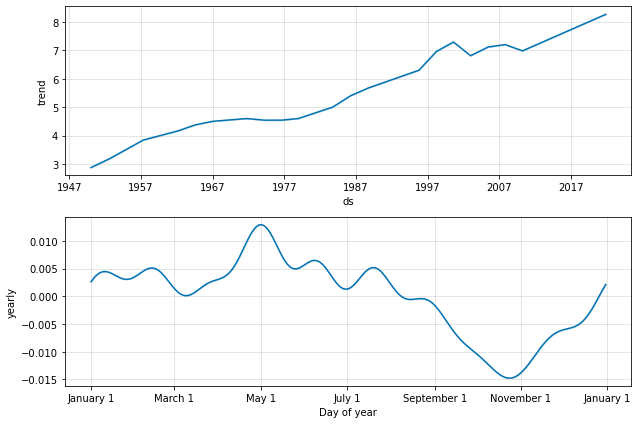

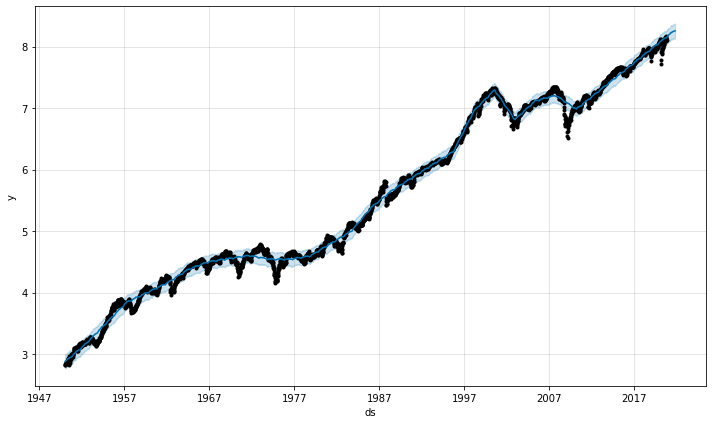

In [177]:
m = Prophet(changepoint_range = 0.85, seasonality_prior_scale = 0.01, changepoint_prior_scale=0.1)
m.fit(weekly_data_prophet)
future_dates = m.make_future_dataframe(periods=52, freq='W-MON')
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

## LSTM

In [95]:
lstm_data = weekly_data.set_index("Date")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_test

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 31.255


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 15.035 >= min_delta = 0.0. New best score: 16.220
`Trainer.fit` stopped: `max_epochs=2` reached.


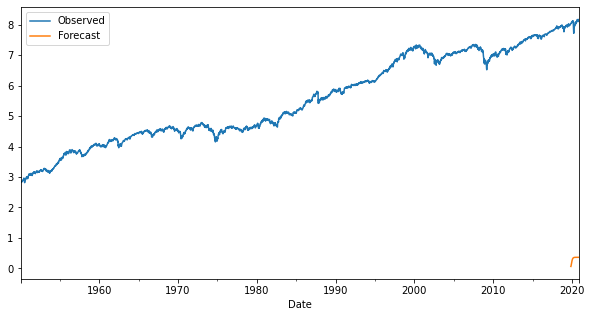

In [108]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=2,name="weekly_test")
# for cutoff in cutoffs:
#     print(cutoff)
#     data = predict_iterativly(model, data, cutoff, add_forcast_to_frame = True)
#     plot_org_w_pred(data);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs32

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 32.555


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 17.790 >= min_delta = 0.0. New best score: 14.765


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.257 >= min_delta = 0.0. New best score: 10.508


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.063 >= min_delta = 0.0. New best score: 8.445


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.036 >= min_delta = 0.0. New best score: 7.409


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.516 >= min_delta = 0.0. New best score: 6.893


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.680 >= min_delta = 0.0. New best score: 6.213


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.786 >= min_delta = 0.0. New best score: 5.427


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.177 >= min_delta = 0.0. New best score: 4.250


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.068 >= min_delta = 0.0. New best score: 3.182


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.703 >= min_delta = 0.0. New best score: 2.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.509 >= min_delta = 0.0. New best score: 1.969


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.344 >= min_delta = 0.0. New best score: 1.625


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.250 >= min_delta = 0.0. New best score: 1.375


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.204 >= min_delta = 0.0. New best score: 1.171


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.135 >= min_delta = 0.0. New best score: 1.036


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.969


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.092 >= min_delta = 0.0. New best score: 0.878


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 0.794


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.743


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.714


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.669


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.662


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.619


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.594


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.557


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.541


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.520


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.501


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.467


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.451


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.415


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.409


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.358


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.348


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.311


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.298


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.263


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.261


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.255


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.247


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.205


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.188


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.185


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.167


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.146


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.132


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.107


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.103


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.093


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.083


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.073


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.068


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.061


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.057


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.042


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.042. Signaling Trainer to stop.


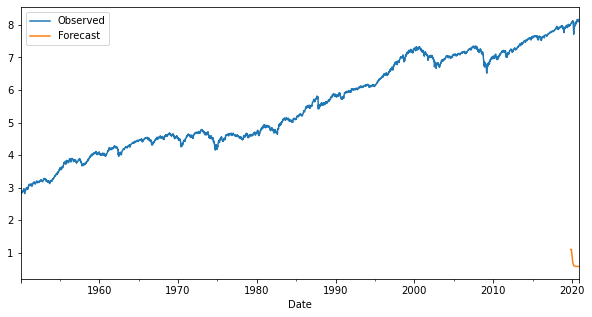

In [116]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs32")

In [ ]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs32_100_100")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs32_1e-5

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 63.960


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.992 >= min_delta = 0.0. New best score: 61.967


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.508 >= min_delta = 0.0. New best score: 59.460


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.226 >= min_delta = 0.0. New best score: 56.234


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.990 >= min_delta = 0.0. New best score: 52.244


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.429 >= min_delta = 0.0. New best score: 47.815


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.406 >= min_delta = 0.0. New best score: 43.409


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.181 >= min_delta = 0.0. New best score: 39.228


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.778 >= min_delta = 0.0. New best score: 35.450


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.177 >= min_delta = 0.0. New best score: 32.273


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.600 >= min_delta = 0.0. New best score: 29.674


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.153 >= min_delta = 0.0. New best score: 27.520


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.805 >= min_delta = 0.0. New best score: 25.715


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.527 >= min_delta = 0.0. New best score: 24.188


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.309 >= min_delta = 0.0. New best score: 22.880


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.139 >= min_delta = 0.0. New best score: 21.741


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.017 >= min_delta = 0.0. New best score: 20.723


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.913 >= min_delta = 0.0. New best score: 19.810


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.841 >= min_delta = 0.0. New best score: 18.969


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.771 >= min_delta = 0.0. New best score: 18.198


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.716 >= min_delta = 0.0. New best score: 17.482


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.673 >= min_delta = 0.0. New best score: 16.809


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.631 >= min_delta = 0.0. New best score: 16.178


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.610 >= min_delta = 0.0. New best score: 15.568


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.582 >= min_delta = 0.0. New best score: 14.986


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.540 >= min_delta = 0.0. New best score: 14.446


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.507 >= min_delta = 0.0. New best score: 13.939


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.460 >= min_delta = 0.0. New best score: 13.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.413 >= min_delta = 0.0. New best score: 13.066


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.392 >= min_delta = 0.0. New best score: 12.674


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.360 >= min_delta = 0.0. New best score: 12.314


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.339 >= min_delta = 0.0. New best score: 11.975


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.322 >= min_delta = 0.0. New best score: 11.652


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.306 >= min_delta = 0.0. New best score: 11.347


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.286 >= min_delta = 0.0. New best score: 11.061


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.278 >= min_delta = 0.0. New best score: 10.783


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.260 >= min_delta = 0.0. New best score: 10.523


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.249 >= min_delta = 0.0. New best score: 10.274


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.240 >= min_delta = 0.0. New best score: 10.034


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.229 >= min_delta = 0.0. New best score: 9.805


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.215 >= min_delta = 0.0. New best score: 9.591


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.208 >= min_delta = 0.0. New best score: 9.383


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.197 >= min_delta = 0.0. New best score: 9.186


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.189 >= min_delta = 0.0. New best score: 8.997


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.183 >= min_delta = 0.0. New best score: 8.813


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.172 >= min_delta = 0.0. New best score: 8.641


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.159 >= min_delta = 0.0. New best score: 8.482


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.162 >= min_delta = 0.0. New best score: 8.321


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.146 >= min_delta = 0.0. New best score: 8.175


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.144 >= min_delta = 0.0. New best score: 8.031


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 7.900


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 7.769


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.109 >= min_delta = 0.0. New best score: 7.660


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 7.557


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 7.448


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 7.349


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 7.262


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 7.190


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 7.107


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 7.028


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 6.965


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 6.909


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 6.862


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 6.823


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 6.792


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.202 >= min_delta = 0.0. New best score: 6.589


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.218 >= min_delta = 0.0. New best score: 6.372


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.186 >= min_delta = 0.0. New best score: 6.186


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.211 >= min_delta = 0.0. New best score: 5.975


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.306 >= min_delta = 0.0. New best score: 5.669


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.278 >= min_delta = 0.0. New best score: 5.391


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.269 >= min_delta = 0.0. New best score: 5.123


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.259 >= min_delta = 0.0. New best score: 4.864


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.225 >= min_delta = 0.0. New best score: 4.639


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.227 >= min_delta = 0.0. New best score: 4.412


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.197 >= min_delta = 0.0. New best score: 4.215


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.183 >= min_delta = 0.0. New best score: 4.032


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.180 >= min_delta = 0.0. New best score: 3.852


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.170 >= min_delta = 0.0. New best score: 3.681


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.163 >= min_delta = 0.0. New best score: 3.518


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.148 >= min_delta = 0.0. New best score: 3.370


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.140 >= min_delta = 0.0. New best score: 3.230


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.131 >= min_delta = 0.0. New best score: 3.100


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.125 >= min_delta = 0.0. New best score: 2.975


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 2.860


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.112 >= min_delta = 0.0. New best score: 2.748


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 2.640


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 2.533


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 2.437


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 2.338


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 2.243


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 2.160


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 2.075


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 1.993


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 1.913


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 1.829


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 1.762


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.697


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.633


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.569


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 1.510


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.456


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.409


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.359


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.318


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 1.277


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.240


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 1.191


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.156


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.116


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.091


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.064


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.040


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.020


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.980


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.960


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.947


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.930


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.908


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.885


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.867


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.856


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.833


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.824


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.812


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.807


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.799


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.782


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.773


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.772


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.762


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.751


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.750


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.744


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.736


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.733


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.722


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.716


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.711


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.710


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.706


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.703


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.699


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.691


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.680


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.676


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.668


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.666


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.664


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.663


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.659


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.649


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.645


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.639


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.637


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.629


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.625


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.621


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.611


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.604


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.598


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.598. Signaling Trainer to stop.


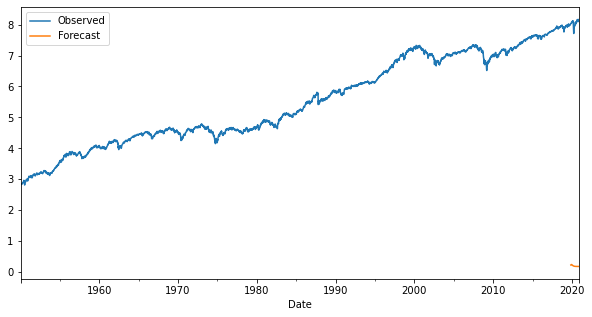

In [117]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-5,max_epochs=500,name="weekly_bs32_1e-5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs32_50_25

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 18.5 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 26    
----------------------------------------------
18.5 K    Trainable params
0         Non-trainable params
18.5 K    Total params
0.074     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 50.731


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 15.382 >= min_delta = 0.0. New best score: 35.349


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 7.694 >= min_delta = 0.0. New best score: 27.655


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.219 >= min_delta = 0.0. New best score: 23.436


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.830 >= min_delta = 0.0. New best score: 20.607


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.219 >= min_delta = 0.0. New best score: 18.387


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.848 >= min_delta = 0.0. New best score: 16.539


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.696 >= min_delta = 0.0. New best score: 14.843


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.949 >= min_delta = 0.0. New best score: 12.894


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.273 >= min_delta = 0.0. New best score: 11.621


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.986 >= min_delta = 0.0. New best score: 10.635


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.788 >= min_delta = 0.0. New best score: 9.846


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.670 >= min_delta = 0.0. New best score: 9.177


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.552 >= min_delta = 0.0. New best score: 8.625


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.443 >= min_delta = 0.0. New best score: 8.182


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.379 >= min_delta = 0.0. New best score: 7.803


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.276 >= min_delta = 0.0. New best score: 7.527


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.329 >= min_delta = 0.0. New best score: 7.198


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.386 >= min_delta = 0.0. New best score: 6.812


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.350 >= min_delta = 0.0. New best score: 6.462


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.719 >= min_delta = 0.0. New best score: 5.743


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.685 >= min_delta = 0.0. New best score: 5.057


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.561 >= min_delta = 0.0. New best score: 4.496


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.506 >= min_delta = 0.0. New best score: 3.990


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.436 >= min_delta = 0.0. New best score: 3.555


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.350 >= min_delta = 0.0. New best score: 3.205


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.338 >= min_delta = 0.0. New best score: 2.867


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.289 >= min_delta = 0.0. New best score: 2.578


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.255 >= min_delta = 0.0. New best score: 2.322


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.213 >= min_delta = 0.0. New best score: 2.109


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.205 >= min_delta = 0.0. New best score: 1.904


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.144 >= min_delta = 0.0. New best score: 1.760


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.154 >= min_delta = 0.0. New best score: 1.606


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.127 >= min_delta = 0.0. New best score: 1.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 1.369


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 1.280


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 1.198


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 1.119


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 1.065


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.014


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.967


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.905


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.893


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.853


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.805


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.769


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.748


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.704


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.697


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.660


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.658


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.642


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.629


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.568


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.520


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.492


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.456


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 0.392


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.351


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.344


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.310


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.282


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.256


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.252


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.249


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.241


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.239


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.226


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.211


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.210


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.199


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.198


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.196


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.190


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.176


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.172


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.169


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.163


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.160


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.156


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.155


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.155. Signaling Trainer to stop.


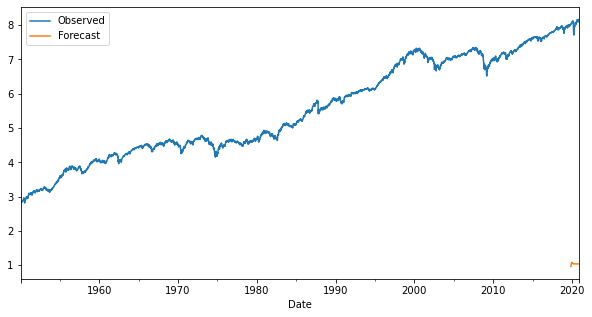

In [118]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[50, 25], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs32_50_25")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs32_2years

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 35.921


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 19.230 >= min_delta = 0.0. New best score: 16.691


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.077 >= min_delta = 0.0. New best score: 11.614


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.562 >= min_delta = 0.0. New best score: 9.053


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.221 >= min_delta = 0.0. New best score: 7.832


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.687 >= min_delta = 0.0. New best score: 7.145


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.397 >= min_delta = 0.0. New best score: 6.748


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.165 >= min_delta = 0.0. New best score: 6.583


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.572 >= min_delta = 0.0. New best score: 6.011


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.033 >= min_delta = 0.0. New best score: 4.978


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.124 >= min_delta = 0.0. New best score: 3.854


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.832 >= min_delta = 0.0. New best score: 3.022


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.595 >= min_delta = 0.0. New best score: 2.427


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.444 >= min_delta = 0.0. New best score: 1.983


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.335 >= min_delta = 0.0. New best score: 1.648


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.245 >= min_delta = 0.0. New best score: 1.403


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.164 >= min_delta = 0.0. New best score: 1.239


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 1.136


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 1.050


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 0.948


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.899


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.881


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.871


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.839


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.829


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.789


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.750


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.746


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.733


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.715


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.703


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.697


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.684


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.670


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.666


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.614


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.564


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.562


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.543


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.513


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.447


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.444


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.436


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.411


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.366


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.352


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.318


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.311


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.285


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.268


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.246


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.232


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.230


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.202


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.193


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.155


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.152


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.145


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.141


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.136


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.132


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.130


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.124


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.118


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.118


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.108


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.108. Signaling Trainer to stop.


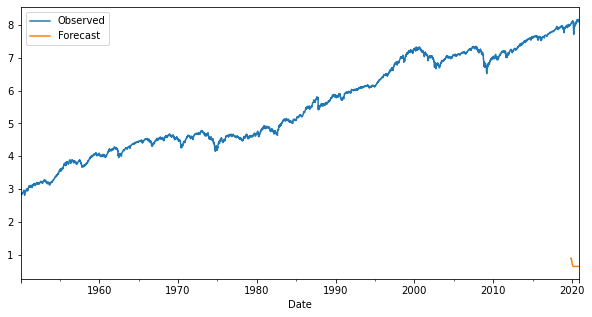

In [119]:
model = run_training_pipeline(lstm_data,
                      seq_length=104, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs32_2years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 16.443


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 7.271 >= min_delta = 0.0. New best score: 9.173


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.949 >= min_delta = 0.0. New best score: 7.224


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.709 >= min_delta = 0.0. New best score: 6.515


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.346 >= min_delta = 0.0. New best score: 6.169


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.675 >= min_delta = 0.0. New best score: 3.494


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.334 >= min_delta = 0.0. New best score: 2.161


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.793 >= min_delta = 0.0. New best score: 1.367


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.317 >= min_delta = 0.0. New best score: 1.051


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.170 >= min_delta = 0.0. New best score: 0.881


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.097 >= min_delta = 0.0. New best score: 0.784


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 0.689


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.645


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.626


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.578


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.544


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 0.472


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.463


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.407


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.376


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.367


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.329


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.266


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.229


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.214


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.200


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.180


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.177


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.116


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.104


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.102


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.101


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.093


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.055


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.055. Signaling Trainer to stop.


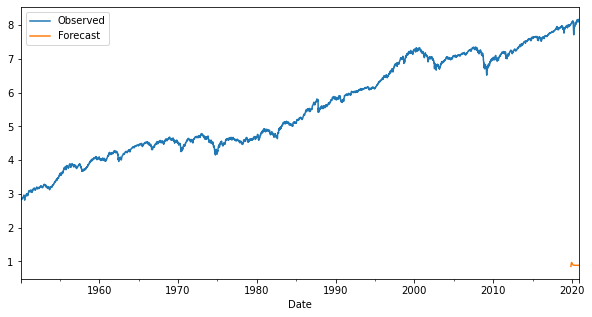

In [120]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_5e-5

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 33.954


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 16.040 >= min_delta = 0.0. New best score: 17.914


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.077 >= min_delta = 0.0. New best score: 12.837


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.486 >= min_delta = 0.0. New best score: 10.351


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.546 >= min_delta = 0.0. New best score: 8.805


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.002 >= min_delta = 0.0. New best score: 7.803


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.584 >= min_delta = 0.0. New best score: 7.220


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.376 >= min_delta = 0.0. New best score: 6.843


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.265 >= min_delta = 0.0. New best score: 6.578


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.089 >= min_delta = 0.0. New best score: 5.490


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.288 >= min_delta = 0.0. New best score: 4.202


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.903 >= min_delta = 0.0. New best score: 3.298


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.640 >= min_delta = 0.0. New best score: 2.658


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.570 >= min_delta = 0.0. New best score: 2.088


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.405 >= min_delta = 0.0. New best score: 1.684


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.289 >= min_delta = 0.0. New best score: 1.395


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.203 >= min_delta = 0.0. New best score: 1.192


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.166 >= min_delta = 0.0. New best score: 1.026


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 0.922


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 0.849


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.833


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 0.761


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.717


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.701


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.671


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.600


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.593


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.561


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.533


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.509


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.504


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.456


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.444


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.409


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.385


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.371


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.359


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.317


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.309


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.281


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.277


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.249


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.237


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.221


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.201


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.181


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.181


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.166


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.163


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.141


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.138


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.133


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.115


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.102


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.086


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.084


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.083


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.075


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.075. Signaling Trainer to stop.


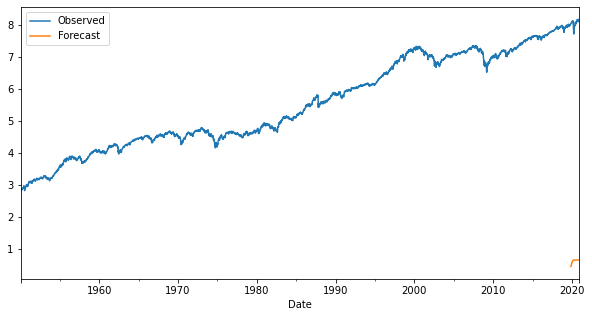

In [121]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="weekly_bs16_5e-5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_2years

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 14.770


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 7.031 >= min_delta = 0.0. New best score: 7.739


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.994 >= min_delta = 0.0. New best score: 6.745


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.162 >= min_delta = 0.0. New best score: 4.583


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.720 >= min_delta = 0.0. New best score: 2.863


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.955 >= min_delta = 0.0. New best score: 1.908


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.542 >= min_delta = 0.0. New best score: 1.366


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.260 >= min_delta = 0.0. New best score: 1.106


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 0.984


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.120 >= min_delta = 0.0. New best score: 0.864


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.800


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 0.685


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.667


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.664


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.655


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 0.559


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 0.491


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.489


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.471


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.447


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.412


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.379


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.351


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.329


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.304


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 0.229


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.197


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.175


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.158


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.138


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.137


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.126


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.120


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.116


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.083


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.078


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.078. Signaling Trainer to stop.


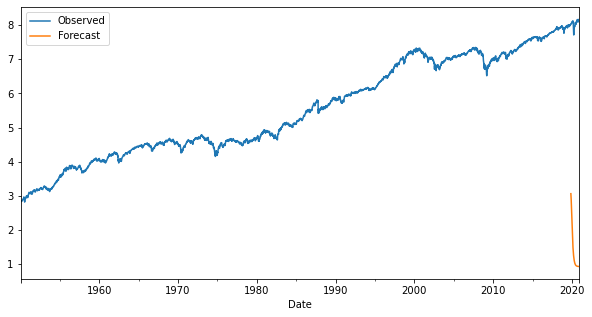

In [122]:
model = run_training_pipeline(lstm_data,
                      seq_length=104, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_2years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_100_100

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 122 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.490     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.812


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.026 >= min_delta = 0.0. New best score: 5.786


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.004 >= min_delta = 0.0. New best score: 1.782


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.877 >= min_delta = 0.0. New best score: 0.905


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.275 >= min_delta = 0.0. New best score: 0.630


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.093 >= min_delta = 0.0. New best score: 0.537


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.501


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 0.381


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.376


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.345


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.303


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.261


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.229


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.205


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.183


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.179


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 0.100


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.087


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.085


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.066


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.064


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.061


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.045


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.045. Signaling Trainer to stop.


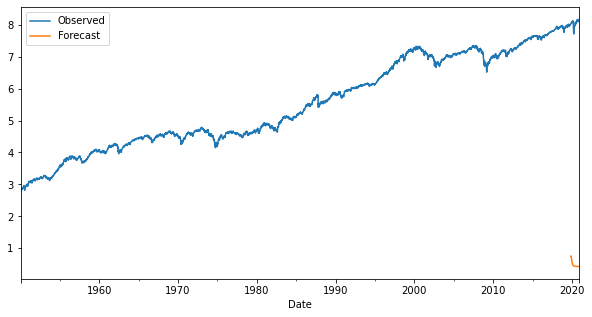

In [123]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_100_100")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_100

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.608


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.092 >= min_delta = 0.0. New best score: 5.516


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.028 >= min_delta = 0.0. New best score: 1.488


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.699 >= min_delta = 0.0. New best score: 0.789


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.181 >= min_delta = 0.0. New best score: 0.608


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.544


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 0.443


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.390


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 0.341


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.306


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 0.202


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.192


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.146


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.105


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.080


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.026


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.026. Signaling Trainer to stop.


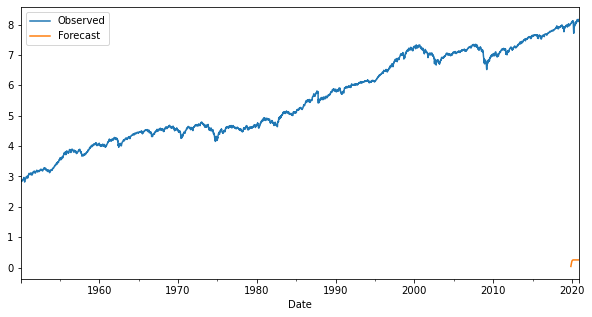

In [124]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200_100")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs8

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 7.993


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.946 >= min_delta = 0.0. New best score: 6.046


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.721 >= min_delta = 0.0. New best score: 2.325


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.105 >= min_delta = 0.0. New best score: 1.220


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.351 >= min_delta = 0.0. New best score: 0.870


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.167 >= min_delta = 0.0. New best score: 0.703


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.679


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 0.577


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.550


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 0.426


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.367


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 0.272


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 0.189


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.188


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.161


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.140


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.134


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.125


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.109


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.070


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.060


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.039


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.039. Signaling Trainer to stop.


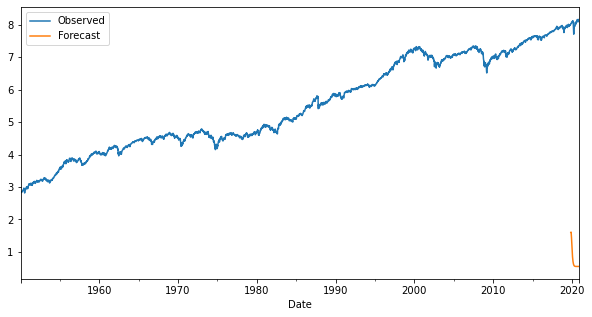

In [125]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=8, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs8")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs8_5e-5

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 14.535


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.655 >= min_delta = 0.0. New best score: 7.880


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.211 >= min_delta = 0.0. New best score: 6.670


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.843 >= min_delta = 0.0. New best score: 4.827


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.097 >= min_delta = 0.0. New best score: 2.730


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.007 >= min_delta = 0.0. New best score: 1.723


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.511 >= min_delta = 0.0. New best score: 1.212


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.274 >= min_delta = 0.0. New best score: 0.938


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 0.820


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 0.740


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 0.661


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.634


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.606


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.584


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.556


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.522


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.455


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.419


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.374


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.357


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.339


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.333


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.293


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.289


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.256


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.243


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.221


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.214


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.201


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.176


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.147


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.142


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.133


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.121


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.112


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.107


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.105


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.092


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.055


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.048


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.044


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.042


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.042


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.037


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.031


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.030


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.026


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.026. Signaling Trainer to stop.


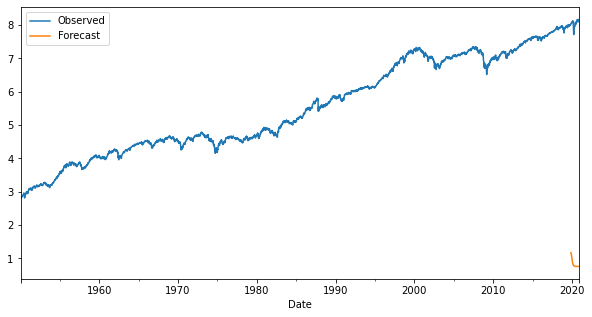

In [126]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=8, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="weekly_bs8_5e-5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs8_5e-5_200_100

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.568


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.178 >= min_delta = 0.0. New best score: 3.390


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.044 >= min_delta = 0.0. New best score: 1.346


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.538 >= min_delta = 0.0. New best score: 0.809


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.123 >= min_delta = 0.0. New best score: 0.685


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.114 >= min_delta = 0.0. New best score: 0.571


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.548


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.540


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.138 >= min_delta = 0.0. New best score: 0.402


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 0.320


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 0.244


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.173


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.136


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.132


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.125


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.107


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.075


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.072


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.061


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.053


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.042


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.023


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.023


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.018


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.018. Signaling Trainer to stop.


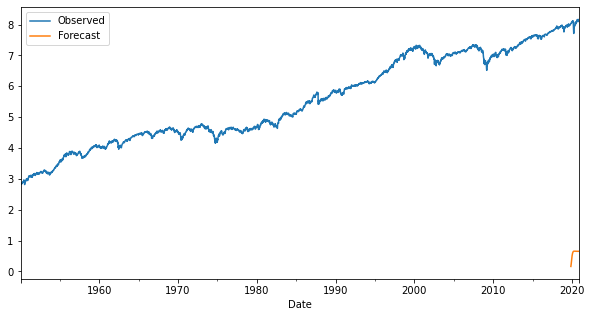

In [127]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=8, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="weekly_bs8_5e-5_200_100")

In [ ]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=8, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 200], dropout_probs=[0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="weekly_bs8_5e-5_200_200")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 364 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
364 K     Trainable params
0         Non-trainable params
364 K     Total params
1.460     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 7.372


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.008 >= min_delta = 0.0. New best score: 6.364


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.553 >= min_delta = 0.0. New best score: 2.812


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.711 >= min_delta = 0.0. New best score: 1.101


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.380 >= min_delta = 0.0. New best score: 0.721


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 0.630


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.570


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.513


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 0.436


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.391


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.339


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.304


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.238


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.217


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.171


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.165


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.139


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.133


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.126


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.099


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 0.042


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.042. Signaling Trainer to stop.


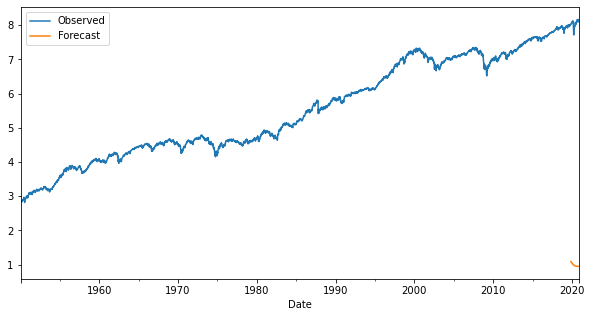

In [129]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=8, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100, 100], dropout_probs=[0.2, 0.2,0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="weekly_bs8_5e-5_200_100_100")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs32_5e-5

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 51.872


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 20.477 >= min_delta = 0.0. New best score: 31.395


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 11.759 >= min_delta = 0.0. New best score: 19.636


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.995 >= min_delta = 0.0. New best score: 14.640


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.500 >= min_delta = 0.0. New best score: 12.140


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.592 >= min_delta = 0.0. New best score: 10.548


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.141 >= min_delta = 0.0. New best score: 9.407


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.935 >= min_delta = 0.0. New best score: 8.472


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.662 >= min_delta = 0.0. New best score: 7.811


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.510 >= min_delta = 0.0. New best score: 7.300


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.406 >= min_delta = 0.0. New best score: 6.894


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.336 >= min_delta = 0.0. New best score: 6.558


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.816 >= min_delta = 0.0. New best score: 5.742


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.748 >= min_delta = 0.0. New best score: 4.994


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.604 >= min_delta = 0.0. New best score: 4.390


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.551 >= min_delta = 0.0. New best score: 3.839


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.497 >= min_delta = 0.0. New best score: 3.342


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.421 >= min_delta = 0.0. New best score: 2.921


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.336 >= min_delta = 0.0. New best score: 2.585


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.284 >= min_delta = 0.0. New best score: 2.301


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.249 >= min_delta = 0.0. New best score: 2.052


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.221 >= min_delta = 0.0. New best score: 1.831


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.170 >= min_delta = 0.0. New best score: 1.661


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.159 >= min_delta = 0.0. New best score: 1.502


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.139 >= min_delta = 0.0. New best score: 1.363


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.111 >= min_delta = 0.0. New best score: 1.252


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 1.157


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 1.085


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.028


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.983


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.939


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.887


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.841


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.824


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.799


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.773


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.765


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.741


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.720


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.686


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.676


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.653


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.651


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.642


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.624


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.604


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.578


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.574


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.549


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.540


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.529


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.521


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.506


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.481


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.467


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.458


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.438


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.405


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.404


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.366


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.351


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.338


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.314


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.299


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.285


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.282


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.259


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.241


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.208


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.206


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.201


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.196


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.176


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.160


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.144


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.142


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.135


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.134


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.132


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.114


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.114. Signaling Trainer to stop.


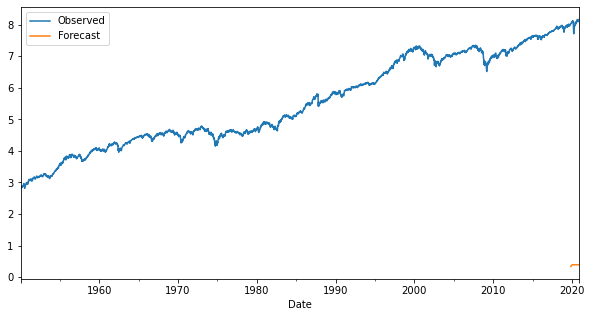

In [130]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=32, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="weekly_bs32_5e-5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_100_50

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 314 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
314 K     Trainable params
0         Non-trainable params
314 K     Total params
1.258     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 16.468


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.228 >= min_delta = 0.0. New best score: 10.240


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.445 >= min_delta = 0.0. New best score: 7.795


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.979 >= min_delta = 0.0. New best score: 6.816


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.328 >= min_delta = 0.0. New best score: 6.488


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 6.482


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.168 >= min_delta = 0.0. New best score: 6.314


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.507 >= min_delta = 0.0. New best score: 4.807


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.239 >= min_delta = 0.0. New best score: 2.567


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.903 >= min_delta = 0.0. New best score: 1.664


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.454 >= min_delta = 0.0. New best score: 1.210


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.274 >= min_delta = 0.0. New best score: 0.936


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.116 >= min_delta = 0.0. New best score: 0.819


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 0.751


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.725


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 0.636


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 0.564


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.534


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.493


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.466


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.451


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.408


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.399


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.344


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.323


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 0.238


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.220


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.207


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.186


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.166


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.142


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.113


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.107


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.091


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.080


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.080. Signaling Trainer to stop.


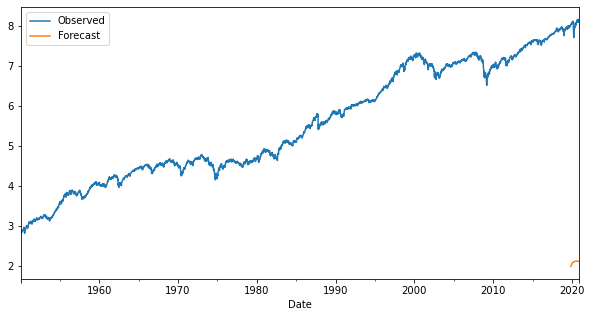

In [131]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100, 50], dropout_probs=[0.2, 0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200_100_50")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_100_50_5e5

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 314 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
314 K     Trainable params
0         Non-trainable params
314 K     Total params
1.258     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 22.854


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 9.521 >= min_delta = 0.0. New best score: 13.333


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.255 >= min_delta = 0.0. New best score: 10.078


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.053 >= min_delta = 0.0. New best score: 8.025


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.814 >= min_delta = 0.0. New best score: 7.211


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.418 >= min_delta = 0.0. New best score: 6.793


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.197 >= min_delta = 0.0. New best score: 6.596


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.098 >= min_delta = 0.0. New best score: 6.497


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.167 >= min_delta = 0.0. New best score: 6.330


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.869 >= min_delta = 0.0. New best score: 4.461


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.256 >= min_delta = 0.0. New best score: 3.205


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.781 >= min_delta = 0.0. New best score: 2.424


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.544 >= min_delta = 0.0. New best score: 1.880


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.372 >= min_delta = 0.0. New best score: 1.508


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.288 >= min_delta = 0.0. New best score: 1.220


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.171 >= min_delta = 0.0. New best score: 1.049


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 0.958


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 0.873


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 0.802


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.760


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 0.700


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.654


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.612


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 0.547


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.532


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.526


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.515


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 0.446


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.422


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.409


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.395


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.376


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.351


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.342


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.297


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.282


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.265


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.258


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.251


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.242


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.232


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.226


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.221


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.195


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.195


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.188


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.180


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.166


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.157


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.148


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.146


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.138


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.132


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.130


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.119


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.115


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.115


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.106


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.102


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.091


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.090


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.089


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.085


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.080


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.080


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.068


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.066


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.064


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.060


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.060. Signaling Trainer to stop.


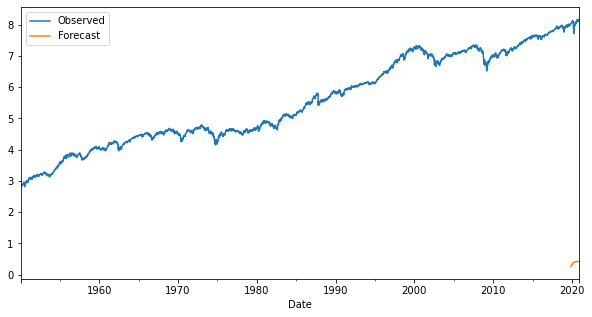

In [132]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100, 50], dropout_probs=[0.2, 0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="weekly_bs16_200_100_50_5e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.284


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.467 >= min_delta = 0.0. New best score: 3.816


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.039 >= min_delta = 0.0. New best score: 0.778


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.224 >= min_delta = 0.0. New best score: 0.554


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 0.444


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 0.339


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.322


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 0.246


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.217


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.155


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.127


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.102


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.085


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.064


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.048


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.039


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.035


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.031


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.026


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.026


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.020


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.015


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.015. Signaling Trainer to stop.


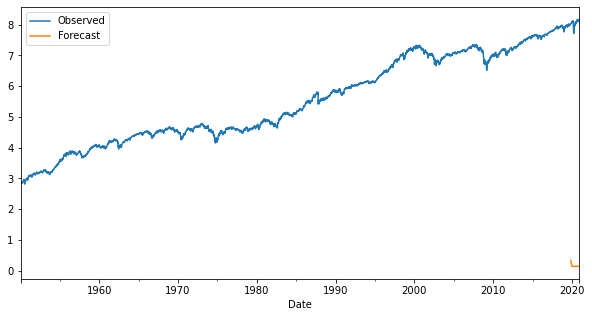

In [133]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_do01

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.263


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.677 >= min_delta = 0.0. New best score: 3.586


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.922 >= min_delta = 0.0. New best score: 0.665


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.155 >= min_delta = 0.0. New best score: 0.509


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.155 >= min_delta = 0.0. New best score: 0.354


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 0.244


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.242


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.209


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.186


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.186


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.161


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 0.073


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.067


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.067


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.053


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.045


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.040


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.020


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.018


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.018


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.016


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.013


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.007


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.005. Signaling Trainer to stop.


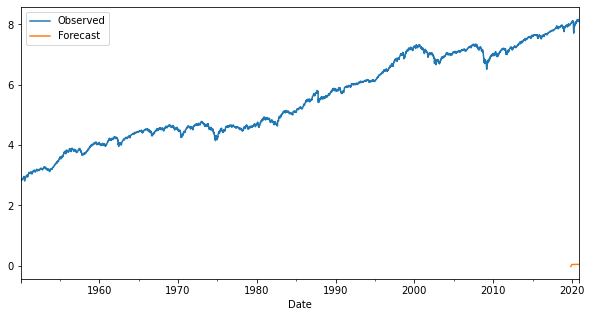

In [134]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.1],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200_do01")

In [ ]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.01],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200_do0")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_do03

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.294


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.929 >= min_delta = 0.0. New best score: 5.365


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.293 >= min_delta = 0.0. New best score: 1.072


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.497 >= min_delta = 0.0. New best score: 0.576


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 0.463


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 0.369


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.368


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.360


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 0.276


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.252


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.221


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.157


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.123


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.103


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.102


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.087


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.036


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.029


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.029. Signaling Trainer to stop.


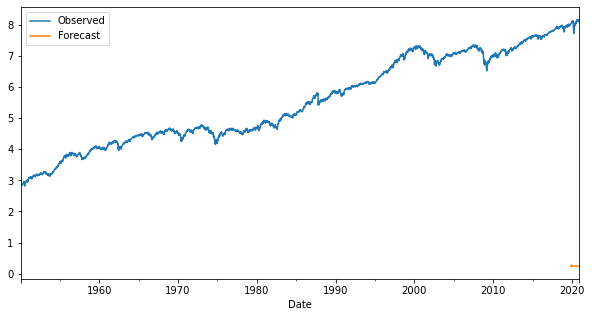

In [135]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.3],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200_do03")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_do04

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.442


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.012 >= min_delta = 0.0. New best score: 3.430


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.684 >= min_delta = 0.0. New best score: 0.746


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.231 >= min_delta = 0.0. New best score: 0.515


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 0.440


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.418


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.370


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.309


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.289


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.284


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 0.207


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.177


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.132


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.110


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 0.037


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.030


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.022


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.020


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.015


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.015. Signaling Trainer to stop.


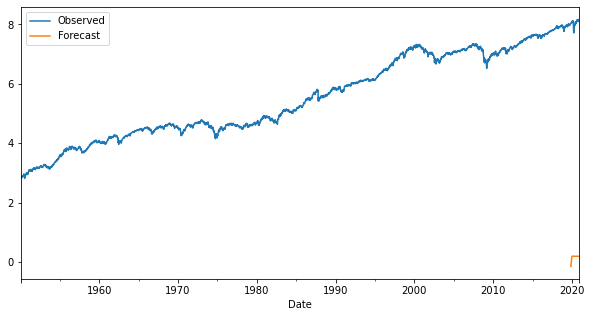

In [136]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.4],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200_do04")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_2years

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.391


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.912 >= min_delta = 0.0. New best score: 5.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.353 >= min_delta = 0.0. New best score: 1.126


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.430 >= min_delta = 0.0. New best score: 0.696


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 0.573


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.512


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 0.399


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.375


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.363


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.339


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.320


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.290


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.221


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.202


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.197


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.146


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.122


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.066


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.055


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.021


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.021. Signaling Trainer to stop.


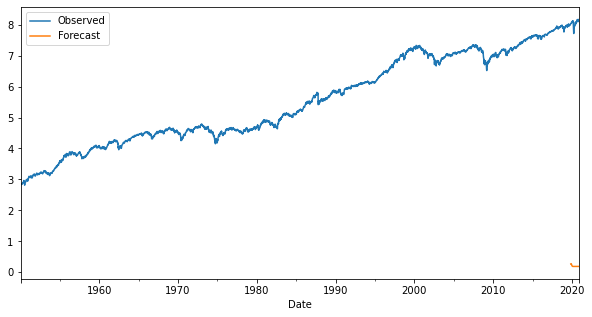

In [137]:
model = run_training_pipeline(lstm_data,
                      seq_length=104, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200_2years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_300

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 364 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 301   
----------------------------------------------
365 K     Trainable params
0         Non-trainable params
365 K     Total params
1.460     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.353


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.407 >= min_delta = 0.0. New best score: 0.946


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.509 >= min_delta = 0.0. New best score: 0.437


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 0.349


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 0.269


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.218


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.165


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.140


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.104


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.100


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.059


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.039


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.034


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.028


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.022


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.016


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.009


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.009


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.006


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.005. Signaling Trainer to stop.


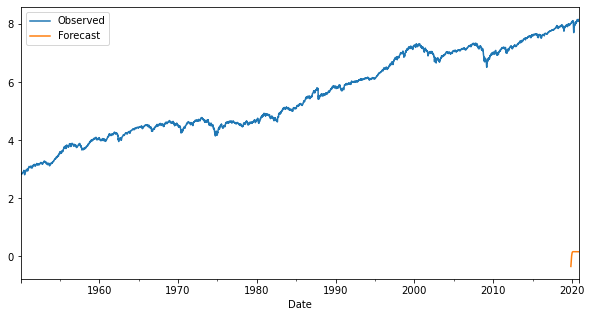

In [138]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[300], dropout_probs=[0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_300")

In [ ]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[300], dropout_probs=[0.01],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_300_do0")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_300_2years

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 364 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 301   
----------------------------------------------
365 K     Trainable params
0         Non-trainable params
365 K     Total params
1.460     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 5.888


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.757 >= min_delta = 0.0. New best score: 1.131


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.527 >= min_delta = 0.0. New best score: 0.604


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.226 >= min_delta = 0.0. New best score: 0.378


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.327


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.297


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.294


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.224


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.194


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.151


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.124


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.101


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.079


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.038


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.038


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.027


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.025


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.023


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.017


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.017. Signaling Trainer to stop.


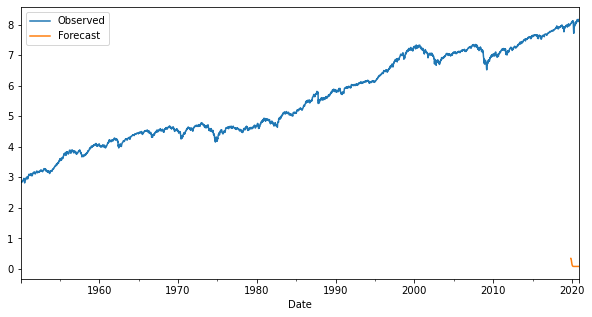

In [139]:
model = run_training_pipeline(lstm_data,
                      seq_length=104, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[300], dropout_probs=[0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_300_2years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_300_5years

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 364 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 301   
----------------------------------------------
365 K     Trainable params
0         Non-trainable params
365 K     Total params
1.460     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 5.801


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.633 >= min_delta = 0.0. New best score: 4.168


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.343 >= min_delta = 0.0. New best score: 0.825


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.185 >= min_delta = 0.0. New best score: 0.640


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.579


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.541


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.499


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.452


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 0.380


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.353


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.315


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.297


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.242


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.241


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 0.166


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.128


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.117


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.113


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.070


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.037


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.037. Signaling Trainer to stop.


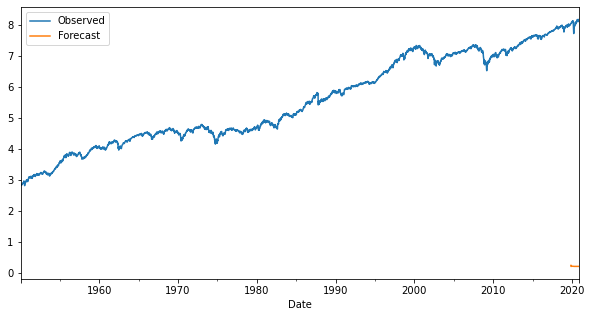

In [140]:
model = run_training_pipeline(lstm_data,
                      seq_length=52*5, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[300], dropout_probs=[0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_300_5years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_300_5e5

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 364 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 301   
----------------------------------------------
365 K     Trainable params
0         Non-trainable params
365 K     Total params
1.460     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.217


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.066 >= min_delta = 0.0. New best score: 4.151


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.382 >= min_delta = 0.0. New best score: 0.770


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.223 >= min_delta = 0.0. New best score: 0.546


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.200 >= min_delta = 0.0. New best score: 0.346


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.275


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.242


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.212


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.182


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.156


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.153


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.146


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.133


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.094


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.082


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.070


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.057


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.051


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.038


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.016


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.016. Signaling Trainer to stop.


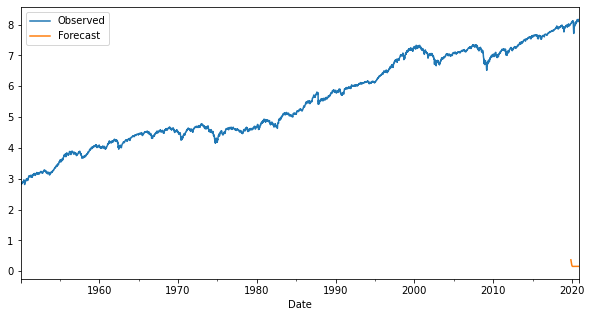

In [141]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[300], dropout_probs=[0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="weekly_bs16_300_5e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs8_300_5e5

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 364 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 301   
----------------------------------------------
365 K     Trainable params
0         Non-trainable params
365 K     Total params
1.460     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 5.567


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.974 >= min_delta = 0.0. New best score: 0.594


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.182 >= min_delta = 0.0. New best score: 0.412


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.356


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.130 >= min_delta = 0.0. New best score: 0.226


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.118 >= min_delta = 0.0. New best score: 0.107


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.090


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.029


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.017


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.016


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.015


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.012


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.010


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.009


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.007


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.005


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.005. Signaling Trainer to stop.


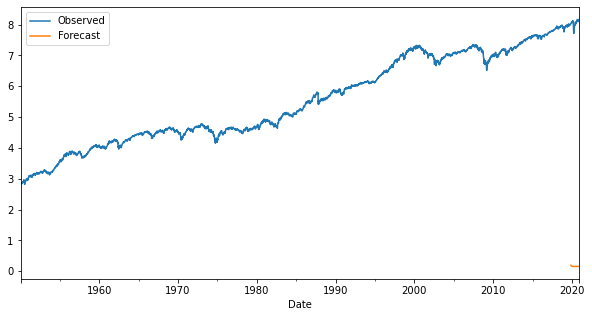

In [142]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=8, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[300], dropout_probs=[0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="weekly_bs8_300_5e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_500_do0

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 1.0 M 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 501   
----------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.034     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 5.441


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.984 >= min_delta = 0.0. New best score: 0.457


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.248 >= min_delta = 0.0. New best score: 0.209


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.167


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 0.066


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.056


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.026


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.007


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.006


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.006


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.006. Signaling Trainer to stop.


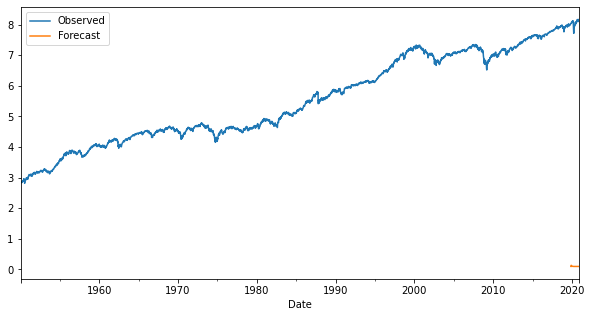

In [143]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[500], dropout_probs=[0.01],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_500_do0")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_500

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 1.0 M 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 501   
----------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.034     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 5.441


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.873 >= min_delta = 0.0. New best score: 0.569


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.204 >= min_delta = 0.0. New best score: 0.365


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.188 >= min_delta = 0.0. New best score: 0.177


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.125


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.105 >= min_delta = 0.0. New best score: 0.020


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.020. Signaling Trainer to stop.


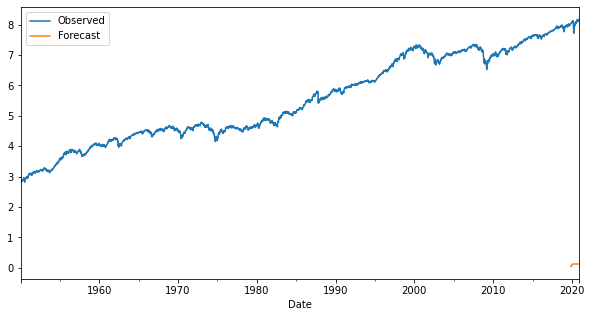

In [144]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[500], dropout_probs=[0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_500")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_500_do05

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 1.0 M 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 501   
----------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.034     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 3.753


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.314 >= min_delta = 0.0. New best score: 0.439


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.369


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 0.294


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.235 >= min_delta = 0.0. New best score: 0.059


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.034


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.020


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.020. Signaling Trainer to stop.


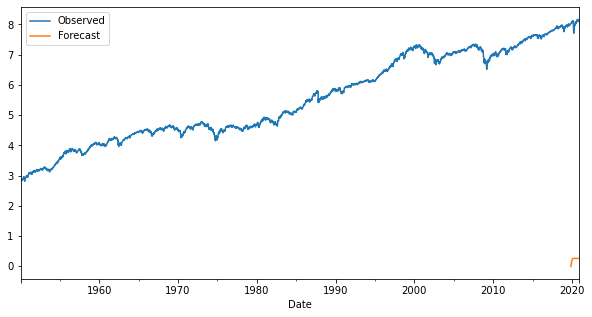

In [145]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[500], dropout_probs=[0.5],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_500_do05")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_1e5

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 48.961


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 10.817 >= min_delta = 0.0. New best score: 38.144


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 13.328 >= min_delta = 0.0. New best score: 24.816


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 9.355 >= min_delta = 0.0. New best score: 15.461


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.711 >= min_delta = 0.0. New best score: 10.750


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.334 >= min_delta = 0.0. New best score: 8.417


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.199 >= min_delta = 0.0. New best score: 7.217


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.788 >= min_delta = 0.0. New best score: 6.429


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.439 >= min_delta = 0.0. New best score: 5.990


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.872 >= min_delta = 0.0. New best score: 5.119


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.982 >= min_delta = 0.0. New best score: 4.136


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.152 >= min_delta = 0.0. New best score: 2.984


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.801 >= min_delta = 0.0. New best score: 2.184


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.561 >= min_delta = 0.0. New best score: 1.623


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.363 >= min_delta = 0.0. New best score: 1.260


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.225 >= min_delta = 0.0. New best score: 1.034


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.173 >= min_delta = 0.0. New best score: 0.861


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.113 >= min_delta = 0.0. New best score: 0.748


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 0.663


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 0.582


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.541


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 0.487


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.447


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.418


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.383


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.341


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.316


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.298


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.288


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.254


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.249


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.237


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.235


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.223


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.215


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.200


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.191


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.176


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.169


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.159


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.156


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.145


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.133


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.133


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.127


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.118


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.116


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.111


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.110


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.108


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.106


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.102


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.097


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.094


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.093


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.093


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.092


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.084


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.074


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.074


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.072


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.072. Signaling Trainer to stop.


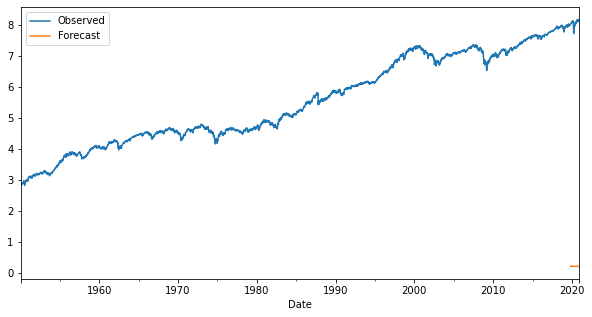

In [146]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.2],                      
                      learning_rate=1e-5,max_epochs=500,name="weekly_bs16_200_1e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_1e5_do05

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 57.661


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 10.816 >= min_delta = 0.0. New best score: 46.846


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 15.507 >= min_delta = 0.0. New best score: 31.339


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 11.651 >= min_delta = 0.0. New best score: 19.688


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.547 >= min_delta = 0.0. New best score: 13.141


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.458 >= min_delta = 0.0. New best score: 9.683


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.682 >= min_delta = 0.0. New best score: 8.001


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.814 >= min_delta = 0.0. New best score: 7.187


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.578 >= min_delta = 0.0. New best score: 6.609


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.766 >= min_delta = 0.0. New best score: 5.843


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.564 >= min_delta = 0.0. New best score: 5.279


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.691 >= min_delta = 0.0. New best score: 4.588


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.728 >= min_delta = 0.0. New best score: 3.859


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.760 >= min_delta = 0.0. New best score: 3.099


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.682 >= min_delta = 0.0. New best score: 2.417


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.496 >= min_delta = 0.0. New best score: 1.921


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.340 >= min_delta = 0.0. New best score: 1.582


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.268 >= min_delta = 0.0. New best score: 1.314


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.186 >= min_delta = 0.0. New best score: 1.128


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 1.029


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 0.907


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 0.823


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.770


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.700


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.654


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.636


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.598


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.575


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.543


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.517


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.482


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.462


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.437


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.419


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.372


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.354


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.327


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.320


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.305


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.280


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.278


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.262


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.253


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.245


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.220


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.192


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.192. Signaling Trainer to stop.


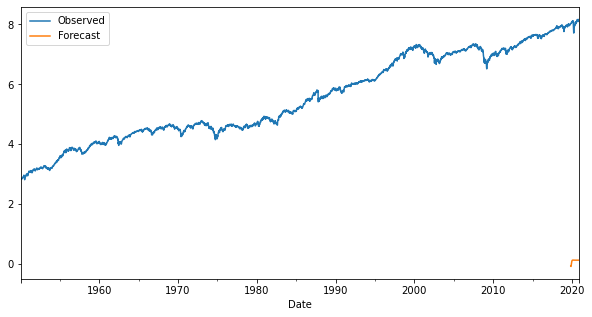

In [147]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.5],                      
                      learning_rate=1e-5,max_epochs=500,name="weekly_bs16_200_1e5_do05")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_5e6

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 59.829


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.649 >= min_delta = 0.0. New best score: 55.180


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.272 >= min_delta = 0.0. New best score: 49.908


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.479 >= min_delta = 0.0. New best score: 43.429


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 7.766 >= min_delta = 0.0. New best score: 35.663


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 7.626 >= min_delta = 0.0. New best score: 28.037


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.911 >= min_delta = 0.0. New best score: 22.126


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.280 >= min_delta = 0.0. New best score: 17.846


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.155 >= min_delta = 0.0. New best score: 14.691


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.446 >= min_delta = 0.0. New best score: 12.245


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.836 >= min_delta = 0.0. New best score: 10.409


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.362 >= min_delta = 0.0. New best score: 9.048


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.939 >= min_delta = 0.0. New best score: 8.108


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.647 >= min_delta = 0.0. New best score: 7.461


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.460 >= min_delta = 0.0. New best score: 7.001


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.282 >= min_delta = 0.0. New best score: 6.719


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.151 >= min_delta = 0.0. New best score: 6.569


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.176 >= min_delta = 0.0. New best score: 6.393


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 6.330


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.158 >= min_delta = 0.0. New best score: 6.172


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.327 >= min_delta = 0.0. New best score: 5.845


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.501 >= min_delta = 0.0. New best score: 5.344


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.600 >= min_delta = 0.0. New best score: 4.745


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.775 >= min_delta = 0.0. New best score: 3.970


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.768 >= min_delta = 0.0. New best score: 3.202


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.614 >= min_delta = 0.0. New best score: 2.588


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.437 >= min_delta = 0.0. New best score: 2.151


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.361 >= min_delta = 0.0. New best score: 1.790


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.283 >= min_delta = 0.0. New best score: 1.507


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.232 >= min_delta = 0.0. New best score: 1.276


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.185 >= min_delta = 0.0. New best score: 1.091


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.142 >= min_delta = 0.0. New best score: 0.950


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 0.841


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 0.754


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.683


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.613


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.560


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.529


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.485


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.452


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.424


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.411


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.385


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.374


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.353


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.344


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.331


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.318


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.309


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.302


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.281


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.260


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.256


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.253


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.246


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.232


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.231


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.216


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.209


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.204


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.186


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.179


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.173


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.167


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.164


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.156


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.152


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.144


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.144


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.141


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.135


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.131


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.130


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.127


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.116


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.112


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.109


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.106


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.104


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.103


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.101


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.100


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.096


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.092


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.092. Signaling Trainer to stop.


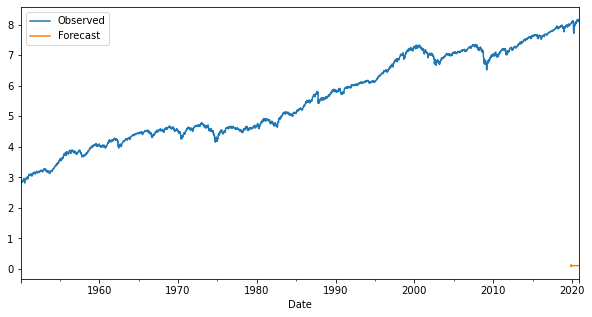

In [148]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.2],                      
                      learning_rate=5e-6,max_epochs=500,name="weekly_bs16_200_5e6")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_5e5

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 163 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 11.084


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.759 >= min_delta = 0.0. New best score: 6.324


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.549 >= min_delta = 0.0. New best score: 5.776


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.825 >= min_delta = 0.0. New best score: 1.951


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.096 >= min_delta = 0.0. New best score: 0.855


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.198 >= min_delta = 0.0. New best score: 0.657


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.134 >= min_delta = 0.0. New best score: 0.523


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 0.432


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 0.347


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 0.255


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.200


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.172


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.162


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.145


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.143


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.142


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.122


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.106


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.097


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.069


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.060


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.058


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.053


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.052


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.048


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.046


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.042


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.033


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.024


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.021


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.021


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.013


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.008


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.007. Signaling Trainer to stop.


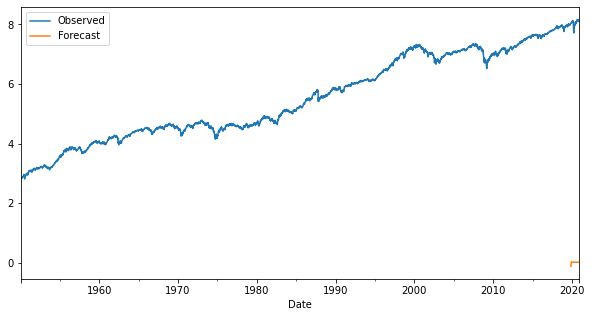

In [149]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200], dropout_probs=[0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="weekly_bs16_200_5e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_100_more_do_1e5

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 52.874


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 20.648 >= min_delta = 0.0. New best score: 32.226


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 14.449 >= min_delta = 0.0. New best score: 17.778


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.535 >= min_delta = 0.0. New best score: 12.243


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.701 >= min_delta = 0.0. New best score: 9.542


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.389 >= min_delta = 0.0. New best score: 8.153


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.848 >= min_delta = 0.0. New best score: 7.305


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.536 >= min_delta = 0.0. New best score: 6.769


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.292 >= min_delta = 0.0. New best score: 6.477


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.160 >= min_delta = 0.0. New best score: 6.317


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 6.213


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.246 >= min_delta = 0.0. New best score: 5.967


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.636 >= min_delta = 0.0. New best score: 5.331


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.998 >= min_delta = 0.0. New best score: 4.333


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.782 >= min_delta = 0.0. New best score: 3.551


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.577 >= min_delta = 0.0. New best score: 2.974


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.459 >= min_delta = 0.0. New best score: 2.515


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.367 >= min_delta = 0.0. New best score: 2.148


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.301 >= min_delta = 0.0. New best score: 1.847


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.249 >= min_delta = 0.0. New best score: 1.598


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.212 >= min_delta = 0.0. New best score: 1.385


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.156 >= min_delta = 0.0. New best score: 1.229


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.130 >= min_delta = 0.0. New best score: 1.099


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 0.999


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 0.923


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.861


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.807


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.760


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.726


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.693


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.668


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.640


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.617


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.590


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.582


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.566


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.536


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.510


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.492


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.489


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.483


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.454


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.451


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.440


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.422


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.402


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.384


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.378


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.373


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.364


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.357


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.337


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.330


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.321


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.302


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.299


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.287


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.278


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.277


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.274


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.265


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.258


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.250


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.228


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.228


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.209


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.205


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.204


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.192


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.183


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.164


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.160


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.160


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.154


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.140


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.139


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.137


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.123


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.120


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.117


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.110


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.109


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.107


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.096


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.091


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.087


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.076


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.076


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.076


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.075


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.068


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.066


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.064


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.060


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.060


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.059


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.059. Signaling Trainer to stop.


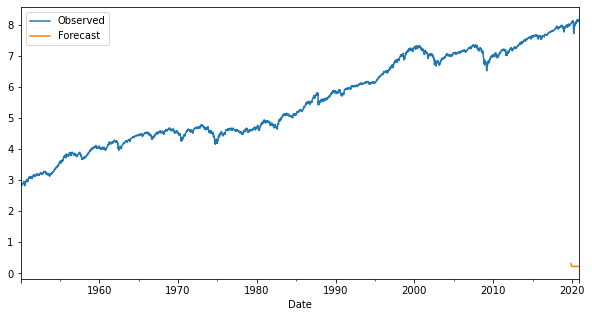

In [150]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.4, 0.3],                      
                      learning_rate=1e-5,max_epochs=500,name="weekly_bs16_200_100_more_do_1e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_100_more_do

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.442


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.267 >= min_delta = 0.0. New best score: 3.175


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.083 >= min_delta = 0.0. New best score: 1.092


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.374 >= min_delta = 0.0. New best score: 0.717


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.646


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.092 >= min_delta = 0.0. New best score: 0.554


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.494


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.479


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.415


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.124 >= min_delta = 0.0. New best score: 0.291


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.267


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.241


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.184


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.117


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.111


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.067


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.062


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.047


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.042


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.032


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.030


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.022


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.019


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.019. Signaling Trainer to stop.


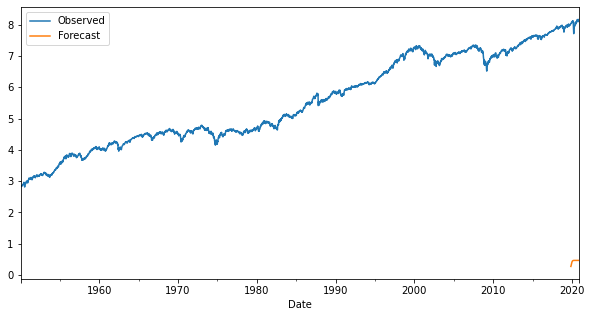

In [151]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.4, 0.3],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200_100_more_do")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_200_more_do

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 484 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
485 K     Trainable params
0         Non-trainable params
485 K     Total params
1.940     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 5.698


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.025 >= min_delta = 0.0. New best score: 0.672


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.238 >= min_delta = 0.0. New best score: 0.434


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 0.347


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 0.246


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 0.173


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.114


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.085


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.060


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.053


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.044


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.030


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.020


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.019


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.012


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.


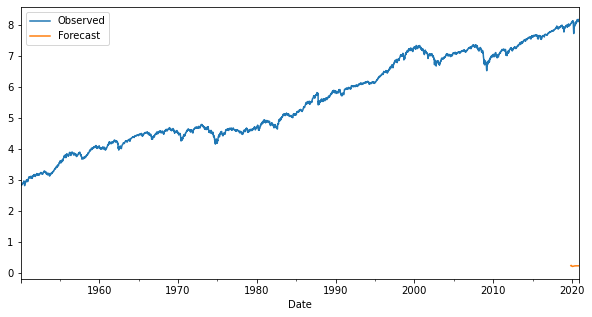

In [152]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 200], dropout_probs=[0.4, 0.3],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200_200_more_do")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_100_5e5

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 10.196


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.510 >= min_delta = 0.0. New best score: 6.686


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.217 >= min_delta = 0.0. New best score: 5.469


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.417 >= min_delta = 0.0. New best score: 3.052


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.317 >= min_delta = 0.0. New best score: 1.735


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.593 >= min_delta = 0.0. New best score: 1.142


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.278 >= min_delta = 0.0. New best score: 0.865


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.159 >= min_delta = 0.0. New best score: 0.706


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.639


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.619


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.580


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.577


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.542


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.498


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.482


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 0.400


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.352


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.297


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.271


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.208


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.186


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.169


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.135


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.132


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.112


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.094


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.094


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.085


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.082


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.076


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.067


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.055


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.055. Signaling Trainer to stop.


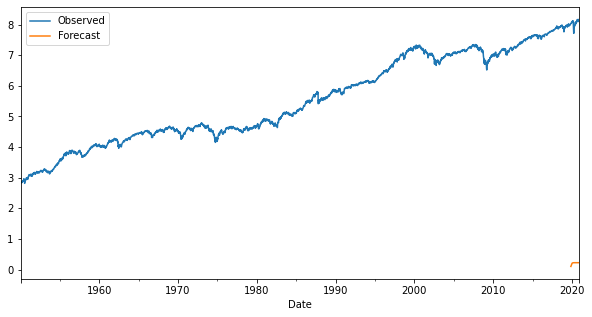

In [153]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=5e-5,max_epochs=500,name="weekly_bs16_200_100_5e5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_100_2years

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.347


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.301 >= min_delta = 0.0. New best score: 4.046


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.764 >= min_delta = 0.0. New best score: 1.282


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.432 >= min_delta = 0.0. New best score: 0.850


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.146 >= min_delta = 0.0. New best score: 0.703


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 0.583


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.515


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.070 >= min_delta = 0.0. New best score: 0.445


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.383


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.329


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.287


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.271


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.261


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.223


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.177


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.168


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.150


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.133


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.098


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.093


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.069


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.063


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.062


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.059


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.050


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.037


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.037. Signaling Trainer to stop.


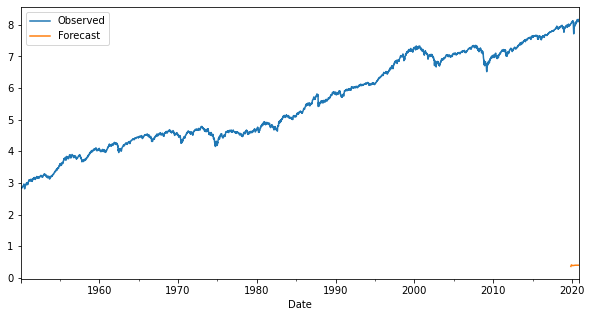

In [154]:
model = run_training_pipeline(lstm_data,
                      seq_length=104, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200_100_2years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_200_2years_do3

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 484 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 201   
----------------------------------------------
485 K     Trainable params
0         Non-trainable params
485 K     Total params
1.940     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 5.224


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 4.582 >= min_delta = 0.0. New best score: 0.642


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.632


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.174 >= min_delta = 0.0. New best score: 0.458


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 0.357


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.353


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.283


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.122 >= min_delta = 0.0. New best score: 0.161


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.140


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.138


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 0.052


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.052. Signaling Trainer to stop.


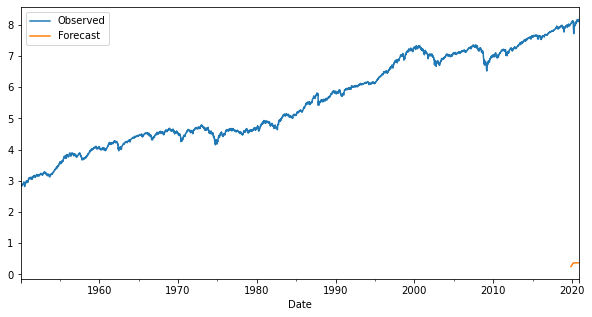

In [155]:
model = run_training_pipeline(lstm_data,
                      seq_length=104, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 200], dropout_probs=[0.3, 0.3],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200_200_2years_do3")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.153


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.251 >= min_delta = 0.0. New best score: 2.902


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.831 >= min_delta = 0.0. New best score: 1.071


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.393 >= min_delta = 0.0. New best score: 0.678


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.156 >= min_delta = 0.0. New best score: 0.522


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.481


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 0.382


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.330


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.267


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.259


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.224


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.181


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.179


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.151


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.142


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.136


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.089


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.081


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.074


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.071


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.049


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.038


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.037


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.024


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.024. Signaling Trainer to stop.


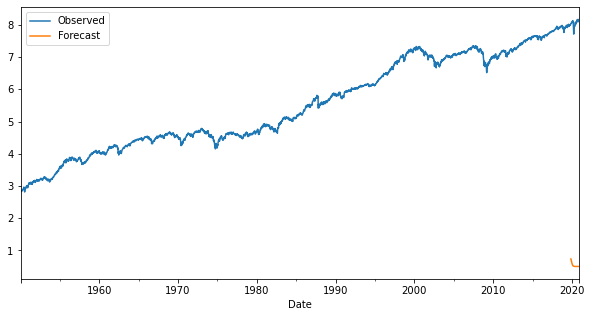

In [156]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_200_100")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_200_100_75e-5

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 7.587


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.045 >= min_delta = 0.0. New best score: 6.542


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.811 >= min_delta = 0.0. New best score: 4.731


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.005 >= min_delta = 0.0. New best score: 1.726


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.742 >= min_delta = 0.0. New best score: 0.984


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.209 >= min_delta = 0.0. New best score: 0.774


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 0.686


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 0.620


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.572


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.546


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.485


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.091 >= min_delta = 0.0. New best score: 0.394


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.380


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.355


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.303


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.259


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.220


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.201


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.151


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.142


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.122


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.088


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.087


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.076


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 0.052


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.052. Signaling Trainer to stop.


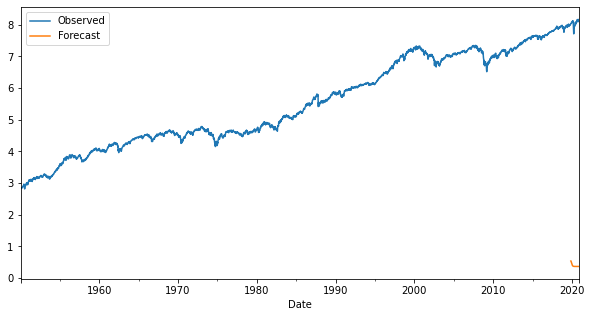

In [157]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.2, 0.2],                      
                      learning_rate=7.5e-5,max_epochs=500,name="weekly_bs16_200_100_75e-5")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_3years

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 72.0 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 51    
----------------------------------------------
72.1 K    Trainable params
0         Non-trainable params
72.1 K    Total params
0.288     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 13.078


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 6.050 >= min_delta = 0.0. New best score: 7.028


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.466 >= min_delta = 0.0. New best score: 6.562


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.626 >= min_delta = 0.0. New best score: 4.936


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.258 >= min_delta = 0.0. New best score: 2.678


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.679 >= min_delta = 0.0. New best score: 1.999


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.456 >= min_delta = 0.0. New best score: 1.543


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.274 >= min_delta = 0.0. New best score: 1.269


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.169 >= min_delta = 0.0. New best score: 1.100


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 0.985


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.120 >= min_delta = 0.0. New best score: 0.864


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 0.765


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.764


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.128 >= min_delta = 0.0. New best score: 0.635


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.635. Signaling Trainer to stop.


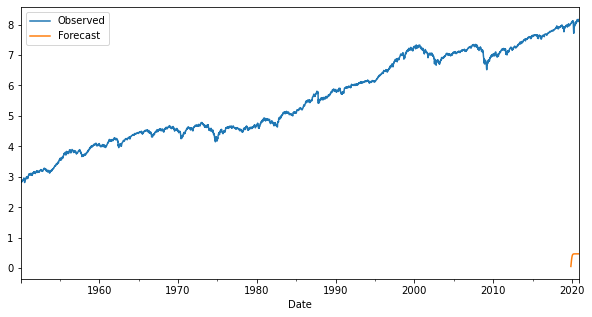

In [158]:
model = run_training_pipeline(lstm_data,
                      seq_length=52*3, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 50], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_3years")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_3years_50_25

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 18.5 K
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 26    
----------------------------------------------
18.5 K    Trainable params
0         Non-trainable params
18.5 K    Total params
0.074     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 40.600


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 21.112 >= min_delta = 0.0. New best score: 19.487


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 5.339 >= min_delta = 0.0. New best score: 14.149


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 2.781 >= min_delta = 0.0. New best score: 11.368


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.808 >= min_delta = 0.0. New best score: 9.560


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.190 >= min_delta = 0.0. New best score: 8.371


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.768 >= min_delta = 0.0. New best score: 7.603


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.497 >= min_delta = 0.0. New best score: 7.106


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.250 >= min_delta = 0.0. New best score: 6.856


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.761 >= min_delta = 0.0. New best score: 6.095


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.348 >= min_delta = 0.0. New best score: 4.747


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.953 >= min_delta = 0.0. New best score: 3.794


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.654 >= min_delta = 0.0. New best score: 3.140


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.502 >= min_delta = 0.0. New best score: 2.637


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.354 >= min_delta = 0.0. New best score: 2.284


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.342 >= min_delta = 0.0. New best score: 1.942


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.251 >= min_delta = 0.0. New best score: 1.691


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.182 >= min_delta = 0.0. New best score: 1.509


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.177 >= min_delta = 0.0. New best score: 1.332


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.141 >= min_delta = 0.0. New best score: 1.191


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.122


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.071


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.015


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.997


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.081 >= min_delta = 0.0. New best score: 0.915


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.896


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.865


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.850


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.823


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 0.740


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.710


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.648


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.647


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.599


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.579


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.575


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.541


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.525


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.507


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.497


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.470


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.458


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.433


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.419


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.413


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.398


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.398. Signaling Trainer to stop.


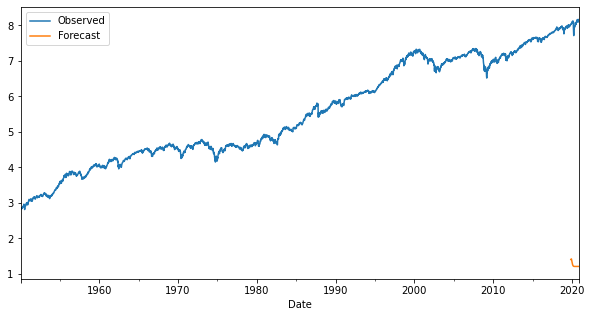

In [159]:
model = run_training_pipeline(lstm_data,
                      seq_length=52*3, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[50, 25], dropout_probs=[0.2, 0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_3years_50_25")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_5years

  | Name           | Type       | Params
----------------------------------------------
0 | lstm_layers    | ModuleList | 284 K 
1 | dropout_layers | ModuleList | 0     
2 | linear         | Linear     | 101   
----------------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params
1.136     Total estimated model params size (MB)


Sanity Checking: |                                                                           | 0/? [00:00<?, ?…

Training: |                                                                                  | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved. New best score: 6.577


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.574 >= min_delta = 0.0. New best score: 6.003


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 3.773 >= min_delta = 0.0. New best score: 2.230


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 1.203 >= min_delta = 0.0. New best score: 1.027


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.180 >= min_delta = 0.0. New best score: 0.847


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.086 >= min_delta = 0.0. New best score: 0.761


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.714


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.679


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.649


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.636


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.573


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.568


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.558


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.514


Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.458


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.458


Validation: |                                                                                | 0/? [00:00<?, ?…

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.445


Validation: |                                                                                | 0/? [00:00<?, ?…

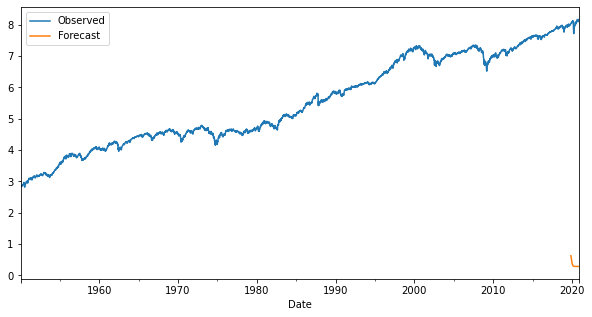

In [160]:
model = run_training_pipeline(lstm_data,
                      seq_length=52*5, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[200, 100], dropout_probs=[0.4, 0.3],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_5years")

In [161]:
model = run_training_pipeline(lstm_data,
                      seq_length=52, batch_size=16, input_size=2, prediction_len=1,
                      hidden_layer_sizes=[100, 100,100,100], dropout_probs=[0.2, 0.2,0.2,0.2],                      
                      learning_rate=1e-4,max_epochs=500,name="weekly_bs16_100*4")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/weekly_bs16_100*4


OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'C:/Users/Nir/Desktop/Time-Series-Course/Project/logs/weekly_bs16_100*4'

In [ ]:
s

In [ ]:
def predict_x_steps(model, data):
    model(data)

In [ ]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*5 + 1960 for i in range(10)]])
fold_train = data

# appendix

Defalut

12:51:09 - cmdstanpy - INFO - Chain [1] start processing
12:51:33 - cmdstanpy - INFO - Chain [1] done processing


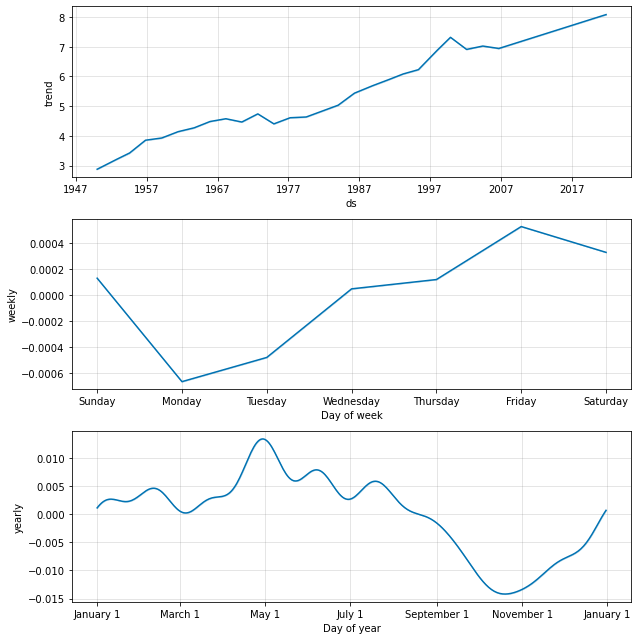

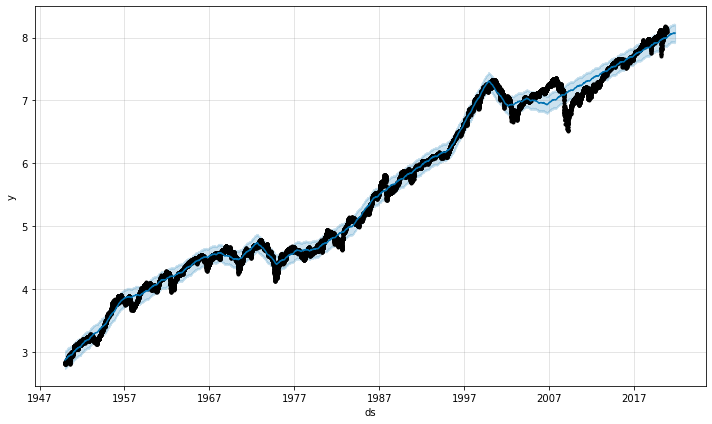

In [13]:
sp500_prophet = sp500.rename({"Date": "ds", "Log_Close": "y"}, axis =1)
m = Prophet()
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

changepoint_range = 0.95

12:51:45 - cmdstanpy - INFO - Chain [1] start processing
12:52:01 - cmdstanpy - INFO - Chain [1] done processing


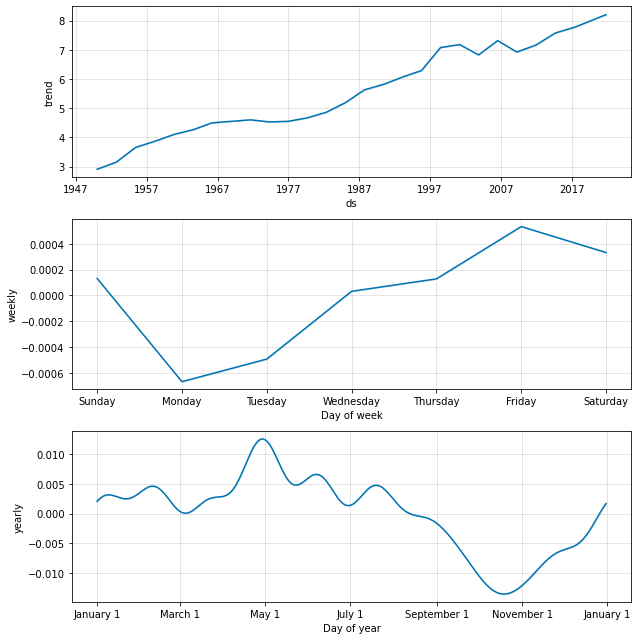

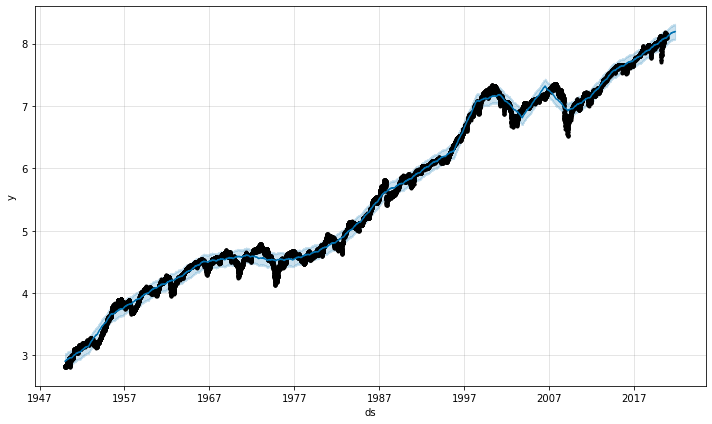

In [14]:
m = Prophet(changepoint_range = 0.95)
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

12:59:49 - cmdstanpy - INFO - Chain [1] start processing
13:02:01 - cmdstanpy - INFO - Chain [1] done processing


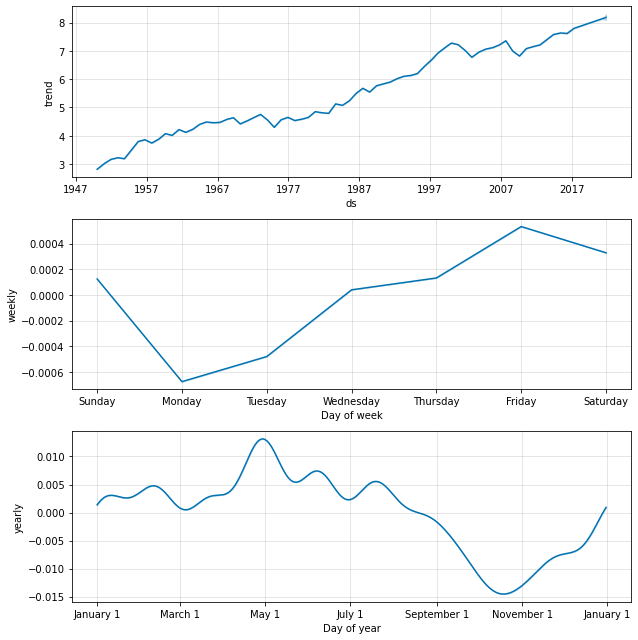

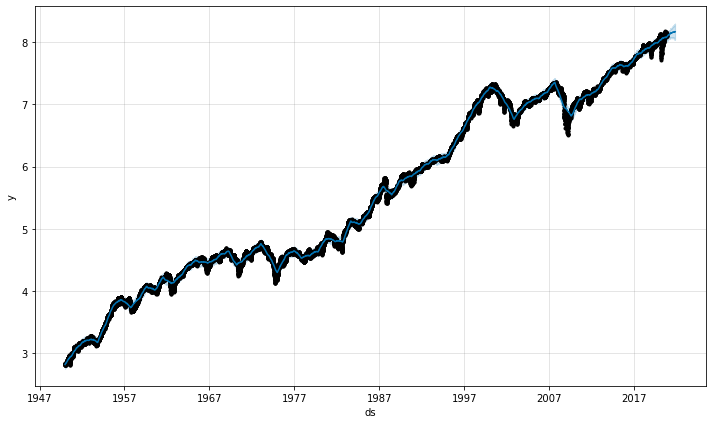

In [18]:
m = Prophet(changepoint_range = 0.95, n_changepoints=70)
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

Holidays

16:06:01 - cmdstanpy - INFO - Chain [1] start processing
16:06:25 - cmdstanpy - INFO - Chain [1] done processing


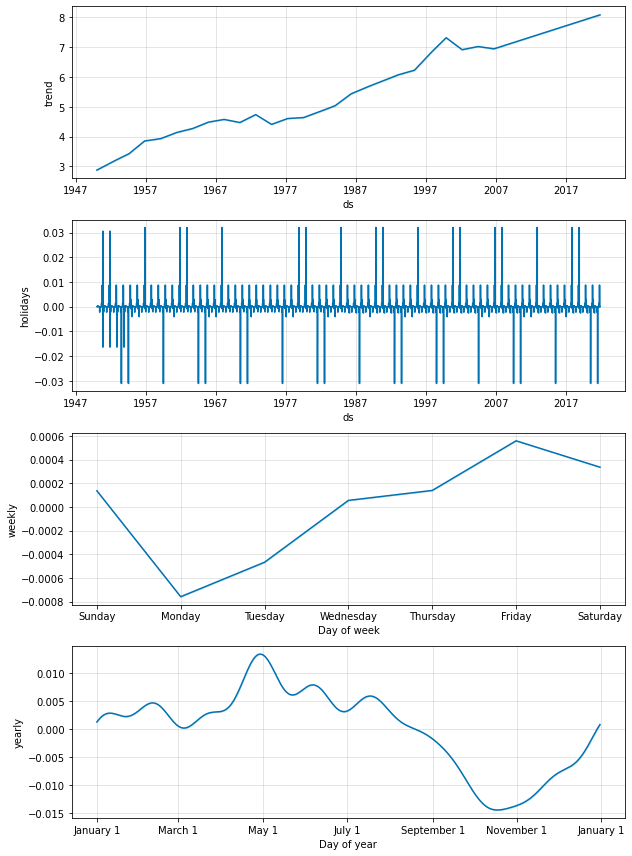

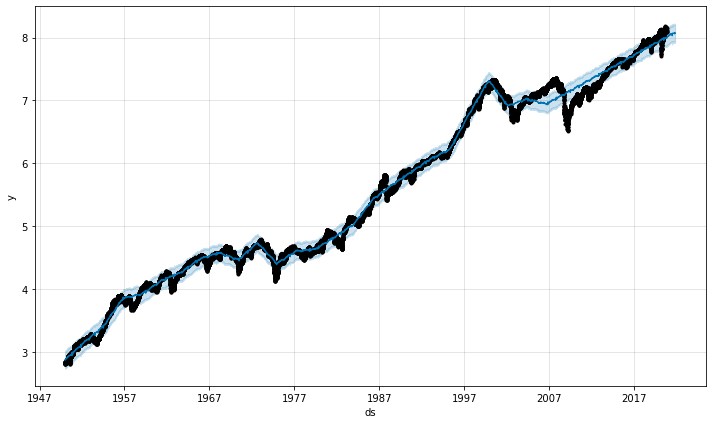

In [184]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

Volume + changepoint_range 0.95

16:49:00 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing


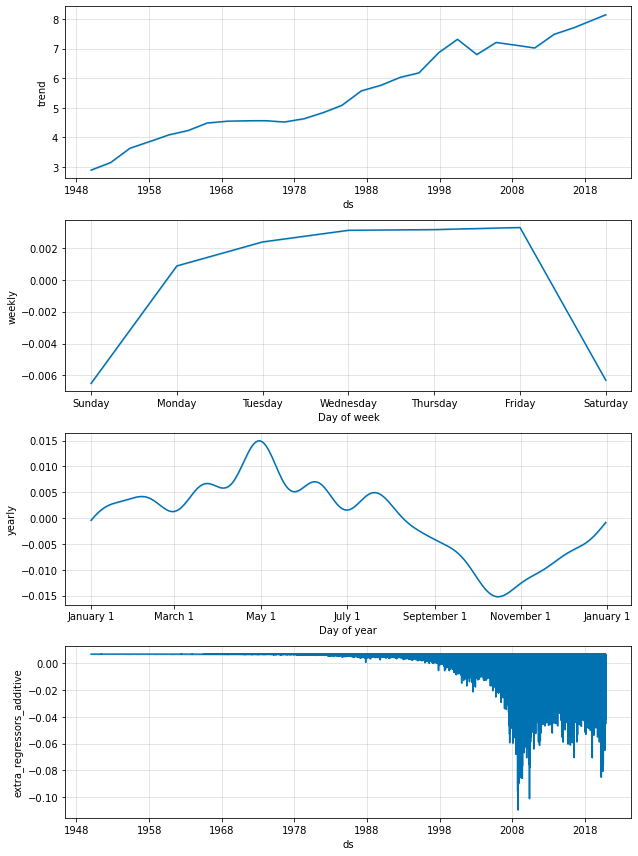

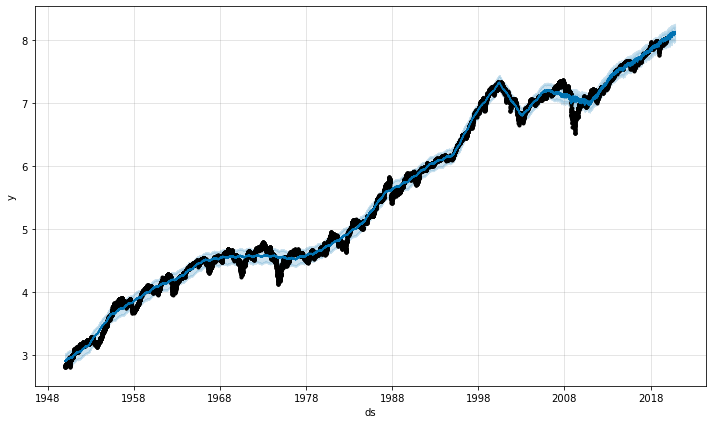

In [221]:
m = Prophet(changepoint_range = 0.95)
m.add_regressor("Volume")
m.fit(sp500_prophet[:-365])
future_dates = m.make_future_dataframe(periods=365)
future_dates['Volume'] = sp500_prophet['Volume']
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

with monthly seasonality

16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing


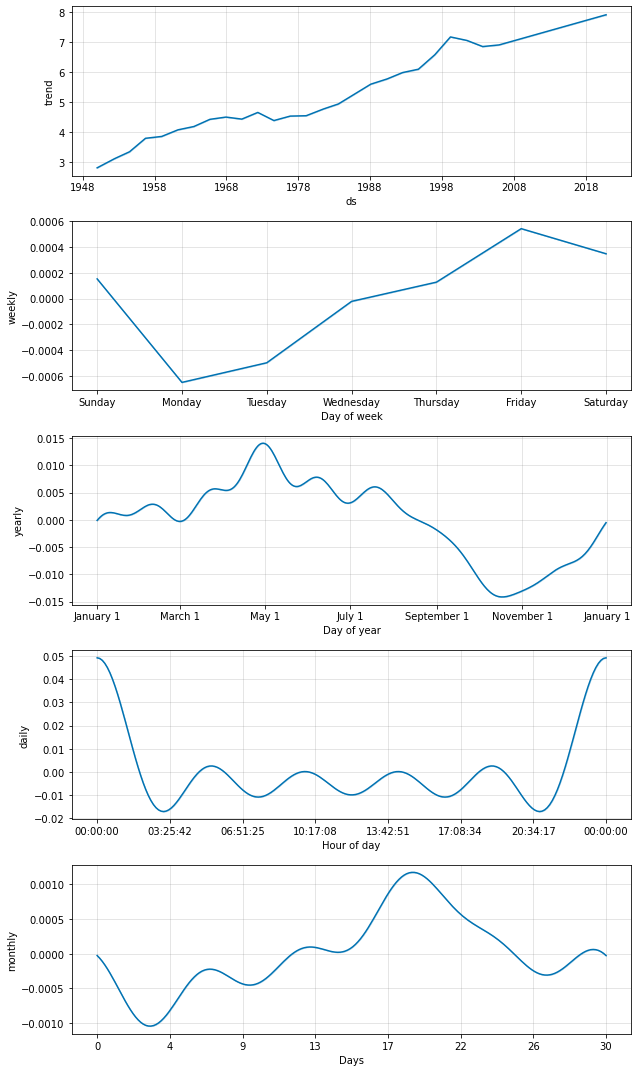

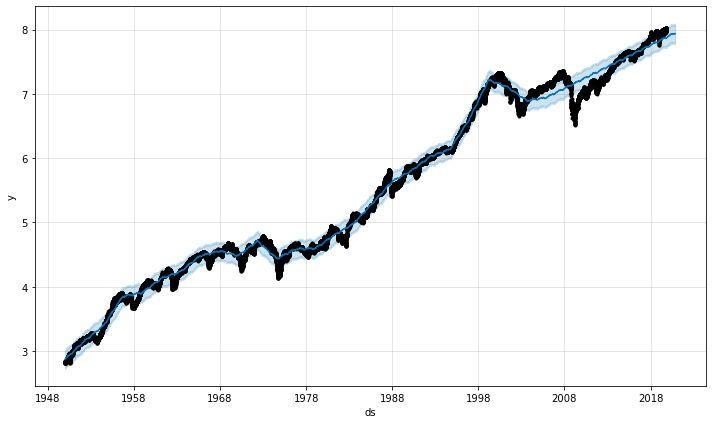

In [42]:
m = Prophet()
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(sp500_prophet[:-365])
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

In [188]:
def years_until_next_election(year):
    return (4 - (year % 4)) % 4

def fill_party_periods(periods, party):
    return {year: party for start, end in periods for year in range(start, end)}

def generate_presidential_parties():
    democrat_periods = [(1940, 1952), (1961, 1969), (1977, 1981), (1993, 2001), (2009, 2017), (2021, 2024)]
    republican_periods = [(1953, 1961), (1969, 1977), (1981, 1993), (2001, 2009), (2017, 2021)]
    parties = {}
    parties.update(fill_party_periods(democrat_periods, 'Democrat'))
    parties.update(fill_party_periods(republican_periods, 'Republican'))
    return parties

def generate_president_party_dataset(last_year=2023):
    presidential_parties = generate_presidential_parties()
    start_date = '1940-01-01'
    end_date = f'{last_year}-12-31'
    dates = pd.date_range(start=start_date, end=end_date, freq='D')

    data = {'Date': [], 'Years Until Next US Election': [], 'Presidential Party': []}
    for date in dates:
        year = date.year
        party = presidential_parties.get(year, 'Unknown')
        data['Date'].append(date)
        data['Years Until Next US Election'].append(years_until_next_election(year))
        data['Presidential Party'].append(party)
    
    df = pd.DataFrame(data)
    return df

president_party_df = generate_president_party_dataset()
president_party_df['Democrat'] = president_party_df['Presidential Party'] == 'Democrat'
president_party_df['Republican'] = president_party_df['Presidential Party'] == 'Republican'
president_party_df['Democrat'] = president_party_df['Democrat'].astype(int)
president_party_df['Republican'] = president_party_df['Republican'].astype(int)


In [193]:
sp500_prophet_enriched = sp500_prophet.merge(president_party_df[['Date', 'Years Until Next US Election', 
                                                                 'Democrat', 'Republican']],
                                             left_on='ds', right_on='Date', how='left')

Democrat party regressor

16:07:47 - cmdstanpy - INFO - Chain [1] start processing
16:08:04 - cmdstanpy - INFO - Chain [1] done processing


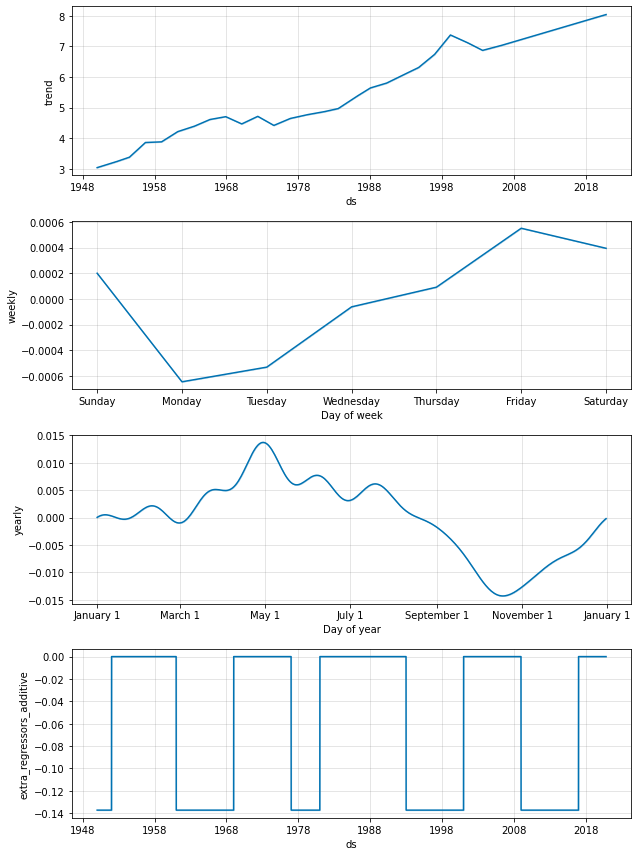

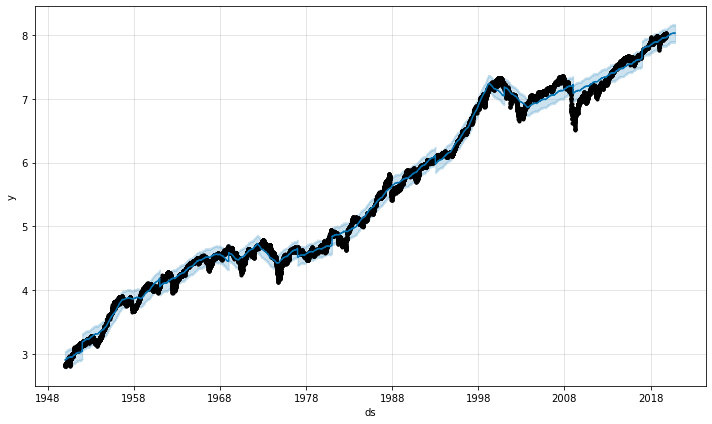

In [190]:
m = Prophet()
# m.add_regressor("Years Until Next US Election")
m.add_regressor("Democrat")
m.fit(sp500_prophet_enriched[:-365])
future_dates = m.make_future_dataframe(periods=365)
future_dates['Democrat'] = sp500_prophet_enriched['Democrat']
# future_dates['Years Until Next US Election'] = sp500_prophet_enriched['Years Until Next US Election']
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

In [ ]:
Democrat Republican, seasonality

16:15:22 - cmdstanpy - INFO - Chain [1] start processing
16:15:53 - cmdstanpy - INFO - Chain [1] done processing


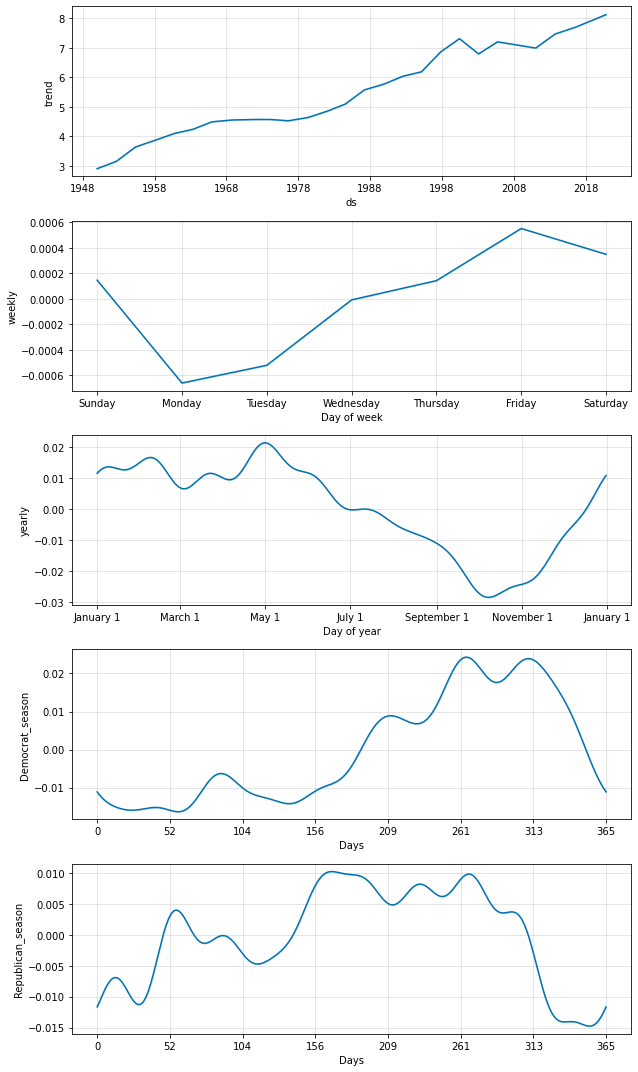

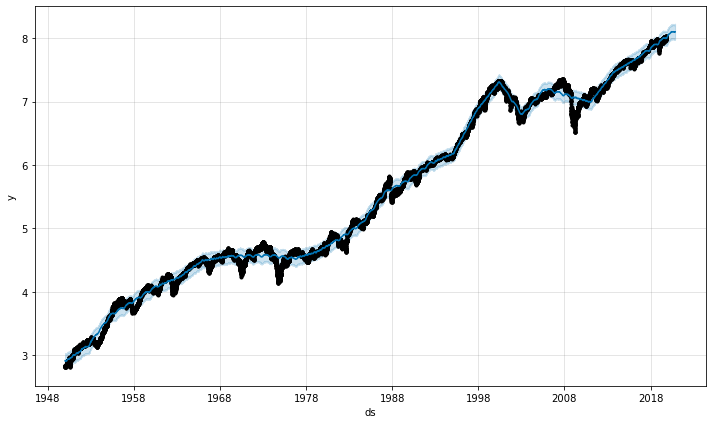

In [195]:
m = Prophet(changepoint_range = 0.95)
# m.add_regressor("Years Until Next US Election")
m.add_seasonality(name='Democrat_season', period=365, fourier_order=10, condition_name='Democrat')
m.add_seasonality(name='Republican_season', period=365, fourier_order=10, condition_name='Republican')
m.fit(sp500_prophet_enriched[:-365])
future_dates = m.make_future_dataframe(periods=365)
future_dates['Democrat'] = sp500_prophet_enriched['Democrat']
future_dates['Republican'] = sp500_prophet_enriched['Republican']
# future_dates['Years Until Next US Election'] = sp500_prophet_enriched['Years Until Next US Election']
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

cross validation

In [204]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*5 + 1960 for i in range(12)]])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")

  0%|          | 0/12 [00:00<?, ?it/s]

16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:45 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1] done processing
16:26:07 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1]

In [220]:
performance_metrics(df_cv, rolling_window=0)

horizon       mse      rmse       mae      mape     mdape     smape  coverage
0     1 days  0.004991  0.070647  0.047767  0.008133  0.006869  0.008173  0.833333
1     2 days  0.005055  0.071097  0.049558  0.008514  0.007680  0.008553  0.833333
2     3 days  0.005737  0.075745  0.052922  0.008994  0.007580  0.009034  0.833333
3     4 days  0.005858  0.076537  0.054681  0.009312  0.007859  0.009354  0.750000
4     5 days  0.005991  0.077401  0.055563  0.009406  0.007558  0.009450  0.833333
..       ...       ...       ...       ...       ...       ...       ...       ...
360 361 days  0.075474  0.274725  0.216659  0.039015  0.028109  0.040147  0.416667
361 362 days  0.075554  0.274872  0.216065  0.038965  0.027944  0.040112  0.500000
362 363 days  0.075736  0.275201  0.216113  0.038881  0.026647  0.040012  0.583333
363 364 days  0.076483  0.276555  0.217155  0.039030  0.026840  0.040172  0.333333
364 365 days  0.076734  0.277009  0.217538  0.039086  0.027165  0.040230  0.500000

[365 rows x 8 columns]